### Librerías y lectura de datos

In [1]:
# Paquetes utilizados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
import pickle

from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, precision_recall_curve, make_scorer, fbeta_score, f1_score, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.utils.multiclass import unique_labels
from inspect import signature
from sklearn import tree
from graphviz import Source
from scipy.stats import mode

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Lectura de datos
trn=pd.read_csv('datasets_finales/train2_clust.csv')
val=pd.read_csv('datasets_finales/train_val2_clust.csv')
tst=pd.read_csv('datasets_finales/test2_clust.csv')
trn_complete=pd.read_csv('datasets_finales/train_complete2_clust.csv')

# Permutamos las observaciones (originalmente están primero todos los ceros y luego todos los 1)
trn = trn.sample(frac=1, random_state=42).reset_index(drop=True)
val = val.sample(frac=1, random_state=42).reset_index(drop=True)
tst = tst.sample(frac=1, random_state=42).reset_index(drop=True)
trn_complete = trn_complete.sample(frac=1, random_state=42).reset_index(drop=True)

# Separamos en X e Y
X_trn = trn.copy().drop(['TARGET'], axis=1)
X_val = val.copy().drop(['TARGET'], axis=1)
X_tst = tst.copy().drop(['TARGET'], axis=1)
X_trn_c = trn_complete.copy().drop(['TARGET'], axis=1)

Y_trn = trn['TARGET']
Y_val = val['TARGET']
Y_tst = tst['TARGET']
Y_trn_c = trn_complete['TARGET']

# Mantenemos una copia sin escalar para hacer los árboles interpretables
X_trn_unscaled=X_trn.copy()
X_val_unscaled=X_val.copy()
X_tst_unscaled=X_tst.copy()
X_trn_c_unscaled=X_trn_c.copy()

# Escalamos X
X_trn=scale(X_trn)
X_val=scale(X_val)
X_tst=scale(X_tst)
X_trn_c=scale(X_trn_c)

### Funciones

In [3]:
# Aumentando el threshold
def threshold(y_pred_proba, cutoff=0.5):
    return [1 if pred > cutoff else 0 for pred in y_pred_proba]

In [4]:
# Para ir guardando las probabilidades predichas
probs={}
probs['trn']={}
probs['val']={}
probs['tst']={}

In [5]:
# Evaluation functions
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)
f05_scorer = make_scorer(fbeta_score, beta=0.5, pos_label=1)
f1_scorer = make_scorer(f1_score, pos_label=1)

In [6]:
# Plot ROC
def plot_roc_curve(y_tst, y_pred_prob, col='darkorange', lab= 'ROC Train'):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_tst, y_pred_prob, drop_intermediate=False)
    roc_auc = auc(fpr, tpr)
    ans=plt.plot(fpr, tpr, color=col,
             lw=2, label=lab+' (area = %0.3f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve:')
    plt.legend(loc="lower right")
    return ans


In [7]:
def plot_pr_curve(y_tst, y_pred_prob, col='r'):
    precision, recall, _ = precision_recall_curve(y_tst, y_pred_prob, pos_label=1)
    ans = plt.step(recall, precision, color=col, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve:')
    return ans

In [8]:
def plot_confusion_matrix(y_true, y_pred, classes=[0,1],
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Matriz de Confusión'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(3,3))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#     ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    if normalize:
        thresh = 0.5
    else:
        thresh = (cm.max()-cm.min()) / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if normalize:
                ax.text(j, i, format(cm[i, j]/np.sum(cm), fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j]/np.sum(cm)> thresh else "black",
                    fontdict = {
                        'family' : 'normal',
                        'weight' : 'bold',
                        'size'   : 14})
            else:
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j]-cm.min() > thresh else "black",
                        fontdict = {
                            'family' : 'normal',
                            'weight' : 'bold',
                            'size'   : 14})
    fig.tight_layout();
    return ax

In [9]:
def plot_prt_curve(y_tst, y_pred_prob):
    precision, recall, trs = precision_recall_curve(y_tst, y_pred_prob, pos_label=1)
    plt.plot(trs, recall[1:],label='Recall')
    plt.plot(trs, precision[1:], label='Precision')
    plt.xlabel('Threshold')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="center left")
    plt.title('PR sobre el Threshold:')


In [10]:
def plot_fbeta_curve(y_tst, y_pred_prob, beta=0.5):
    precision, recall, trs = precision_recall_curve(y_tst, y_pred_prob, pos_label=1)
    beta2=beta**2
    fbeta = (1+beta2)*(precision*recall)/((beta2*precision)+recall)
    plt.plot(trs, fbeta[1:],label='f_'+str(beta)+'_score')
    plt.xlabel('Threshold')
    plt.xlim([0.0, 1.0])
    plt.legend(loc="lower left")
    plt.title('F_beta sobre Threshold:')

In [11]:
# Función de evaluación final
def evaluate_predictions(y_trn, y_pred, y_pred_val = None, y_pred_tst=None, y_val=Y_val, y_tst=Y_tst,
                         lift_label_x=50, lift_label_y=3.5):
    y_pred_cut = threshold(y_pred, 0.5)
    print("F0.5 Score Train: %.3f"%fbeta_score(y_trn, y_pred_cut, pos_label=1, beta=0.5))
    if not(y_pred_val is None):
        y_pred_val_cut = threshold(y_pred_val, 0.5)
        print("F0.5 Score Val: %.3f"%fbeta_score(y_val, y_pred_val_cut, pos_label=1, beta=0.5))
    
    if not(y_pred_tst is None):
        y_pred_tst_cut = threshold(y_pred_tst, 0.5)
        print("F0.5 Score Test: %.3f"%fbeta_score(y_tst, y_pred_tst_cut, pos_label=1, beta=0.5))
    
#     plt.figure(figsize=(12,5))
#     plt.subplot(1,3,1)
    plot_confusion_matrix(y_trn, y_pred_cut,title="Matriz de Confusión Train")
    if not(y_pred_val is None):
#       plt.subplot(1,3,2)
        plot_confusion_matrix(y_val, y_pred_val_cut,title="Matriz de Confusión Test");
    if not(y_pred_tst is None):
#       plt.subplot(1,3,3)
        plot_confusion_matrix(y_tst, y_pred_tst_cut,title="Matriz de Confusión Test_2019");

    
    plt.figure(figsize=(12,5), dpi= 300)
    
    plt.subplot(1,2,1)
    sns.distplot(y_pred, color='darkorange', hist=False, label='Train')
    if not(y_pred_val is None):
        sns.distplot(y_pred_val, color='cornflowerblue', hist=False, label='Test')
    if not(y_pred_tst is None):
        sns.distplot(y_pred_tst, color='green', hist=False, label='Test_2019')
        
    plt.title("Probabilidades Predichas")
    plt.subplot(1,2,2)
    plot_roc_curve(y_trn, y_pred, col='darkorange')
    if not(y_pred_val is None):
        plot_roc_curve(y_val, y_pred_val, col='cornflowerblue', lab='ROC Test')
    if not(y_pred_tst is None):
        plot_roc_curve(y_tst, y_pred_tst, col='green', lab='ROC Test_2019')
    
    plt.show();
    
#     plt.figure(figsize=(12,3), dpi= 300)
#     plt.subplot(1,3,1)
#     plot_fbeta_curve(y_trn, y_pred)
#     if not(y_pred_val is None):
#         plt.subplot(1,3,2)
#         plot_fbeta_curve(y_val, y_pred_val)
#     if not(y_pred_tst is None):
#         plt.subplot(1,3,3)
#         plot_fbeta_curve(y_tst, y_pred_tst)
    
    plt.tight_layout()
    plt.show()
    if not(y_pred_val is None):
        lift_chart(Y_val, y_pred_val,1000,lift_label_x=lift_label_x, lift_label_y=lift_label_y)
    
    plt.show();


In [12]:
def plottree(decisiontree, features_names=None, class_names=None):
    """Returns a graphviz visualization of a scikit-learn decision tree
    
    Inputs
        - decisiontree: tree to visualize
        - feature_names: iterable with the names of the features present in the data.
        - class_names: iterable with the names of the classes present in the data, in increasing order.
        
    If the call to this function is the last line of a notebook cell, the tree is rendered automatically.
    """
    dot_data = tree.export_graphviz(
        decisiontree,
        out_file=None,
        filled=True,
        rounded=True,
        rotate=True,
        proportion=True,
        feature_names=features_names,
        class_names=class_names
    )
    return Source(dot_data)

In [13]:
def top_n(Y_tst, Y_pred_proba, n=1000):
    Y_pred_top = pd.Series(Y_pred_proba).sort_values(ascending=False)[:n]
    indices=list(Y_pred_top.index)
    Y_tst_res = list(pd.Series(Y_tst).iloc[indices])
    return (Y_tst_res, Y_pred_top)

def lift_chart(Y_tst, Y_pred_proba, n=1000,lift_label_x=50, lift_label_y=3.2):
    Y_pred_top = pd.Series(Y_pred_proba).sort_values(ascending=False)[:n]
    indices=list(Y_pred_top.index)
    Y_tst_res = list(pd.Series(Y_tst).iloc[indices])
    
    hits = 0
    clients = 0
    lift = np.repeat([1.0], n)
    for i in range(n):
        clients +=1
        if Y_tst_res[i]==1:
            hits +=1
        lift[i]=hits/clients
    
    hits = np.repeat([0], len(Y_tst))
    Y_pred_top = pd.Series(Y_pred_proba).sort_values(ascending=False)
    indices=list(Y_pred_top.index)
    Y_tst_res = list(pd.Series(Y_tst).iloc[indices])
    for i in range(len(Y_tst)):
        if i==0:
            hits[i]=Y_tst_res[i]
        else:
            hits[i]=hits[i-1]+Y_tst_res[i]
    
    base_prob = np.sum(Y_tst)/len(Y_tst)
    lift = lift / base_prob
    plt.figure(figsize=(12,3), dpi= 300)
    plt.title("Lift sobre la Probabilidad Base (Top 1000)")
    plt.plot(lift, label="Lift Predicciones")
    plt.plot(np.repeat([1.0], n), label="Proporción Base")
    plt.ylim(0,max(4,max(lift[2:])))
    plt.legend(loc="lower right")
    plt.annotate('Lift: %0.3f' %lift[len(lift)-1], xy=(lift_label_x,lift_label_y))
    prop = hits[:n]
    plt.annotate("Hits: "+ str(max(prop)), xy=(lift_label_x,lift_label_y + max(4,max(lift[1:]))*0.1))
    plt.show()
    
#     Y_pred_top = pd.Series(Y_pred_proba).sort_values(ascending=False)
#     indices=list(Y_pred_top.index)
#     Y_tst_res = list(pd.Series(Y_tst).iloc[indices])
    
#     total_1s=np.sum(Y_tst)
#     total_clientes = len(Y_tst)
    
#     plt.figure(figsize=(12,3), dpi= 300)
#     plt.title("Verdaderos Positivos en el Top "+str(n))
#     prop = hits[:n]
#     plt.plot(prop)
#     plt.ylim(0,max(prop)+1)
    
#     plt.show()


### Exploración pre-modelos

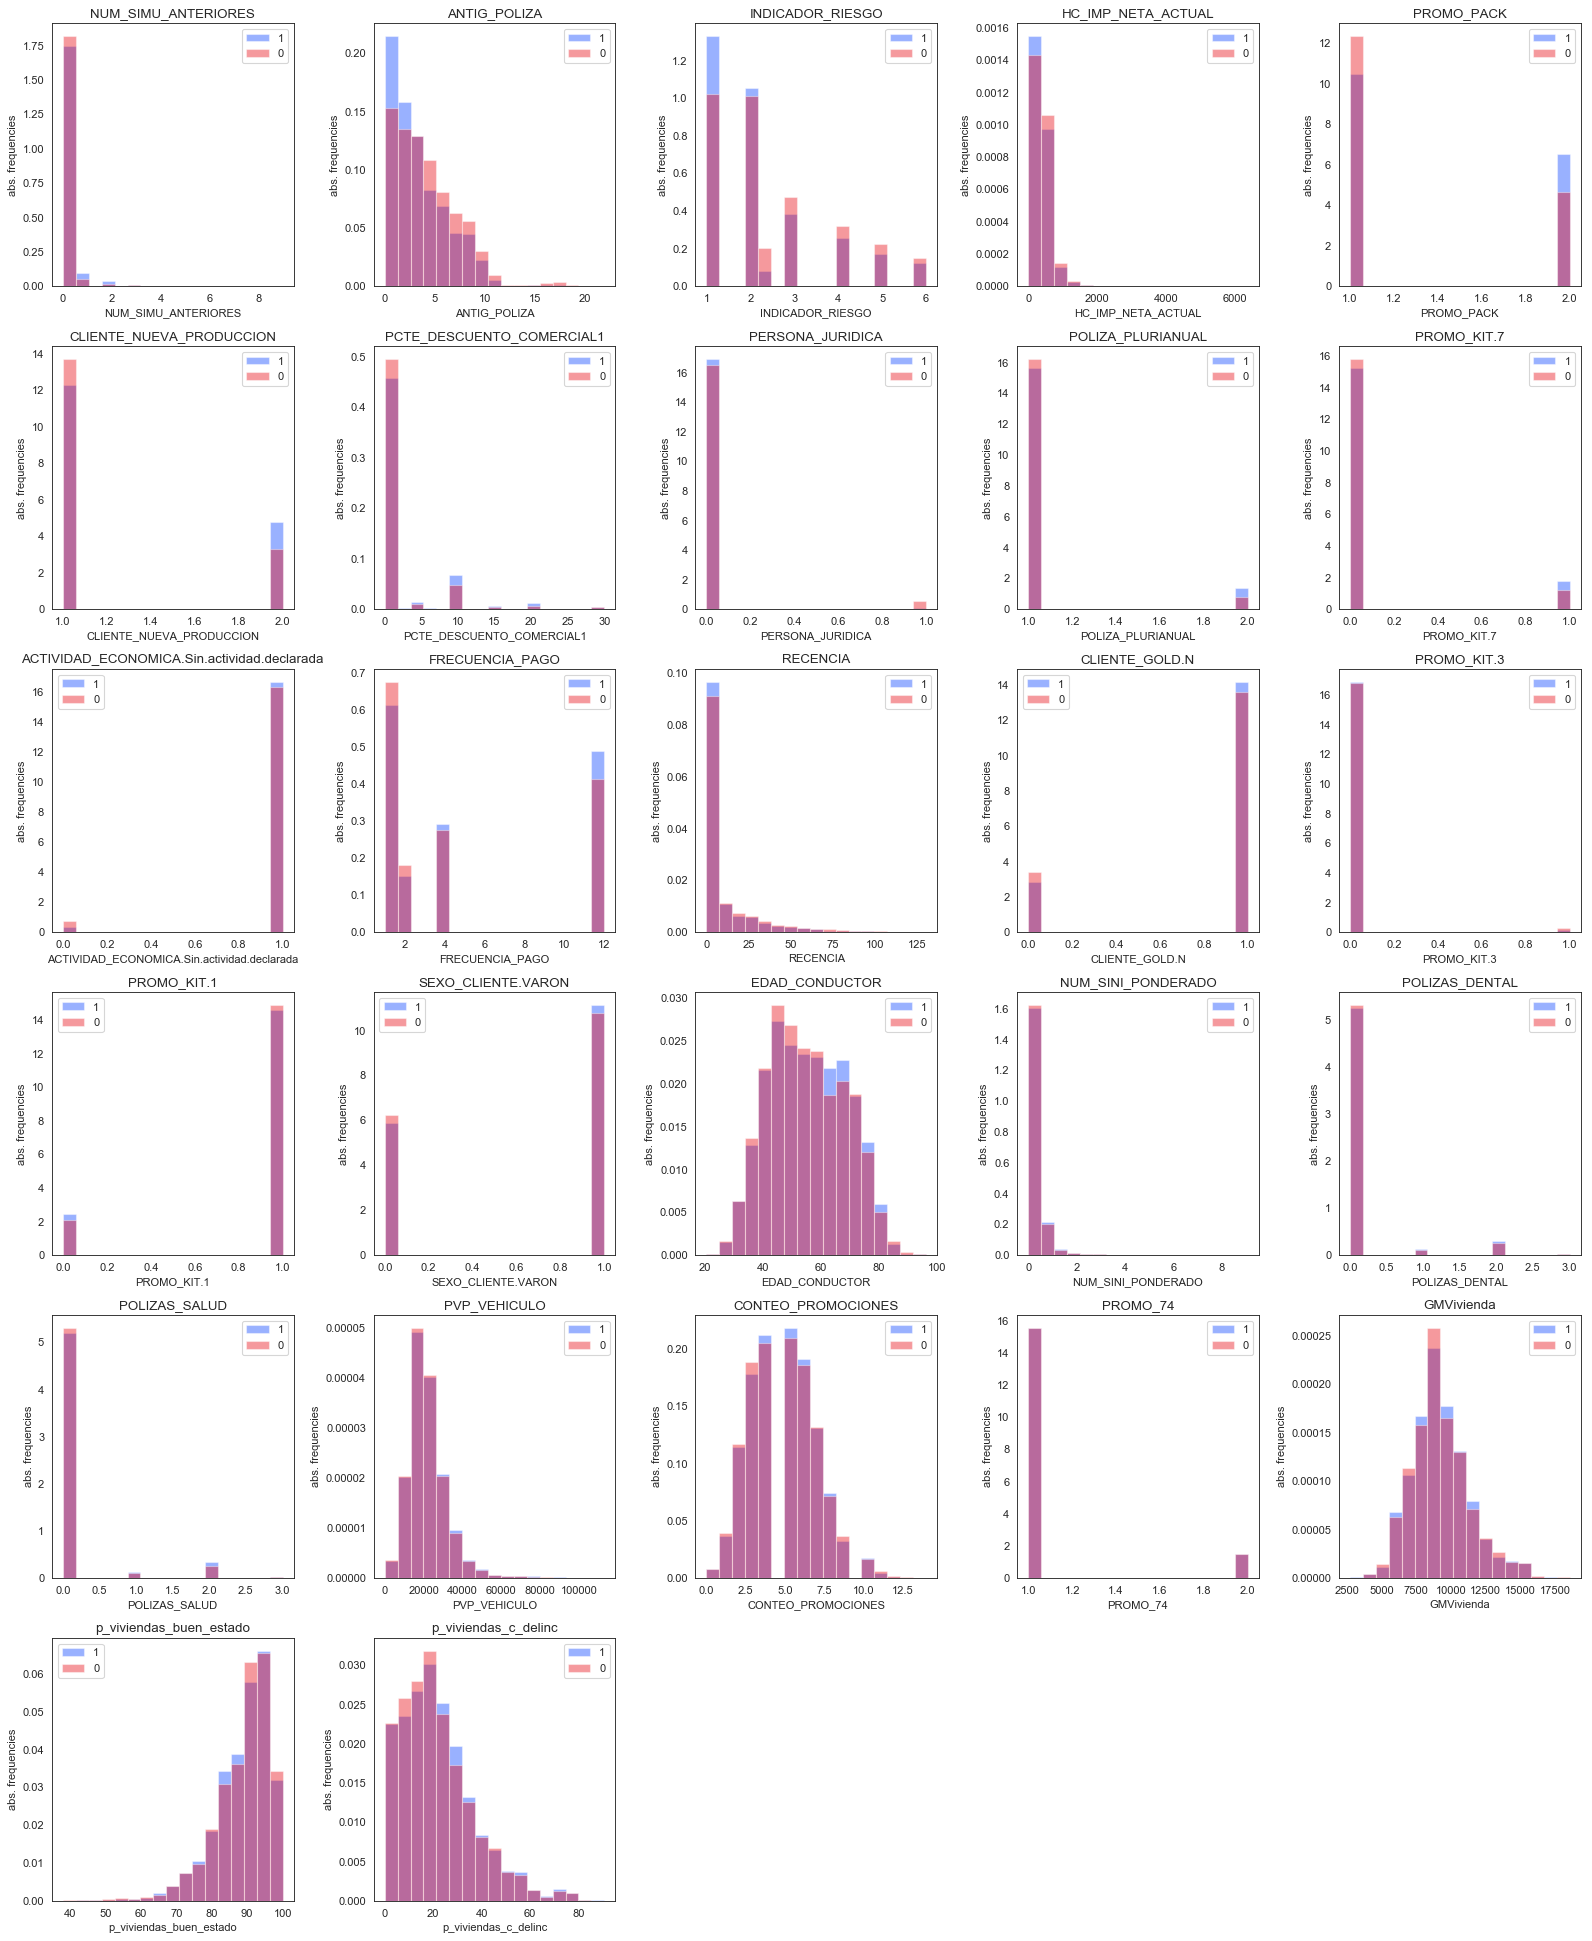

In [92]:
#sns.set(color_codes=True)
sns.set_color_codes("bright")
sns.set_style("white")

num_columns = 5 # Cols in plots layout
num_rows = int( np.ceil( len(trn.columns)/num_columns ) ) # Rows in plots layout
bins = 17

plt.figure( figsize=(20, 4*num_rows), dpi= 80)
plt.title("Histogramas por Target")

for i, var in enumerate (trn.columns):
    if var=="TARGET":
        break # Nos saltamos el TARGET y los clusters
    
    pos = np.where( trn['TARGET'] == 1)[0]
    neg = np.where( trn['TARGET'] == 0)[0]

    ax = plt.subplot(num_rows, num_columns, i+1)
    ax.set_title(var)
    #plt.hist( trn[ var ].iloc[pos], bins=bins, color='b', label='pos', alpha=0.5)
    #plt.hist( trn[ var ].iloc[neg], bins=bins, color='r', label='neg', alpha=0.5)

    sns.distplot( trn[ var ].iloc[pos],
                 bins=bins,
                 norm_hist=True,
                 kde=False,
                 color='b',
                 label='1',
                 hist_kws={"range": [min(trn[ var ]),max(trn[ var ])]})
    sns.distplot( trn[ var ].iloc[neg],
                 bins=bins,
                 norm_hist=True,
                 kde=False, color='r',
                 label='0',
                 hist_kws={"range": [min(trn[ var ]),max(trn[ var ])]})
    
    plt.ylabel("abs. frequencies")
    plt.legend(loc='best')
    plt.tight_layout()


### "Modelo" Base

F0.5 Score Train: 0.385
F0.5 Score Val: 0.057
F0.5 Score Test: 0.006


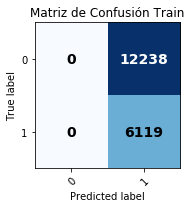

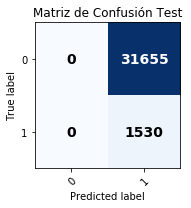

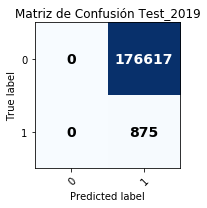

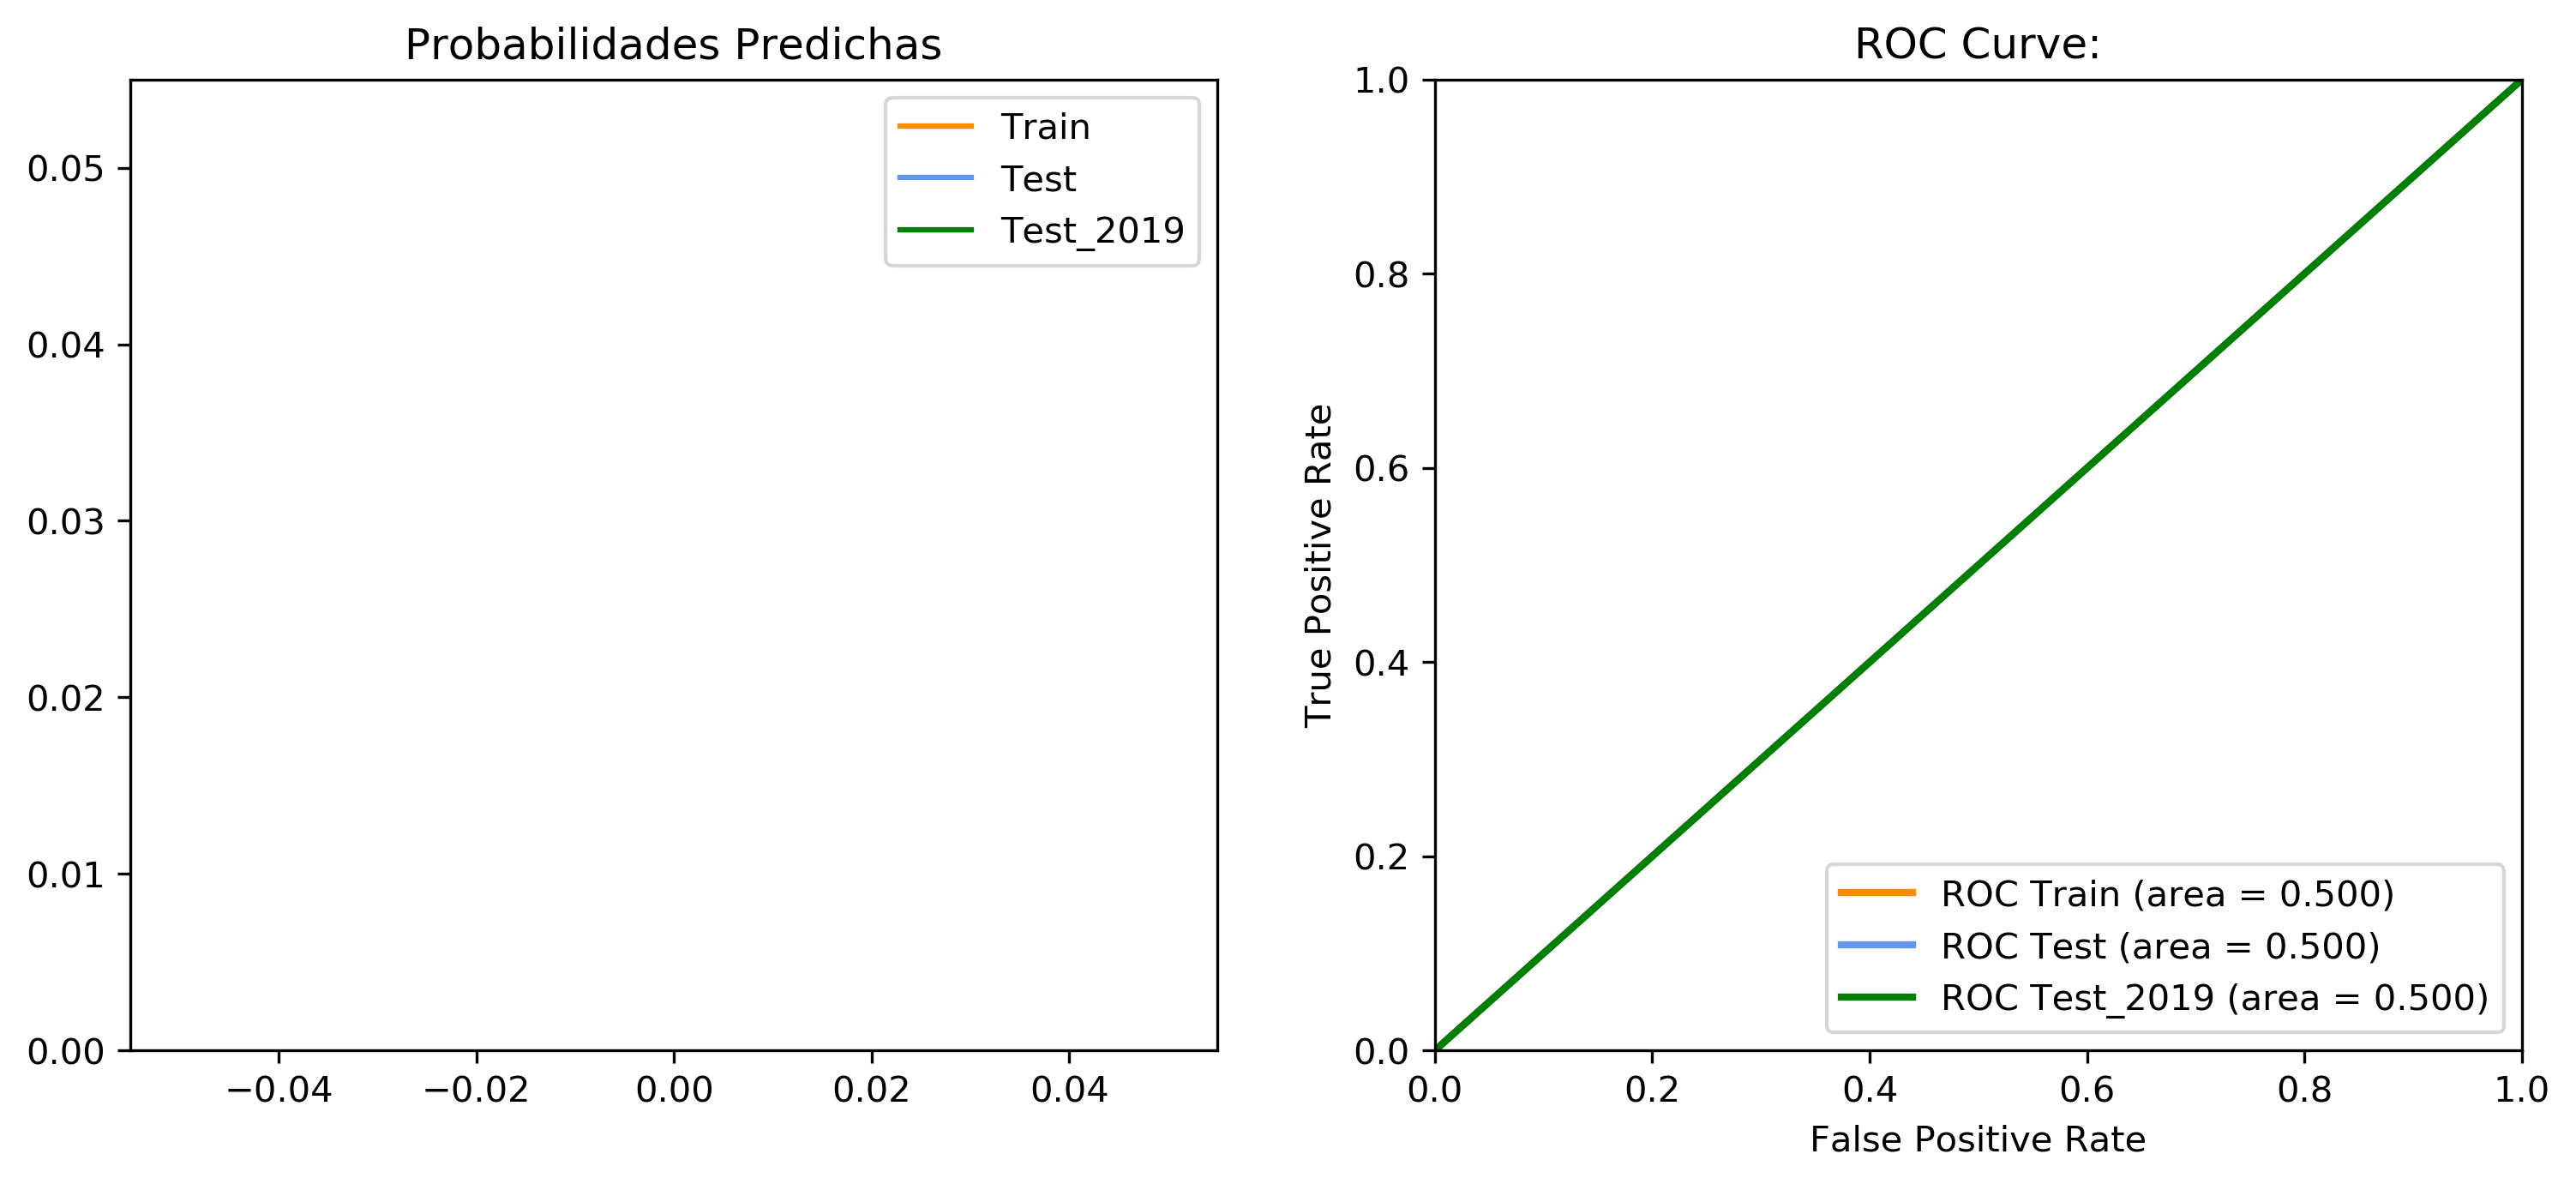

<Figure size 432x288 with 0 Axes>

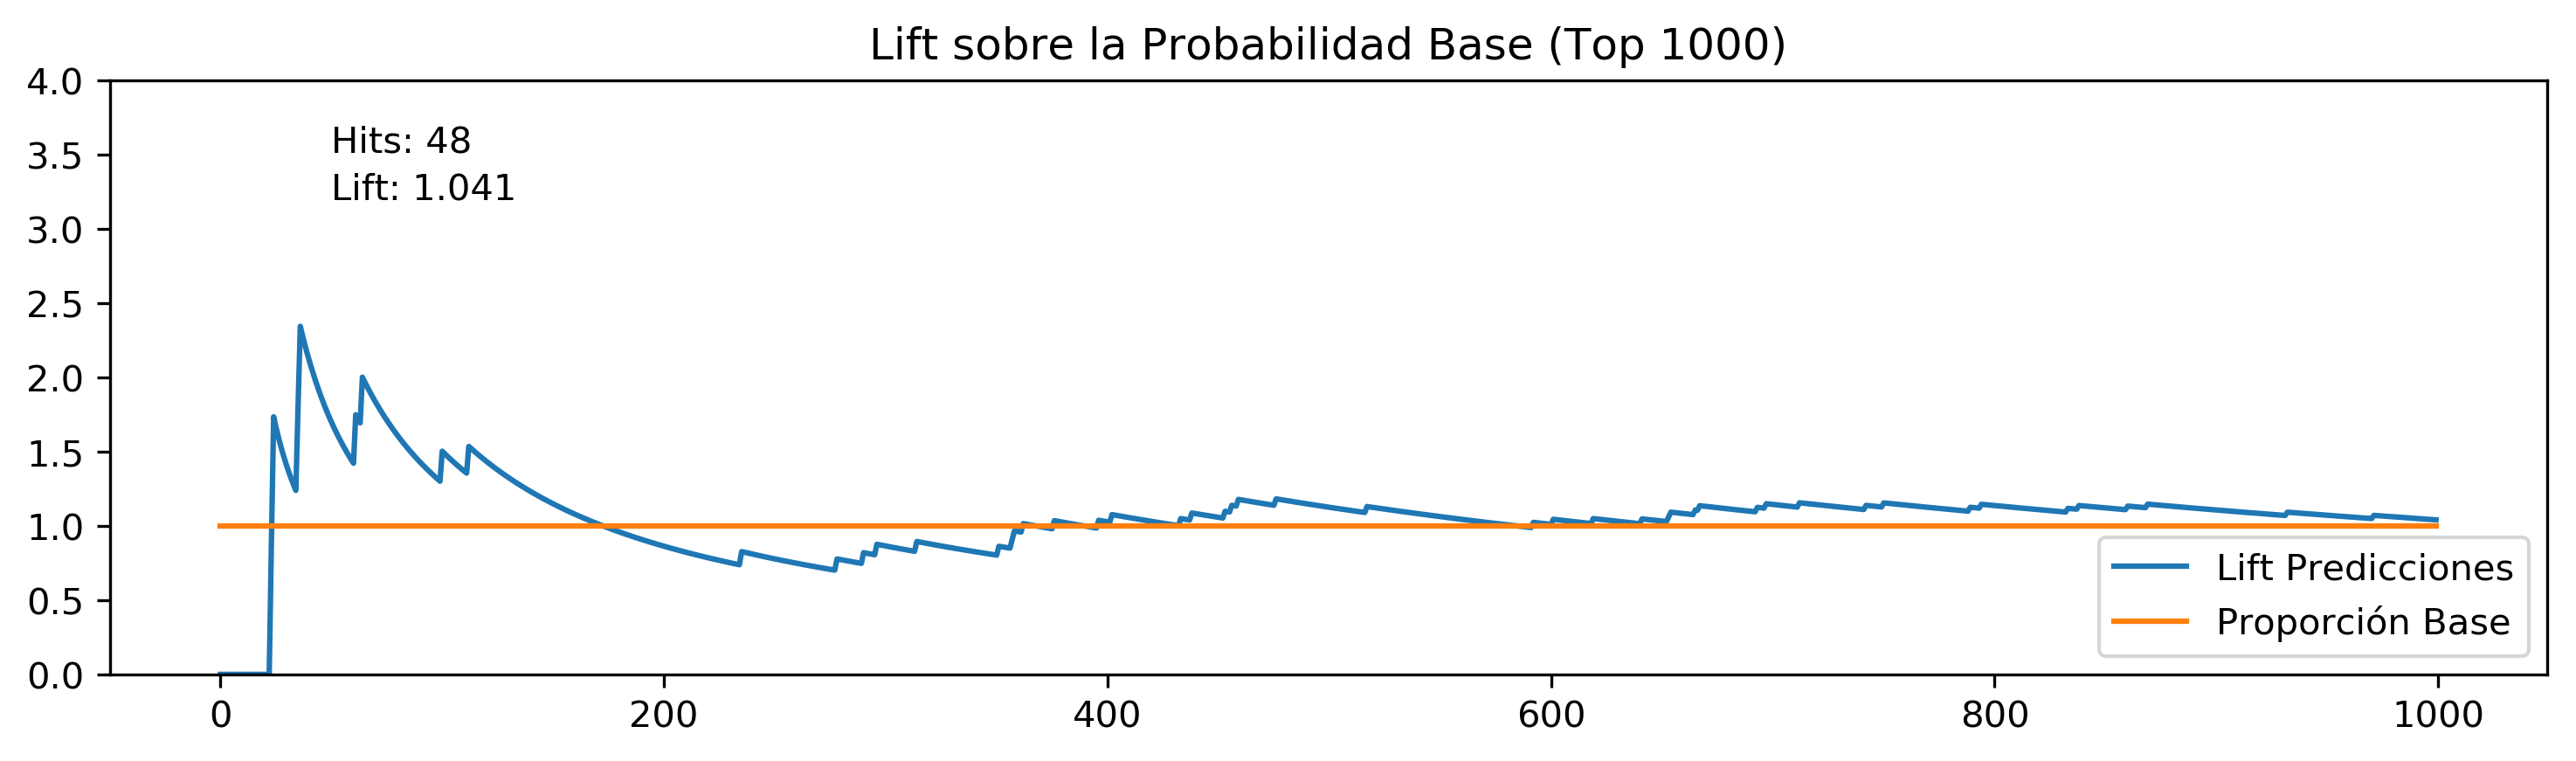

In [20]:
# Todos 1s
Y_base_pred=np.repeat([1], len(Y_trn))
Y_base_pred_val=np.repeat([1], len(Y_val))
Y_base_pred_tst=np.repeat([1], len(Y_tst))
evaluate_predictions(Y_trn, Y_base_pred, Y_base_pred_val,Y_base_pred_tst)

## Modelos

### K-Nearest Neighbors

In [16]:
# Knn
knn_param_grid = {
    'n_neighbors':[3,5,7,11],
    #'n_neighbors':[75,101,151]
}
knn_mdl = GridSearchCV(KNeighborsClassifier(),
                       knn_param_grid,
                       scoring=f05_scorer,
                       cv=4,
                       n_jobs=-1,
                       return_train_score=True, verbose=1)
knn_mdl.fit(X_trn, Y_trn)
pd.DataFrame(knn_mdl.cv_results_).sort_values(by=['rank_test_score'])\
[['params', 'mean_test_score', 'mean_train_score']].head()

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:   41.6s remaining:   24.9s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   57.2s finished


params  mean_test_score  mean_train_score
0   {'n_neighbors': 3}         0.387260          0.706227
1   {'n_neighbors': 5}         0.372588          0.622123
2   {'n_neighbors': 7}         0.363704          0.573128
3  {'n_neighbors': 11}         0.351154          0.509642

In [ ]:
Y_pred = probs['trn']['knn'] = knn_mdl.predict_proba(X_trn)[:,1]
Y_pred_val = probs['val']['knn'] = knn_mdl.predict_proba(X_val)[:,1]
knn_mdl.best_estimator_.fit(X_trn_c, Y_trn_c)
Y_pred_tst = probs['tst']['knn'] = knn_mdl.predict_proba(X_tst)[:,1]

F0.5 Score Train: 0.707
F0.5 Score Val: 0.073
F0.5 Score Test: 0.008


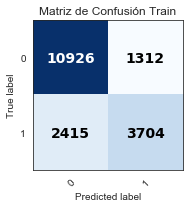

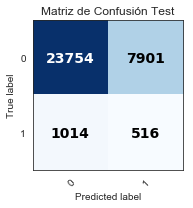

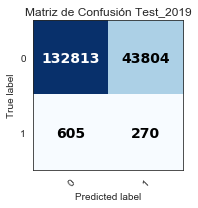

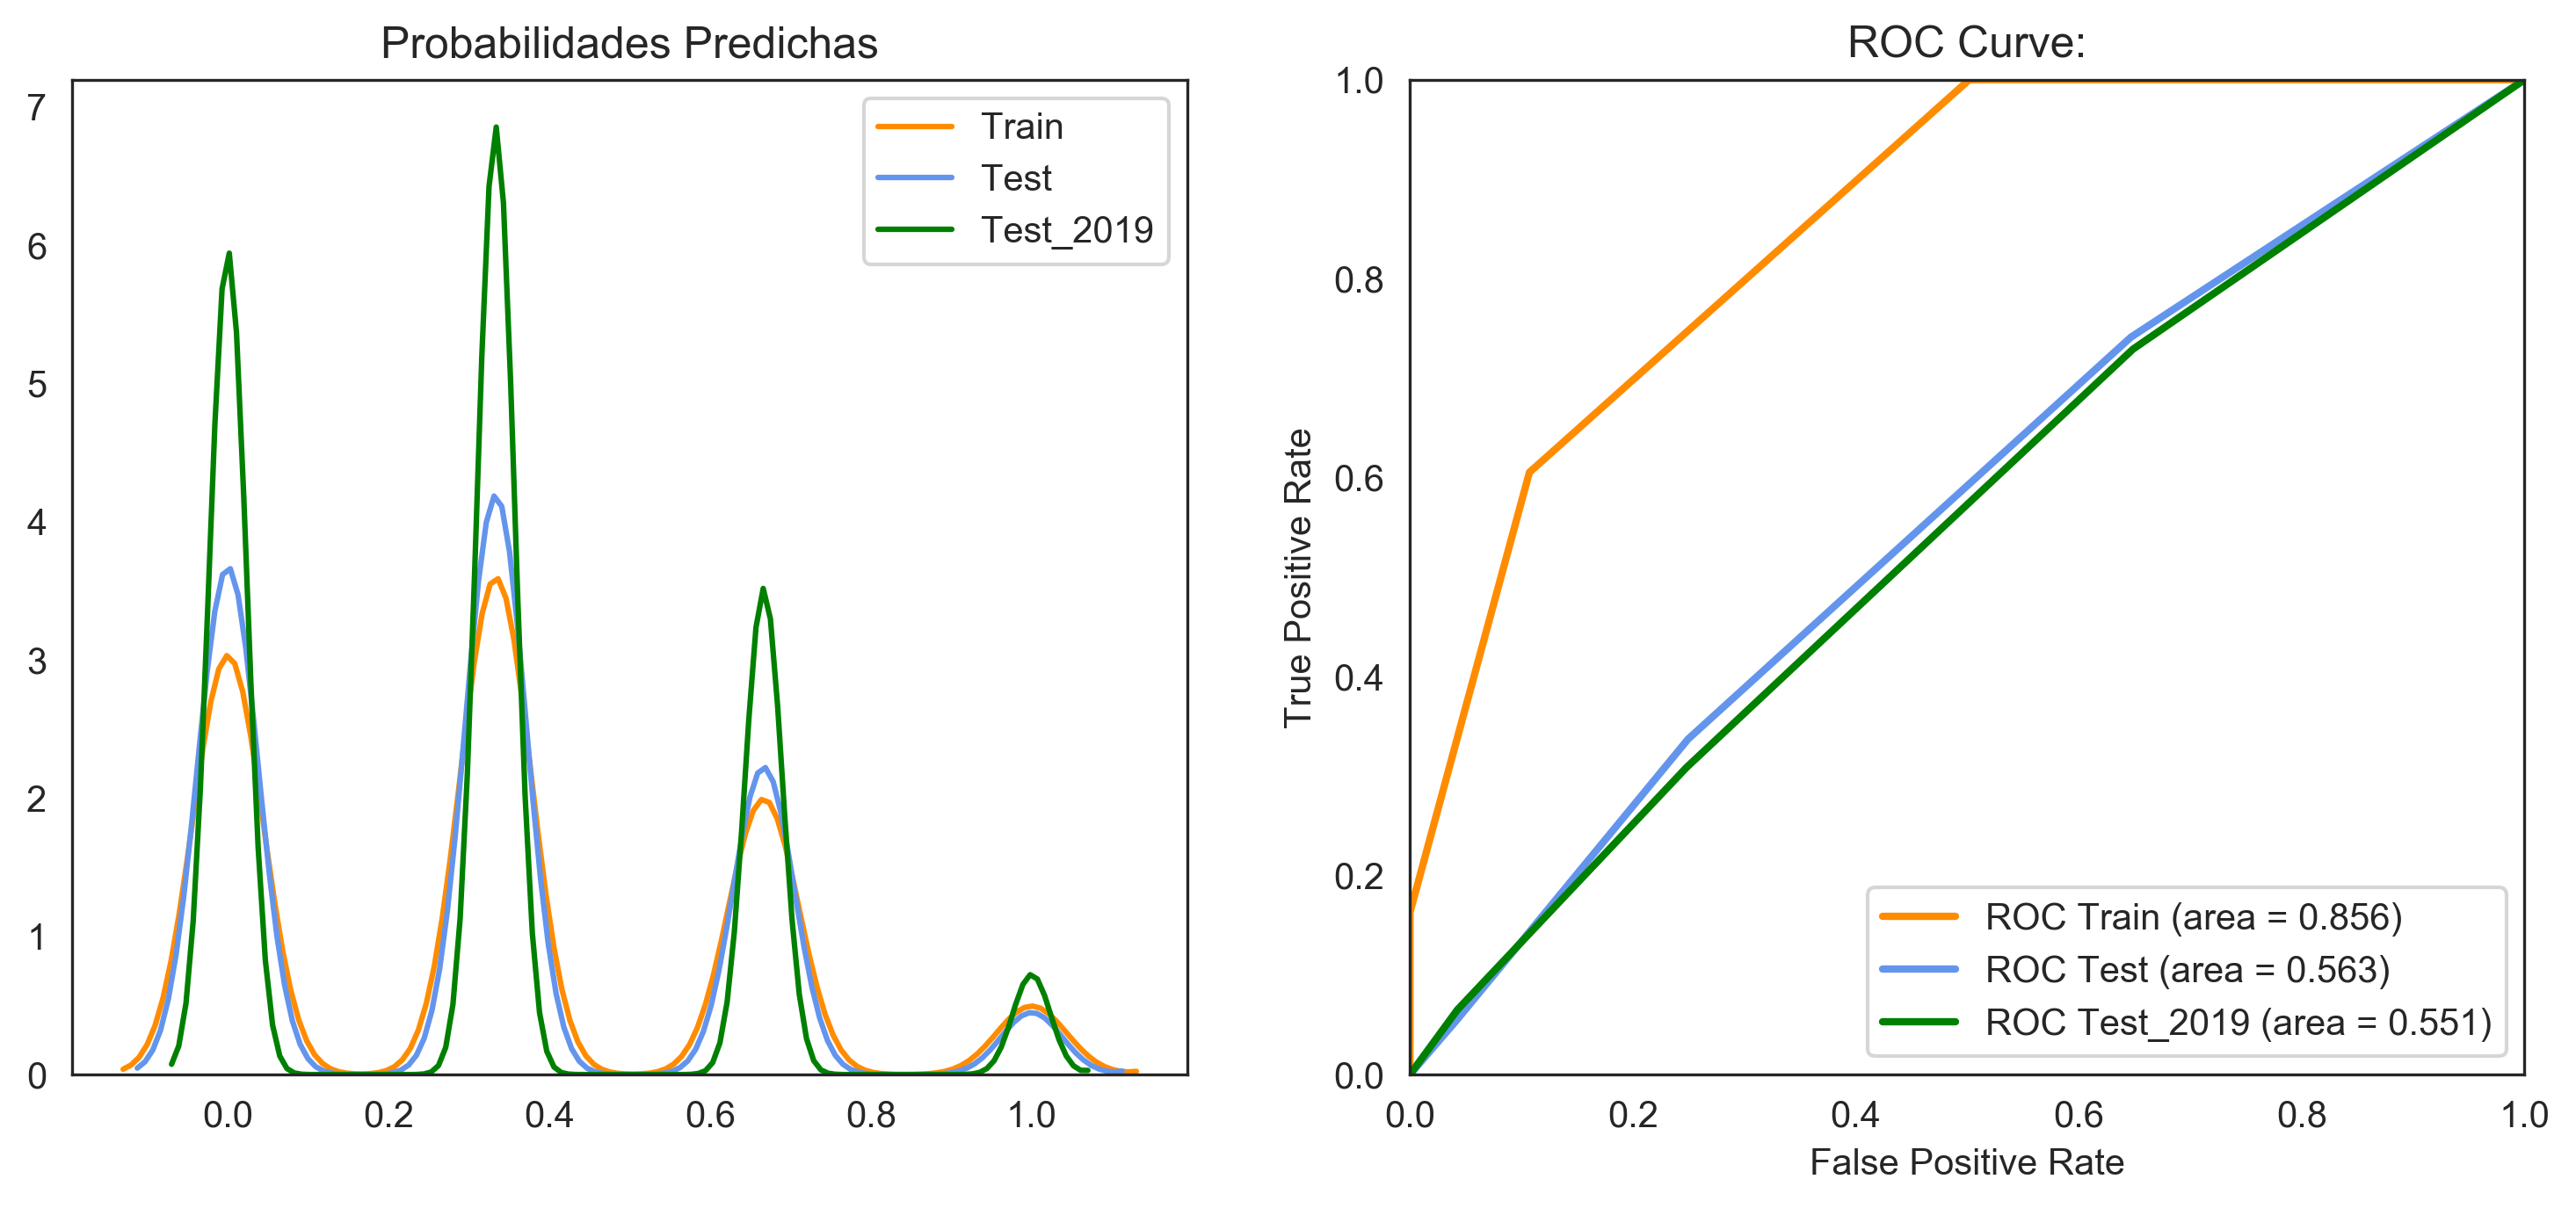

<Figure size 432x288 with 0 Axes>

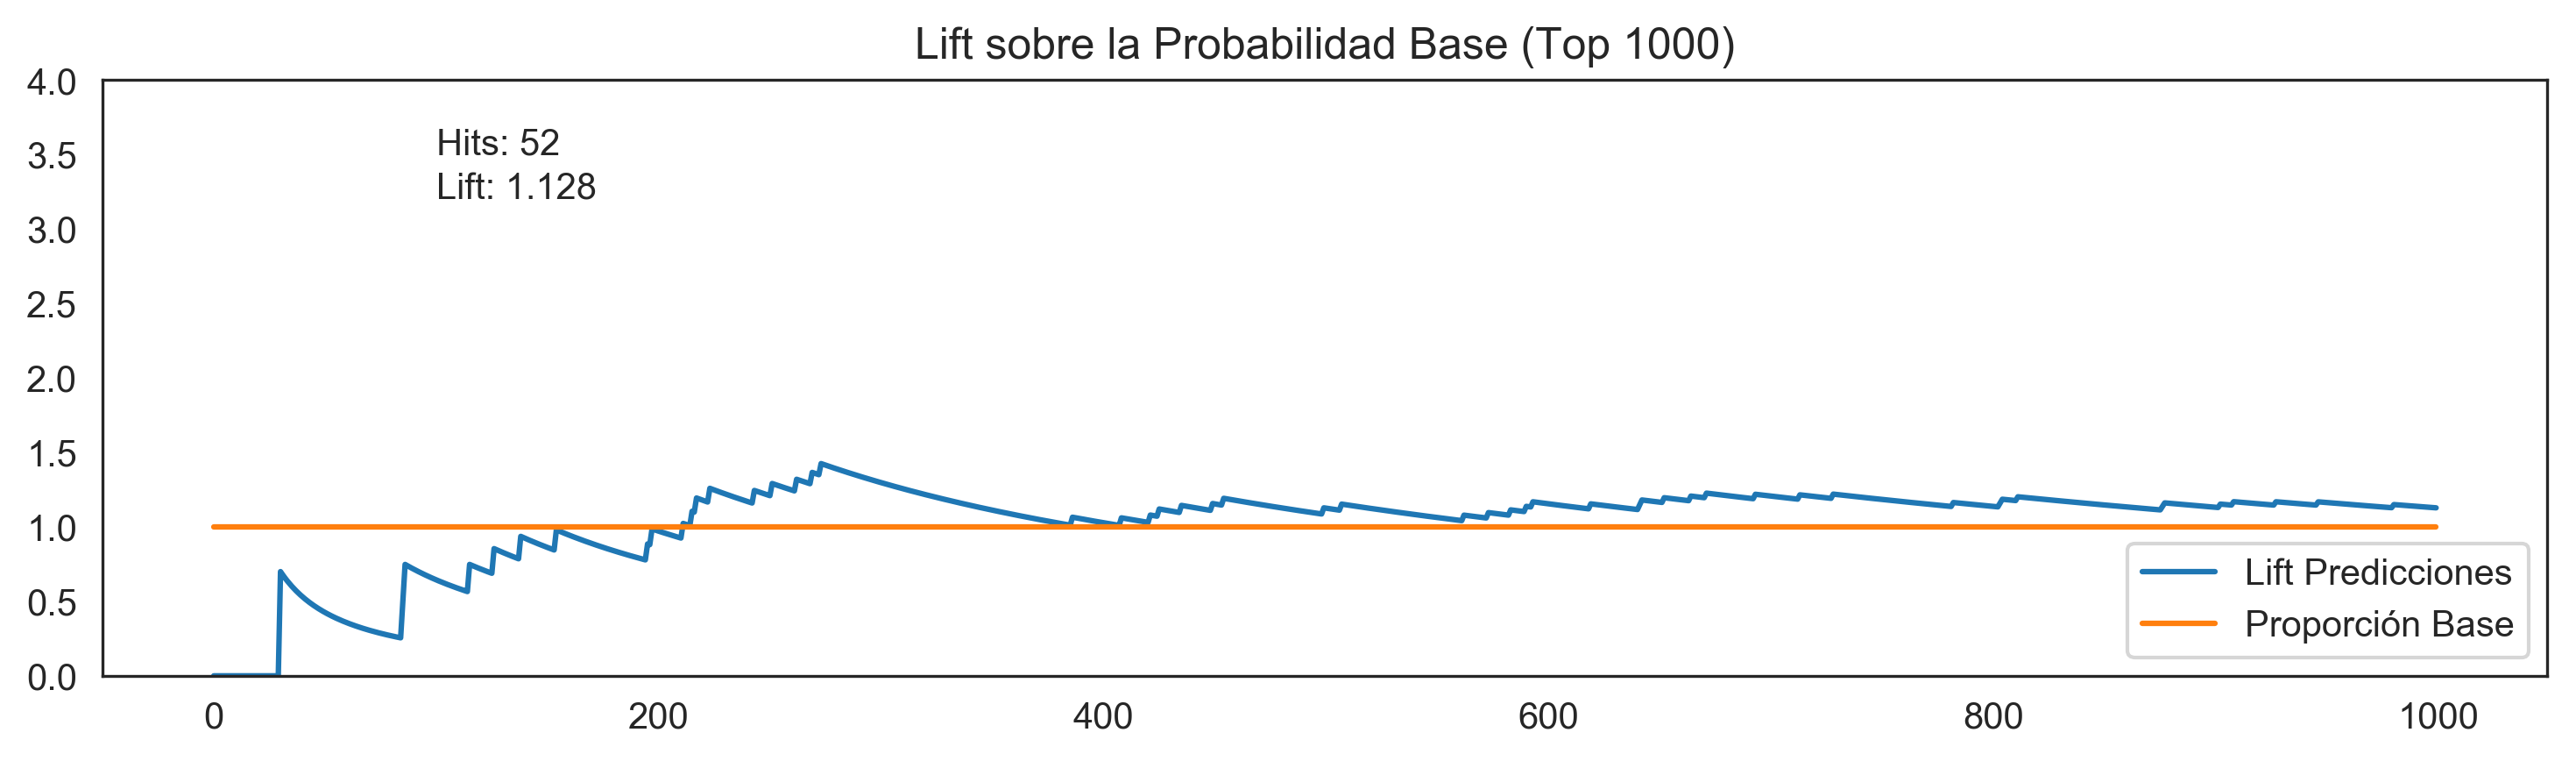

In [172]:
evaluate_predictions(Y_trn, probs['trn']['knn'], probs['val']['knn'], probs['tst']['knn'])

### Logistic Regression

In [18]:
# LR
lr_param_grid = {
 'C':np.logspace(-2, 0, 3),
 'l1_ratio':[0.25,0.5],
}
lr_mdl = GridSearchCV(LogisticRegression(random_state=42, max_iter=3000, penalty='elasticnet', solver='saga'),
                       lr_param_grid,
                       scoring=f05_scorer,
                       cv=5,
                       n_jobs=-1,
                       return_train_score=True, verbose=2)
lr_mdl.fit(X_trn, Y_trn)
pd.DataFrame(lr_mdl.cv_results_).sort_values(by=['rank_test_score'])\
[['params', 'mean_test_score', 'mean_train_score']].head()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    6.5s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.2s finished


params  mean_test_score  mean_train_score
4   {'C': 1.0, 'l1_ratio': 0.25}         0.300544          0.309742
5    {'C': 1.0, 'l1_ratio': 0.5}         0.299028          0.309656
2   {'C': 0.1, 'l1_ratio': 0.25}         0.296957          0.305958
3    {'C': 0.1, 'l1_ratio': 0.5}         0.293822          0.302476
0  {'C': 0.01, 'l1_ratio': 0.25}         0.264252          0.272325

In [ ]:
Y_pred = probs['trn']['lr'] = lr_mdl.predict_proba(X_trn)[:,1]
Y_pred_val = probs['val']['lr'] = lr_mdl.predict_proba(X_val)[:,1]
lr_mdl.fit(X_trn_c, Y_trn_c)
Y_pred_tst = probs['tst']['lr'] = lr_mdl.predict_proba(X_tst)[:,1]

F0.5 Score Train: 0.307
F0.5 Score Val: 0.098
F0.5 Score Test: 0.011


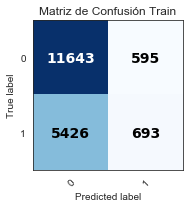

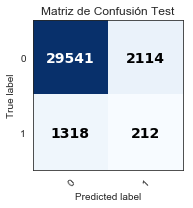

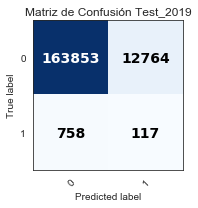

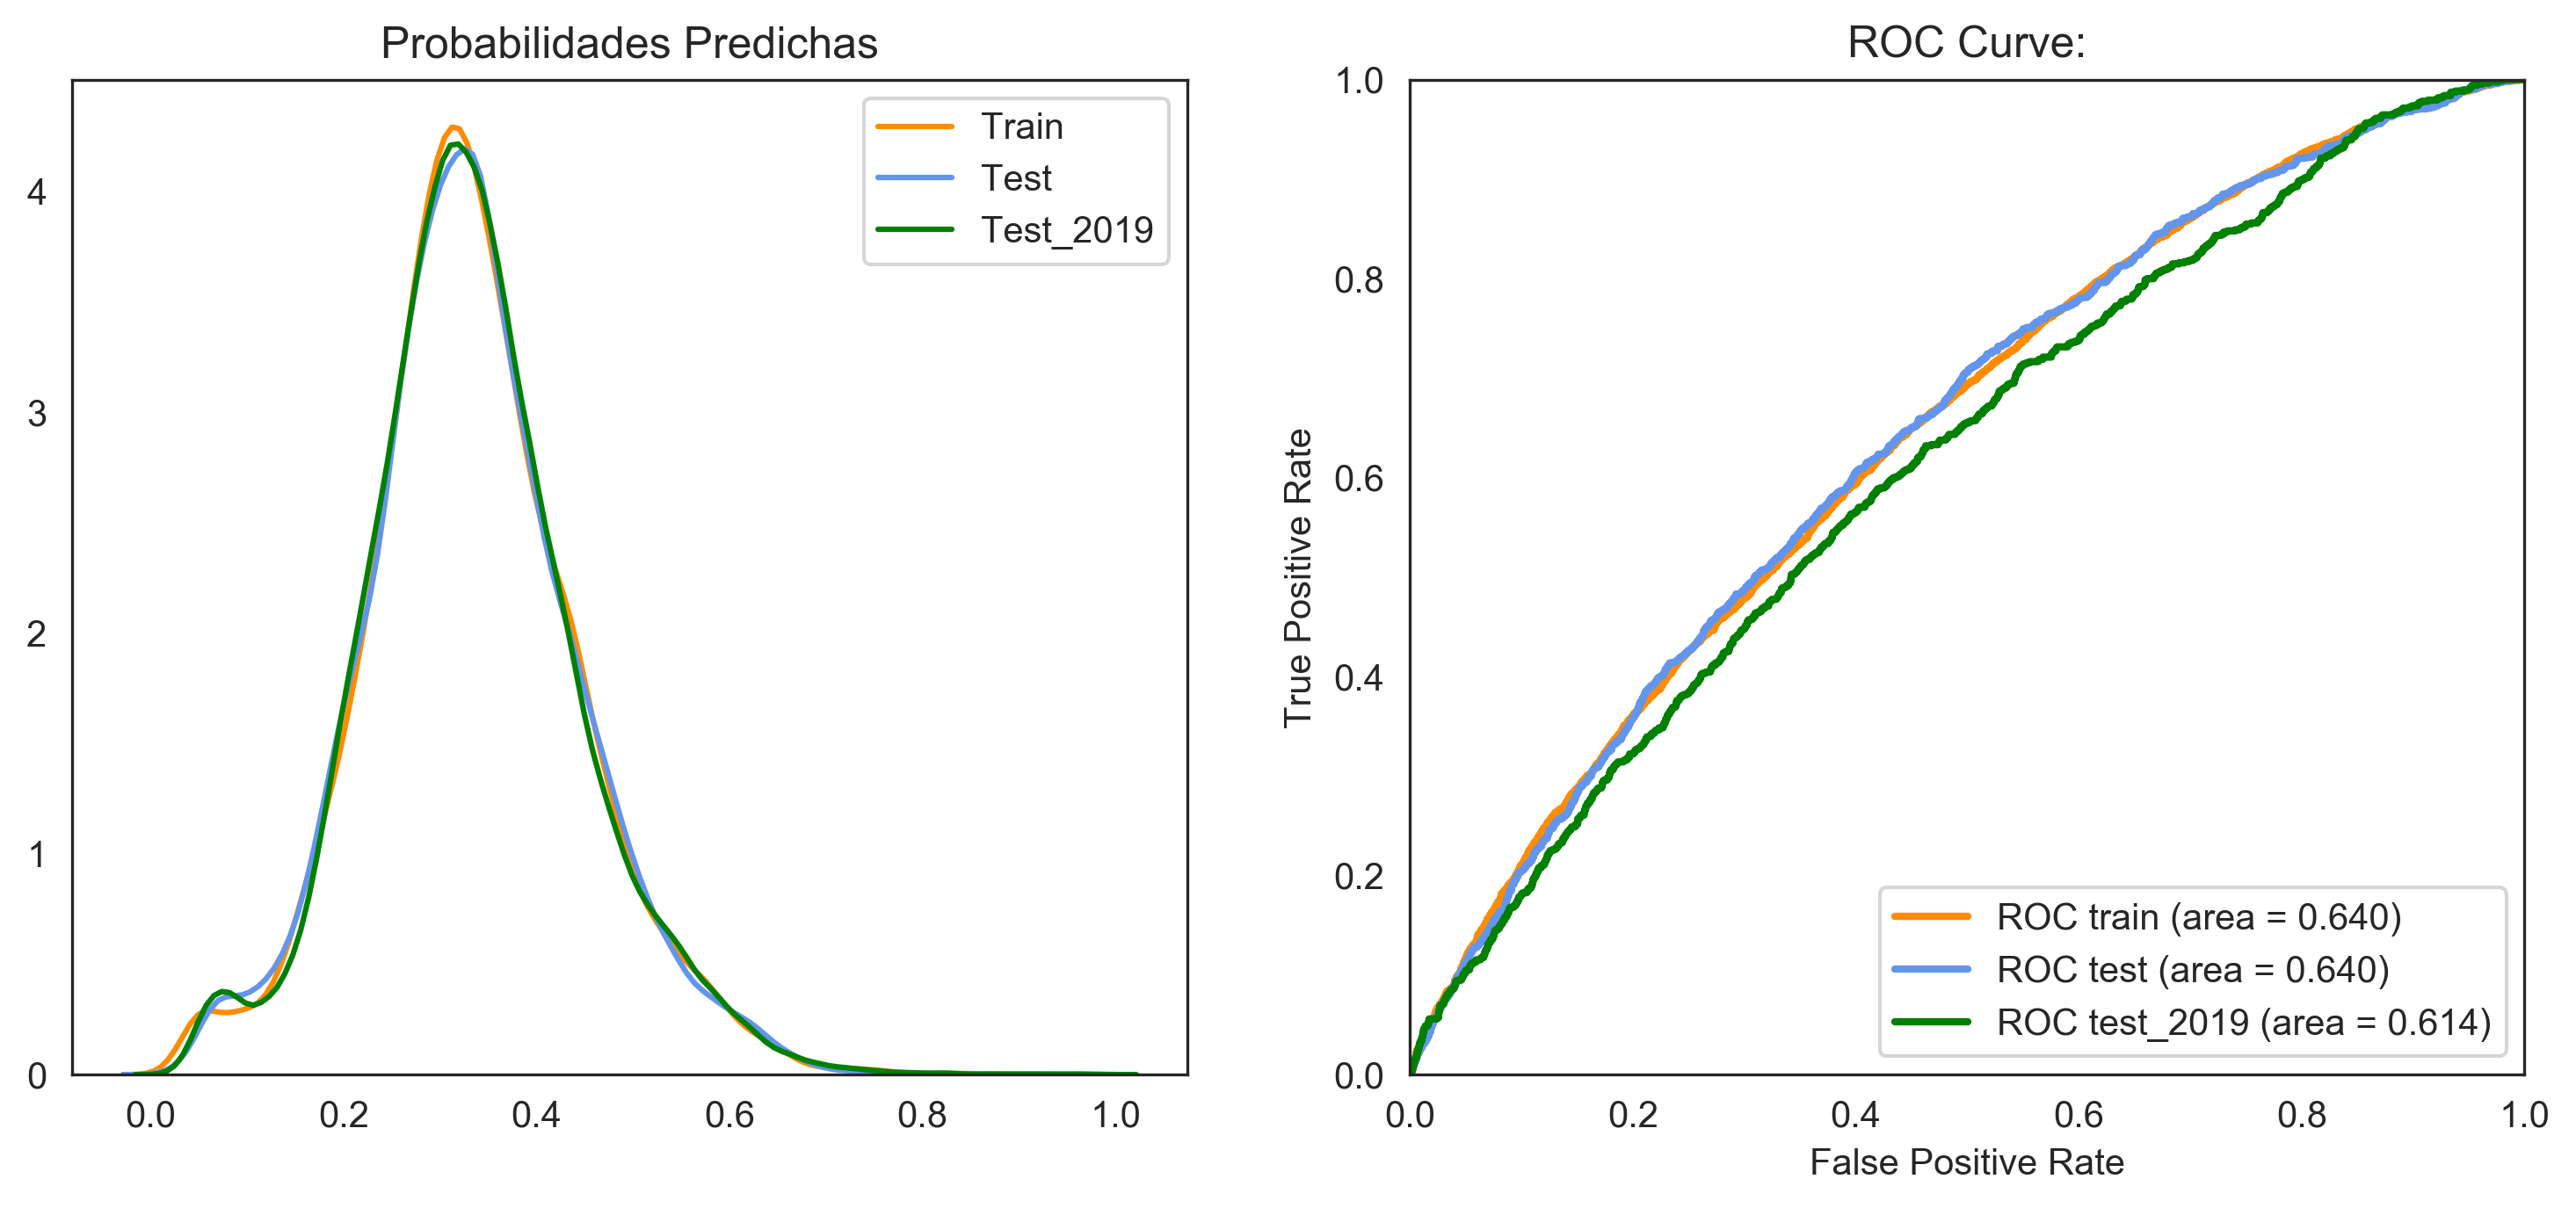

<Figure size 432x288 with 0 Axes>

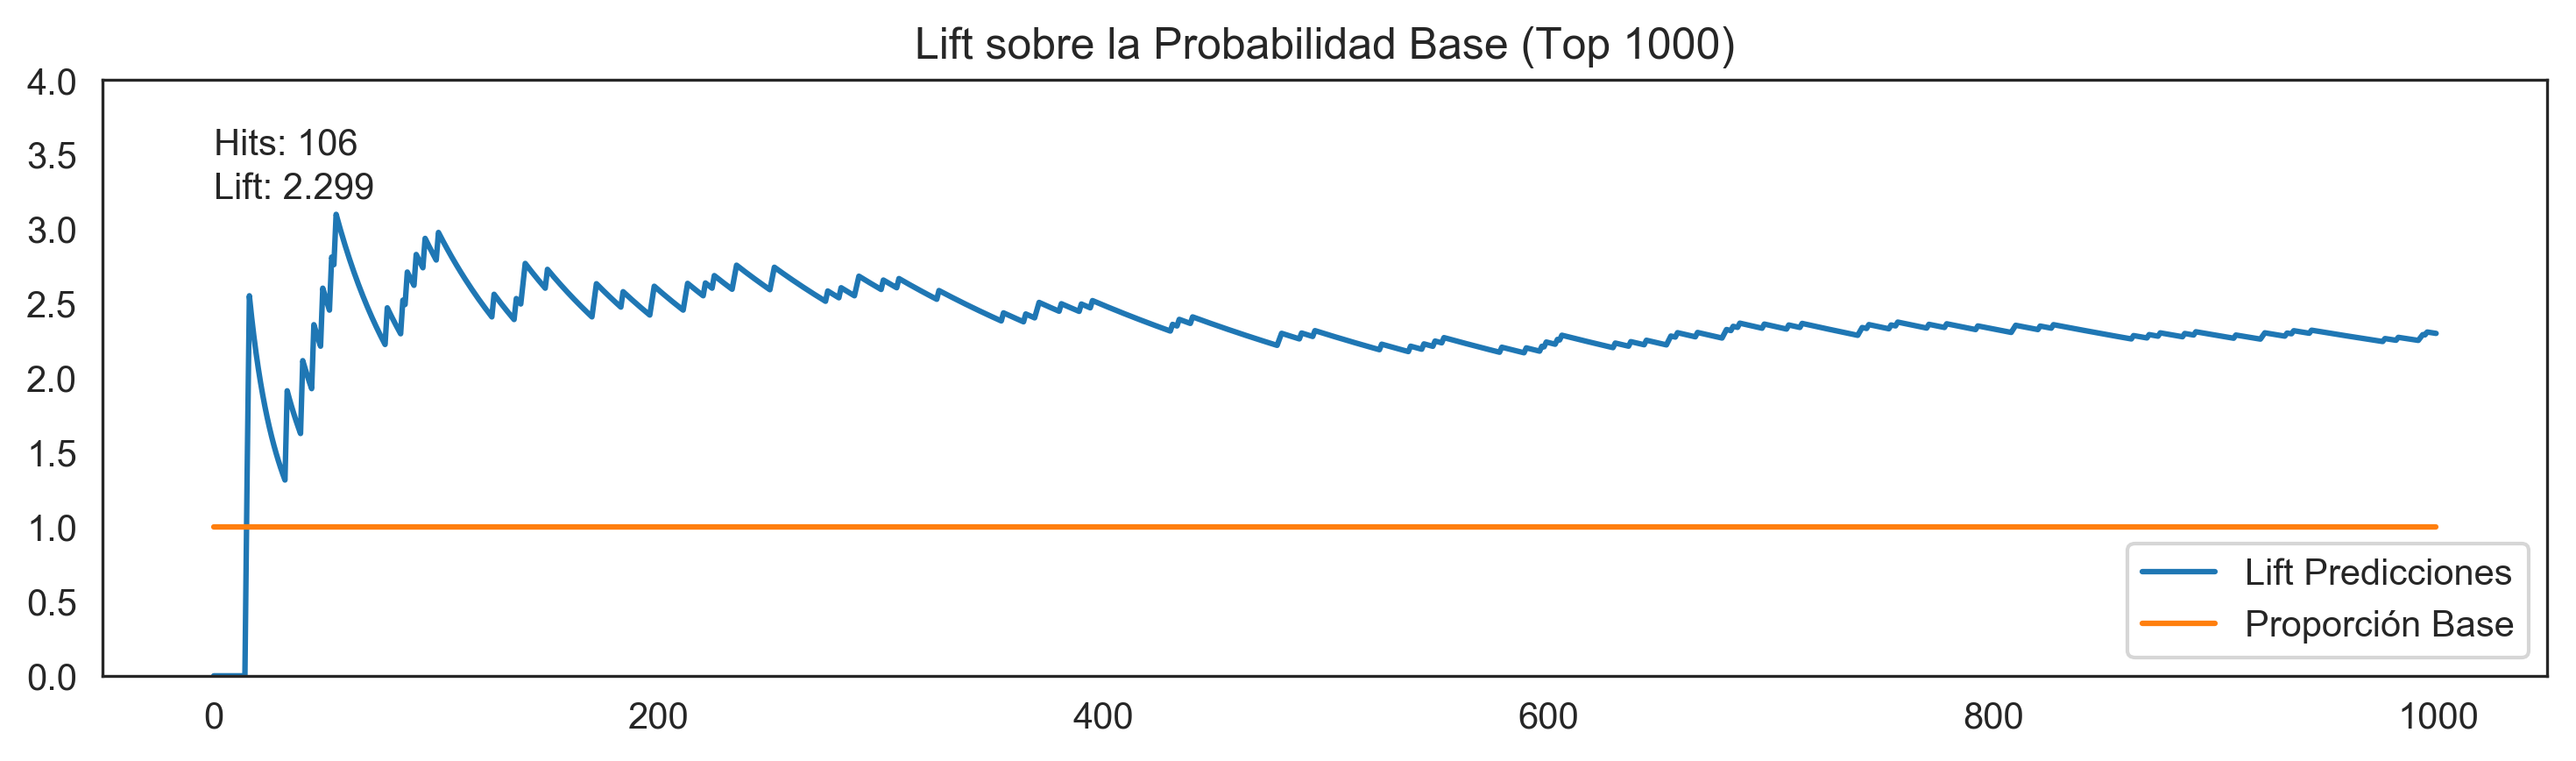

In [133]:
evaluate_predictions(Y_trn, probs['trn']['lr'], probs['val']['lr'], probs['tst']['lr'])

In [108]:
new_colnames= ['NUM_SIMU_ANTERIORES',
'ANTIGUEDAD_POLIZA',
'VAR_RIESGO',
'VAR_PRIMA',
'PROGRAMA_FIDELIZACION',
'VAR_ANTIGUEDAD_1',
'VAR_DESCUENTO_2',
'TIPO_CLIENTE.3',
'VAR_FREC_RENOV',
'VAR_PROMO_2',
'VAR_OCUPACION.2',
'FRECUENCIA_PAGO',
'VAR_SINIESTROS_2',
'VAR_CLIENTE_3.2',
'VAR_PROMO_3',
'VAR_PROMO_4',
'TIPO_CLIENTE.5',
'EDAD_CONDUCTOR',
'VAR_SINIESTROS',
'VAR_DENTAL',
'VAR_SALUD',
'VAR_VEHICULO_1',
'VAR_PROMO_5',
'VAR_PROMO_6',
'VAR_GASTO_MEDIO_1',
'VAR_SOCIOECONOMICA_2',
'VAR_SOCIOECONOMICA_3',
'TARGET',
'CLUST_0',
'CLUST_1',
'CLUST_2',
'CLUST_3',
'CLUST_4',
'CLUST_5',
'CLUST_6']

In [109]:
lr_trn=trn.copy()
lr_trn.columns=new_colnames

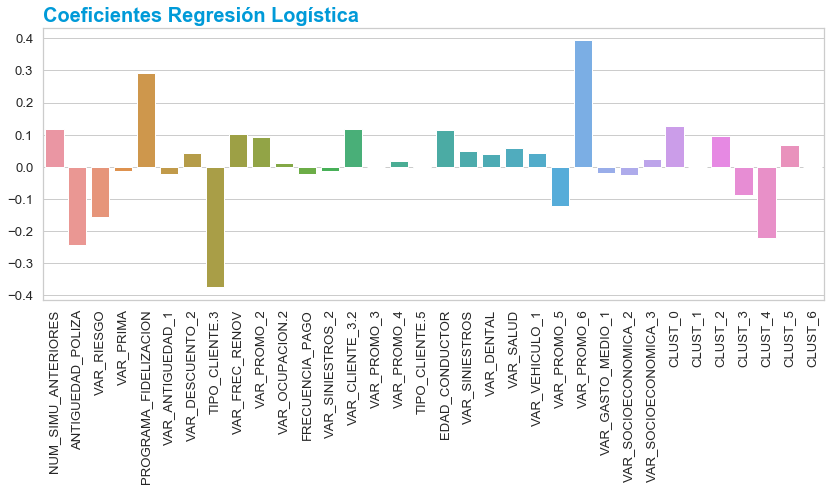

In [110]:
plt.figure(figsize=(14,5))
sns.set_style("whitegrid")
plot = sns.barplot(x=list(lr_trn.copy().drop(['TARGET'], axis=1).columns),
                   y=lr_mdl.best_estimator_.coef_.reshape(X_trn.shape[1]))
plot.set_title('Coeficientes Regresión Logística', fontdict={'family': 'sans',
        'color':  "#009ad8",
        'weight': 'bold',
        'size': 20},  loc='left')
plot.set_xticklabels(list(lr_trn.copy().drop(['TARGET'], axis=1).columns), rotation = 90)
plt.show()

### Decision Tree

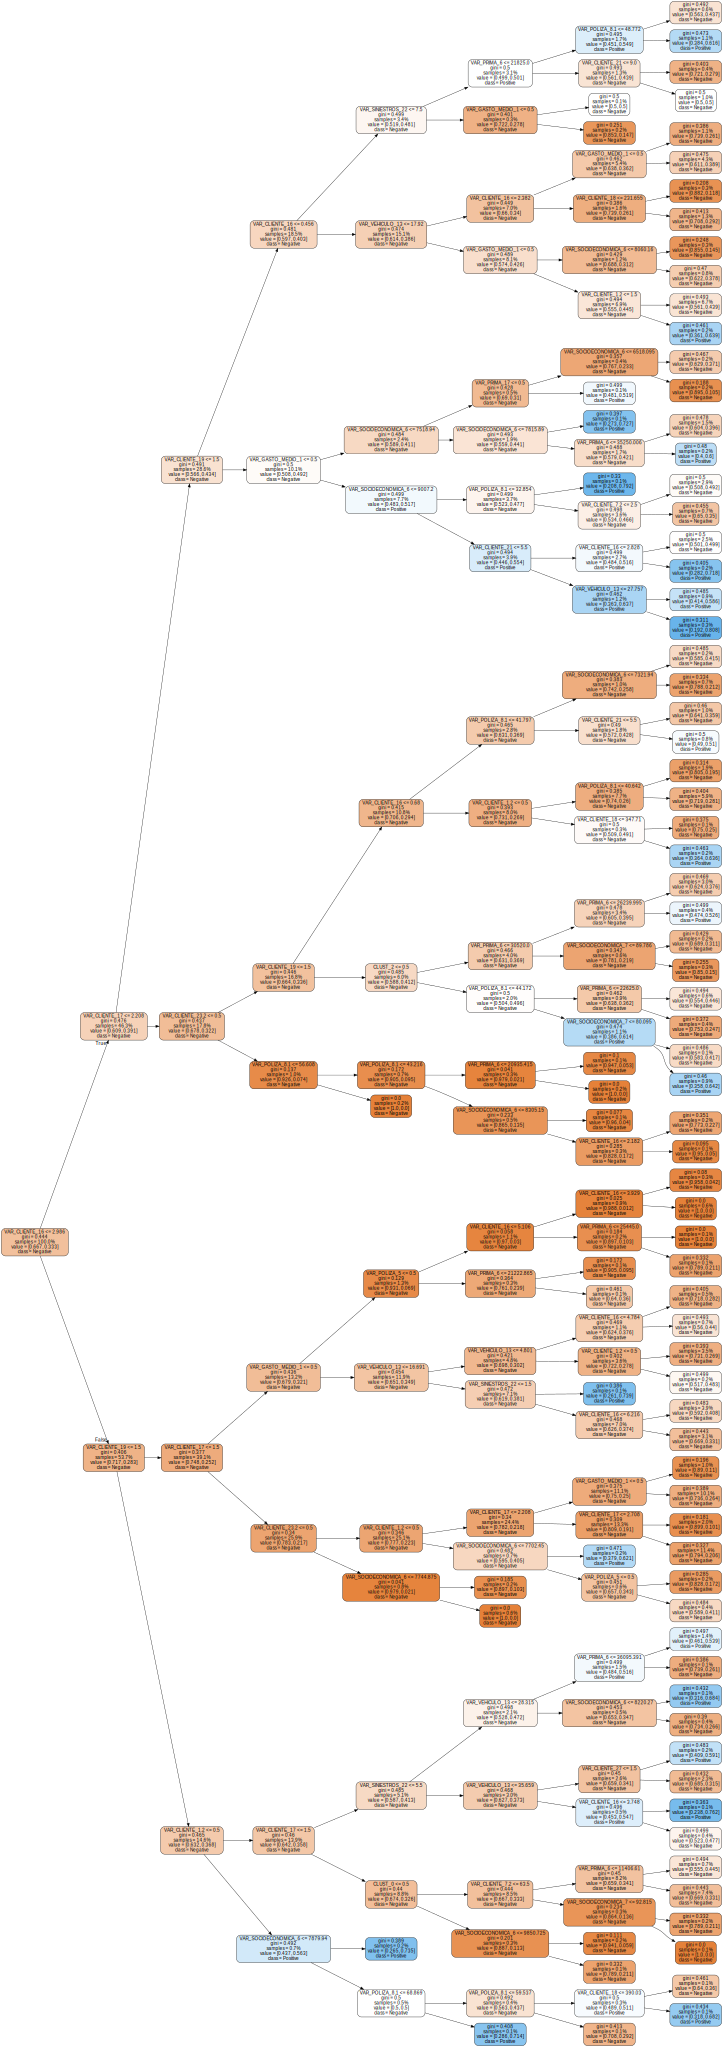

In [160]:
# DT
# Para mayor interpretabilidad del arbol
dt_mdl = DecisionTreeClassifier(max_depth=7, random_state=42, min_samples_leaf=0.001)
dt_mdl.fit(X_trn_unscaled, Y_trn)

# Para graficar el árbol
plottree(dt_mdl, features_names=lr_trn.copy().drop(['TARGET'], axis=1).columns, class_names=["Negative", "Positive"])

In [161]:
Y_pred = probs['trn']['dt'] = dt_mdl.predict_proba(X_trn_unscaled)[:,1]
Y_pred_val = probs['val']['dt'] = dt_mdl.predict_proba(X_val_unscaled)[:,1]
dt_mdl.fit(X_trn_c_unscaled,Y_trn_c)
Y_pred_tst = probs['tst']['dt'] = dt_mdl.predict_proba(X_tst_unscaled)[:,1]

F0.5 Score Train: 0.379
F0.5 Score Val: 0.090
F0.5 Score Test: 0.011


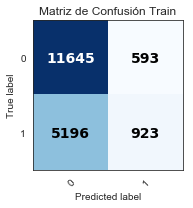

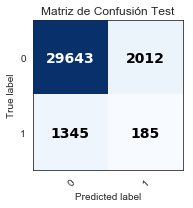

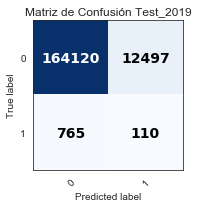

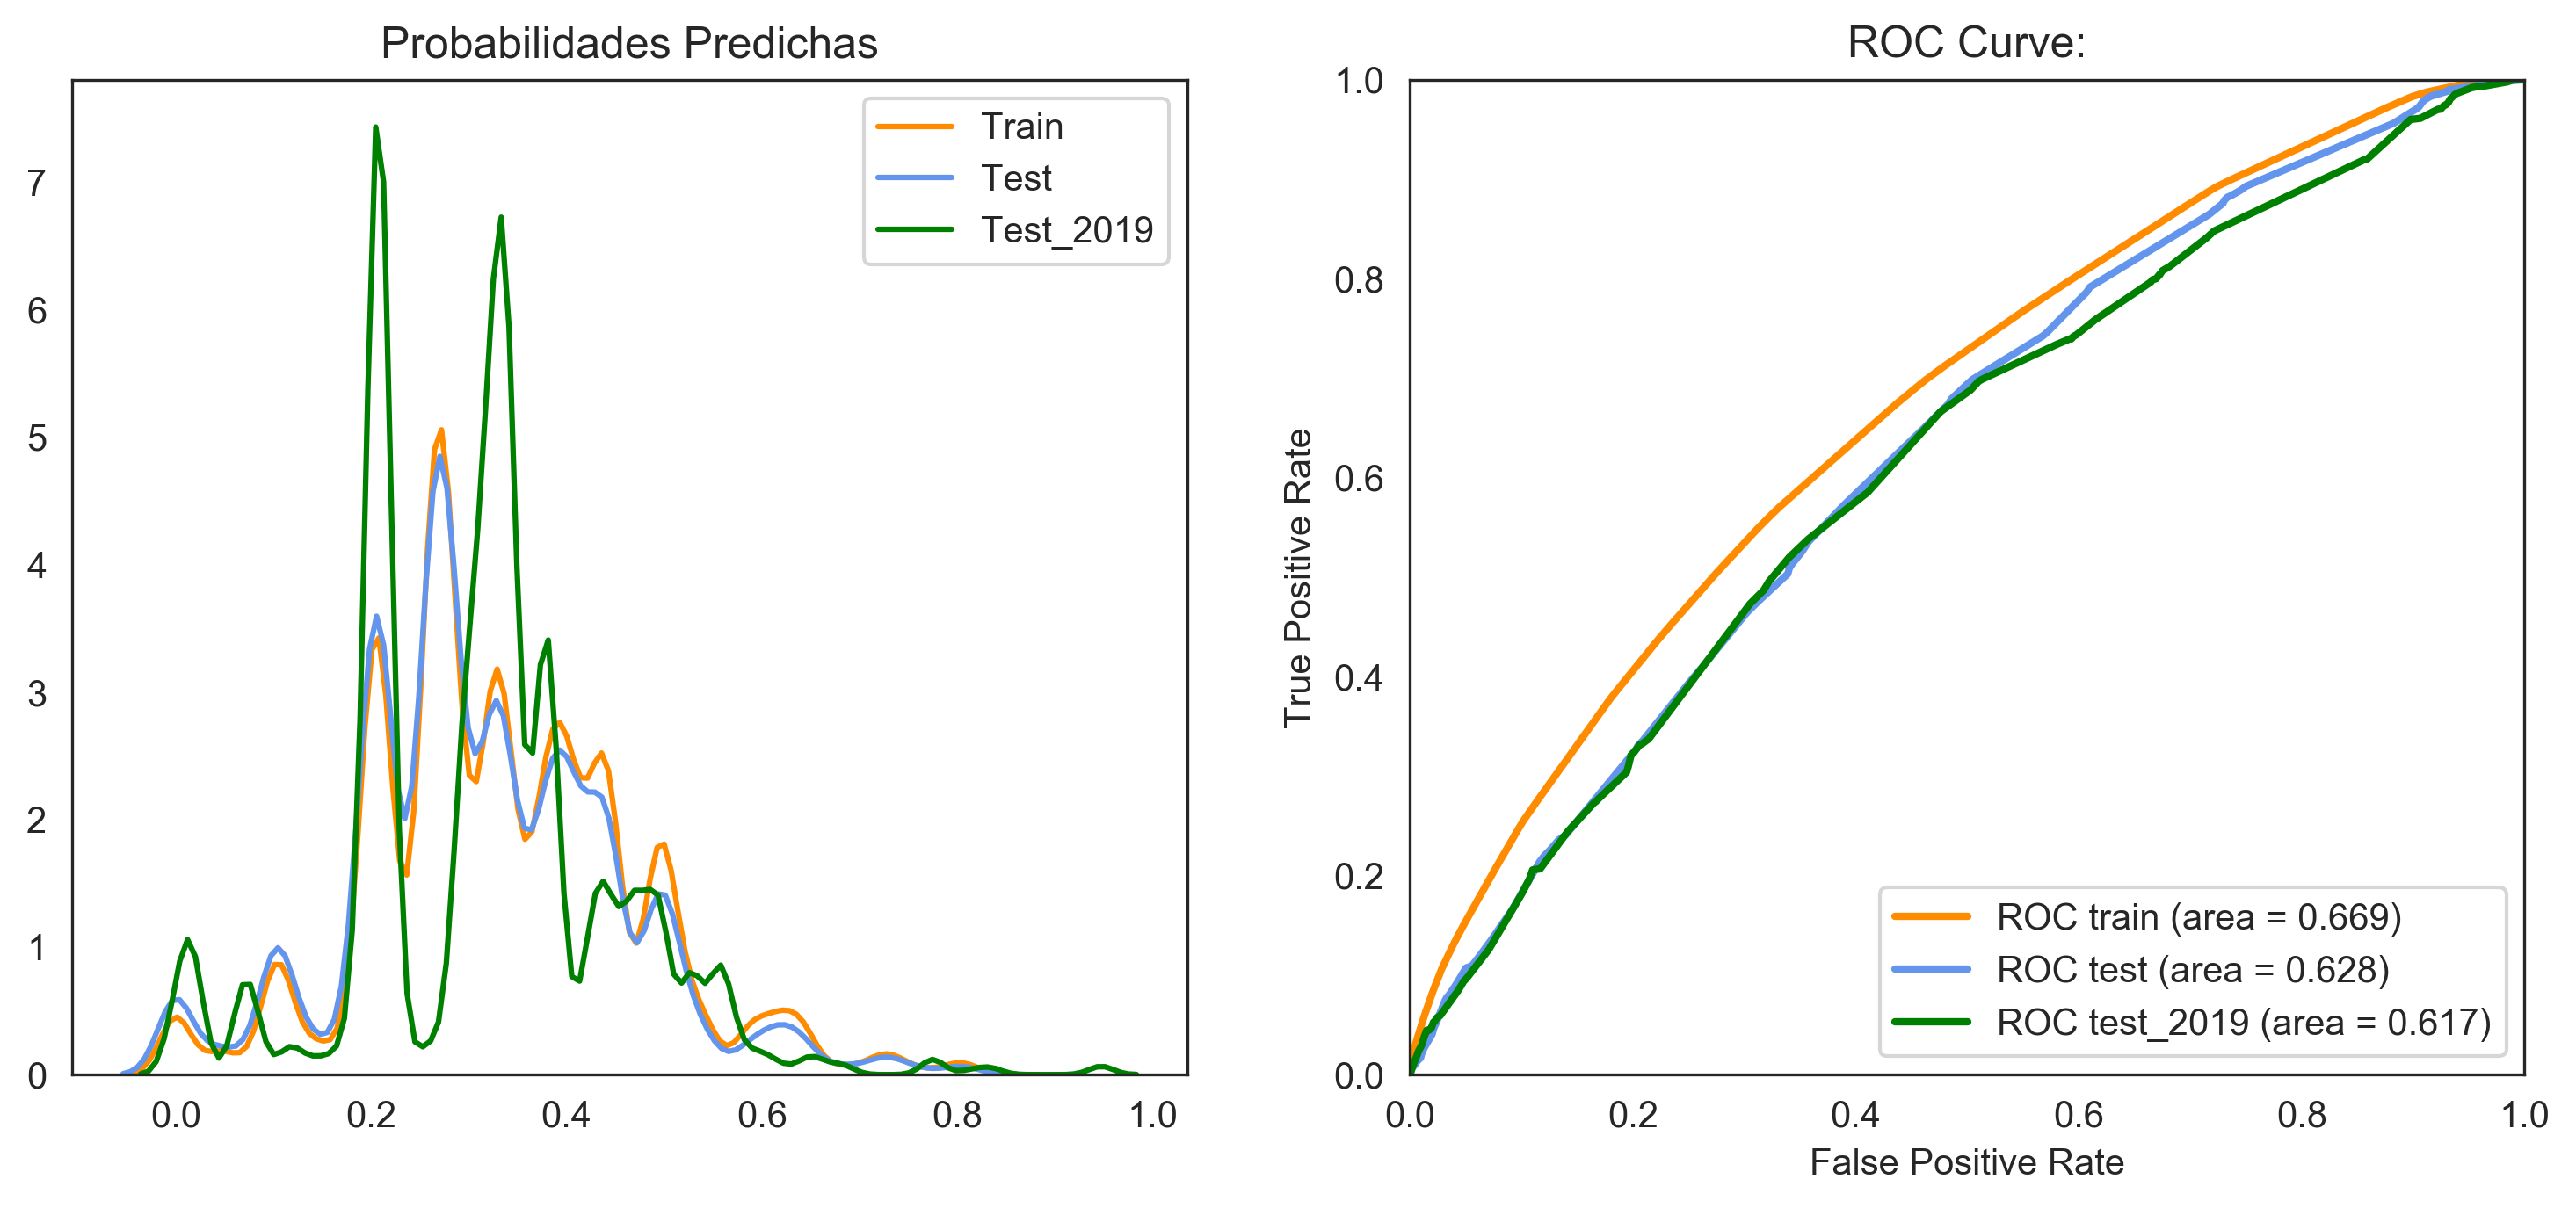

<Figure size 432x288 with 0 Axes>

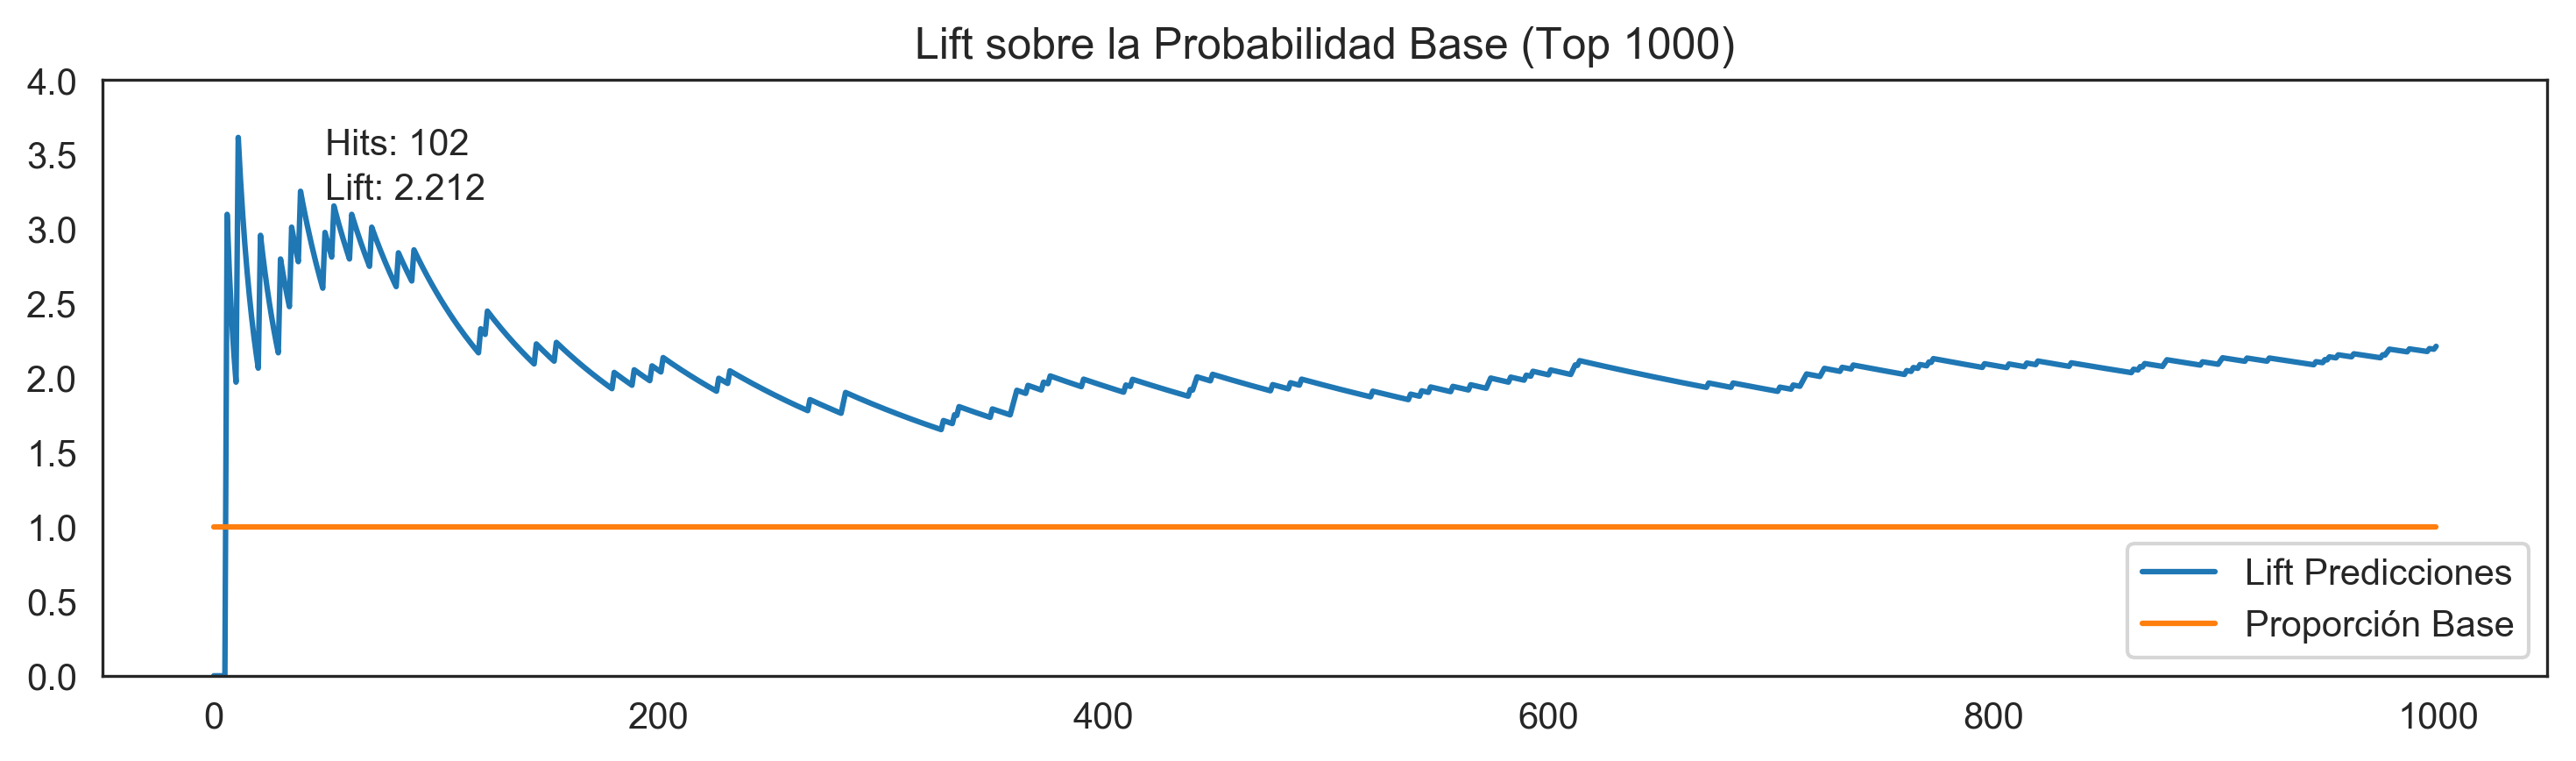

In [165]:
evaluate_predictions(Y_trn, probs['trn']['dt'],  probs['val']['dt'] , probs['tst']['dt'])

### Support Vector Classifier

In [23]:
# SVC
svc_param_grid = {
 'C':np.logspace(-2, 2, 5),
 'gamma':np.logspace(-2, 2, 5),
 'kernel': ['rbf']
}
svc_mdl = GridSearchCV(SVC(max_iter=3000, probability = True, cache_size=800),
                       svc_param_grid,
                       scoring=f05_scorer,
                       cv=5,
                       n_jobs=-1,
                       return_train_score=True)
svc_mdl.fit(X_trn, Y_trn)
pd.DataFrame(svc_mdl.cv_results_).sort_values(by=['rank_test_score'])\
[['params', 'mean_test_score', 'mean_train_score']].head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


params  mean_test_score  \
4   {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'}         0.395288   
14   {'C': 1.0, 'gamma': 100.0, 'kernel': 'rbf'}         0.394995   
9    {'C': 0.1, 'gamma': 100.0, 'kernel': 'rbf'}         0.394993   
5     {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}         0.392946   
1     {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}         0.389249   

    mean_train_score  
4           0.570521  
14          0.570791  
9           0.570754  
5           0.393548  
1           0.481521

In [47]:
svc_mdl=SVC(max_iter=30000, probability = True, cache_size=1024, C=0.1, gamma=0.01, kernel='rbf')
svc_mdl.fit(X_trn, Y_trn)

SVC(C=0.1, cache_size=1024, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=30000, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
Y_pred = probs['trn']['svc'] = svc_mdl.predict_proba(X_trn)[:,1]
Y_pred_val = probs['val']['svc'] = svc_mdl.predict_proba(X_val)[:,1]
#svc_mdl.best_estimator_.fit(X_trn_c, Y_trn_c)
svc_mdl.fit(X_trn_c, Y_trn_c)
Y_pred_tst = probs['tst']['svc'] = svc_mdl.predict_proba(X_tst)[:,1]

F0.5 Score Train: 0.140
F0.5 Score Val: 0.074
F0.5 Score Test: 0.016


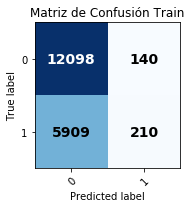

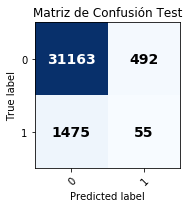

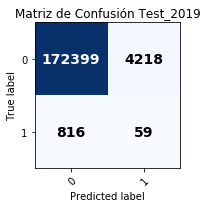

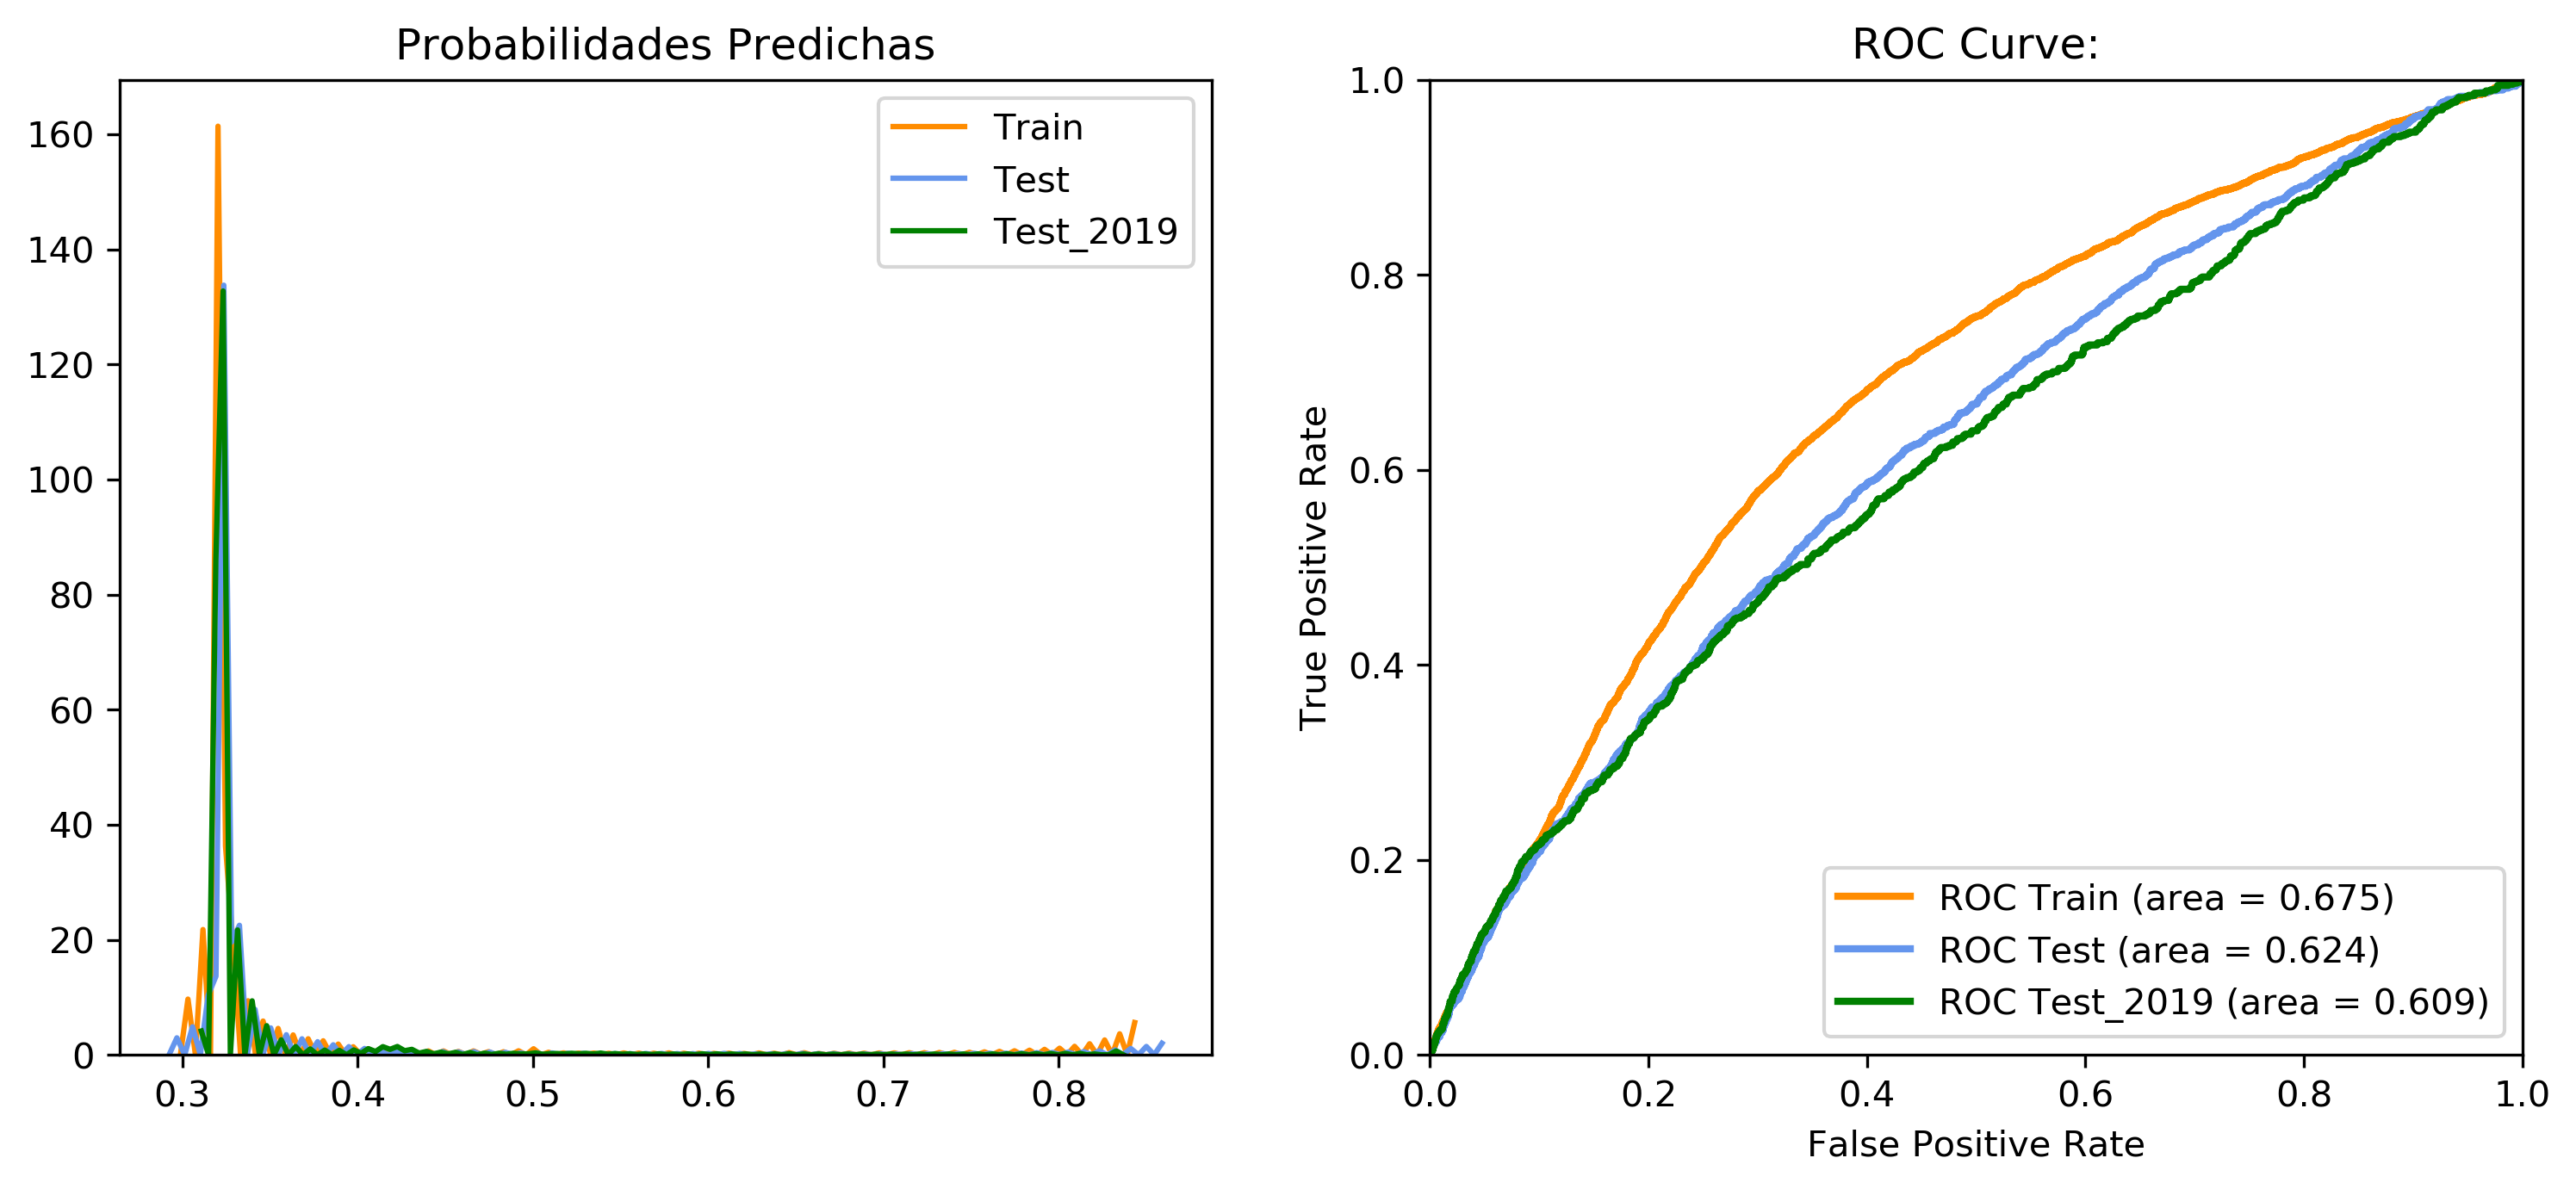

<Figure size 432x288 with 0 Axes>

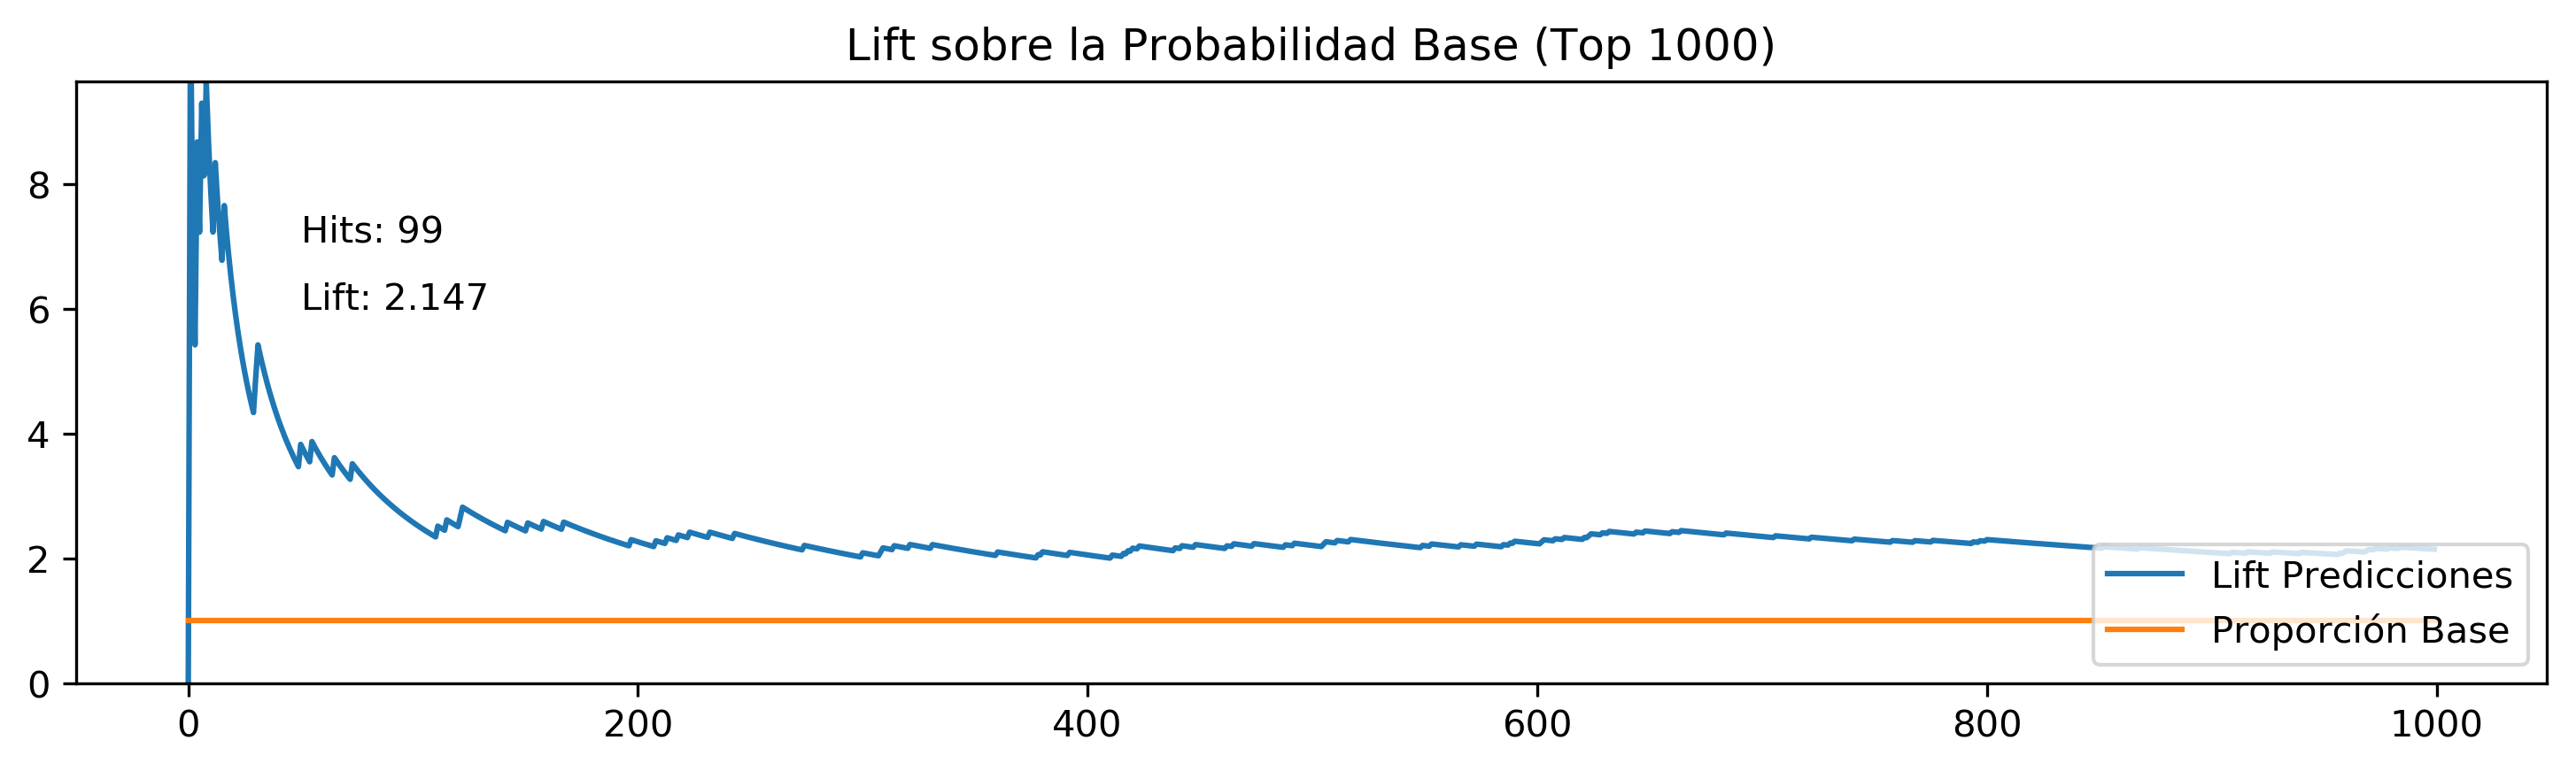

In [37]:
evaluate_predictions(Y_trn, probs['trn']['svc'], probs['val']['svc'], probs['tst']['svc'], lift_label_y=6)

### Random Forest

In [185]:
# RF
rf_param_grid = {
 'n_estimators':[30,50,100],
 'max_depth':[3,5,7],
 'max_features':['sqrt', 'log2', None]
}
rf_mdl = GridSearchCV(RandomForestClassifier(random_state=42),
                       rf_param_grid,
                       scoring=f05_scorer,
                       cv=5,
                       n_jobs=-1,
                       return_train_score=True)
rf_mdl.fit(X_trn, Y_trn)
pd.DataFrame(rf_mdl.cv_results_).sort_values(by=['rank_test_score'])\
[['params', 'mean_test_score', 'mean_train_score']].head()

params  mean_test_score  \
24  {'max_depth': 7, 'max_features': None, 'n_esti...         0.245884   
25  {'max_depth': 7, 'max_features': None, 'n_esti...         0.245433   
26  {'max_depth': 7, 'max_features': None, 'n_esti...         0.242288   
15  {'max_depth': 5, 'max_features': None, 'n_esti...         0.163943   
17  {'max_depth': 5, 'max_features': None, 'n_esti...         0.159872   

    mean_train_score  
24          0.431382  
25          0.429691  
26          0.434690  
15          0.220125  
17          0.222443

In [187]:
Y_pred = probs['trn']['rf'] = rf_mdl.predict_proba(X_trn)[:,1]
Y_pred_val = probs['val']['rf'] = rf_mdl.predict_proba(X_val)[:,1]
rf_mdl.best_estimator_.fit(X_trn_c, Y_trn_c)
Y_pred_tst = probs['tst']['rf'] = rf_mdl.predict_proba(X_tst)[:,1]

F0.5 Score Train: 0.414
F0.5 Score Val: 0.103
F0.5 Score Test: 0.013


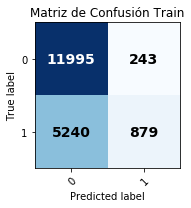

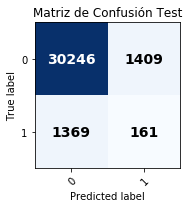

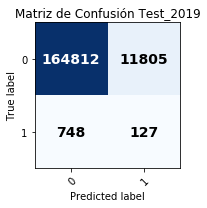

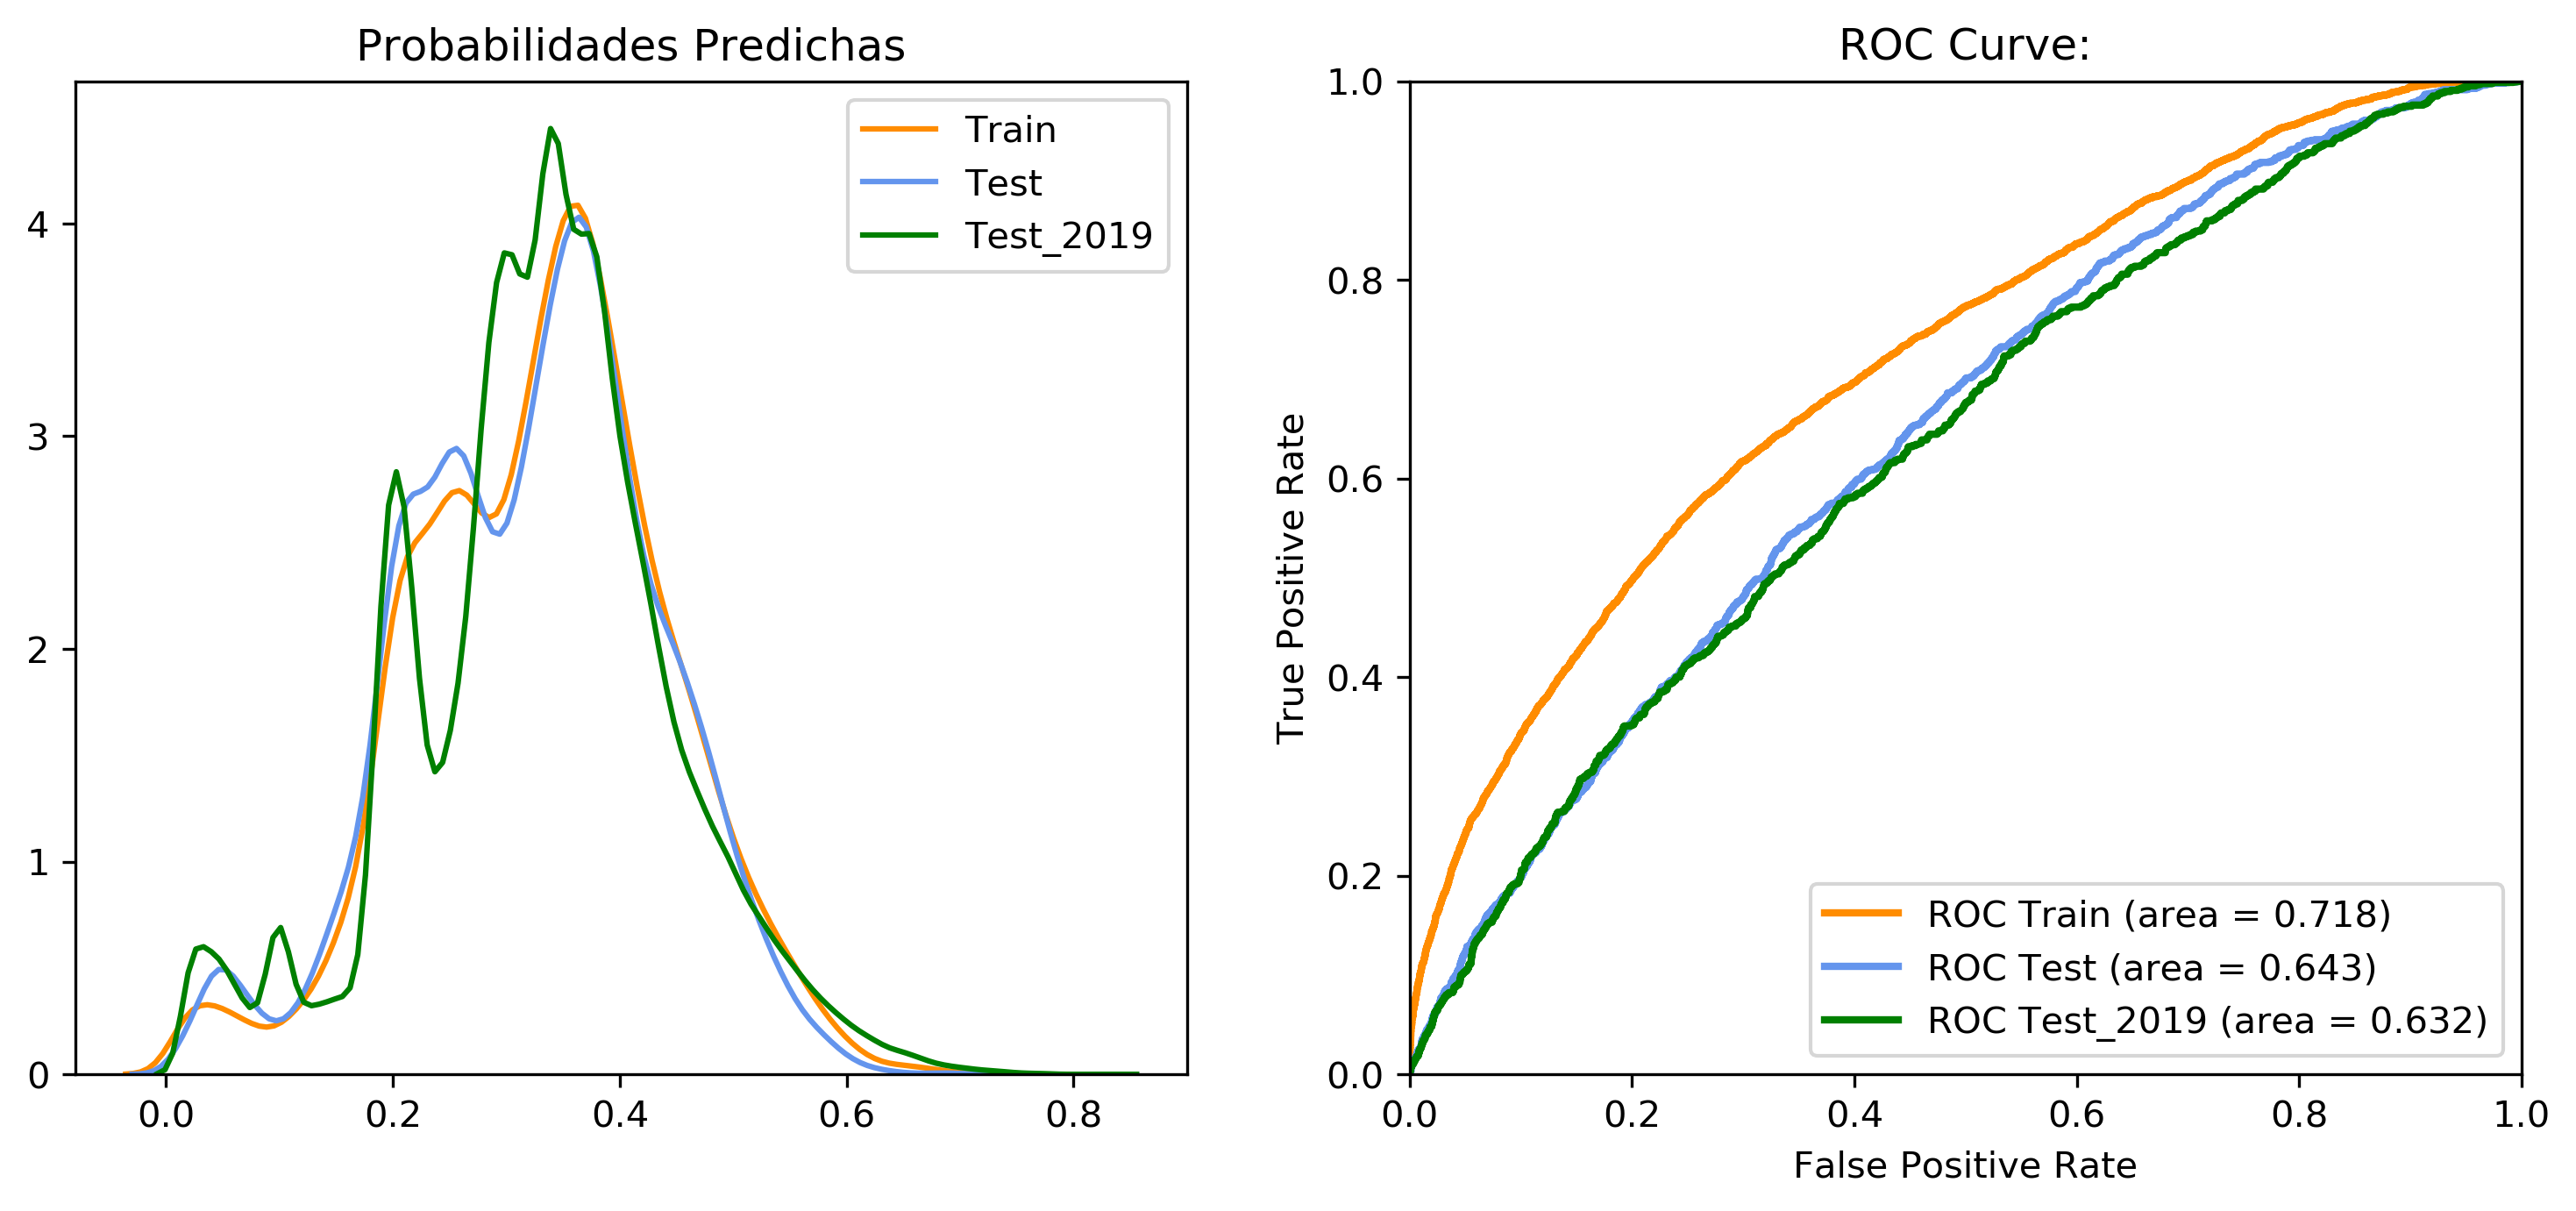

<Figure size 432x288 with 0 Axes>

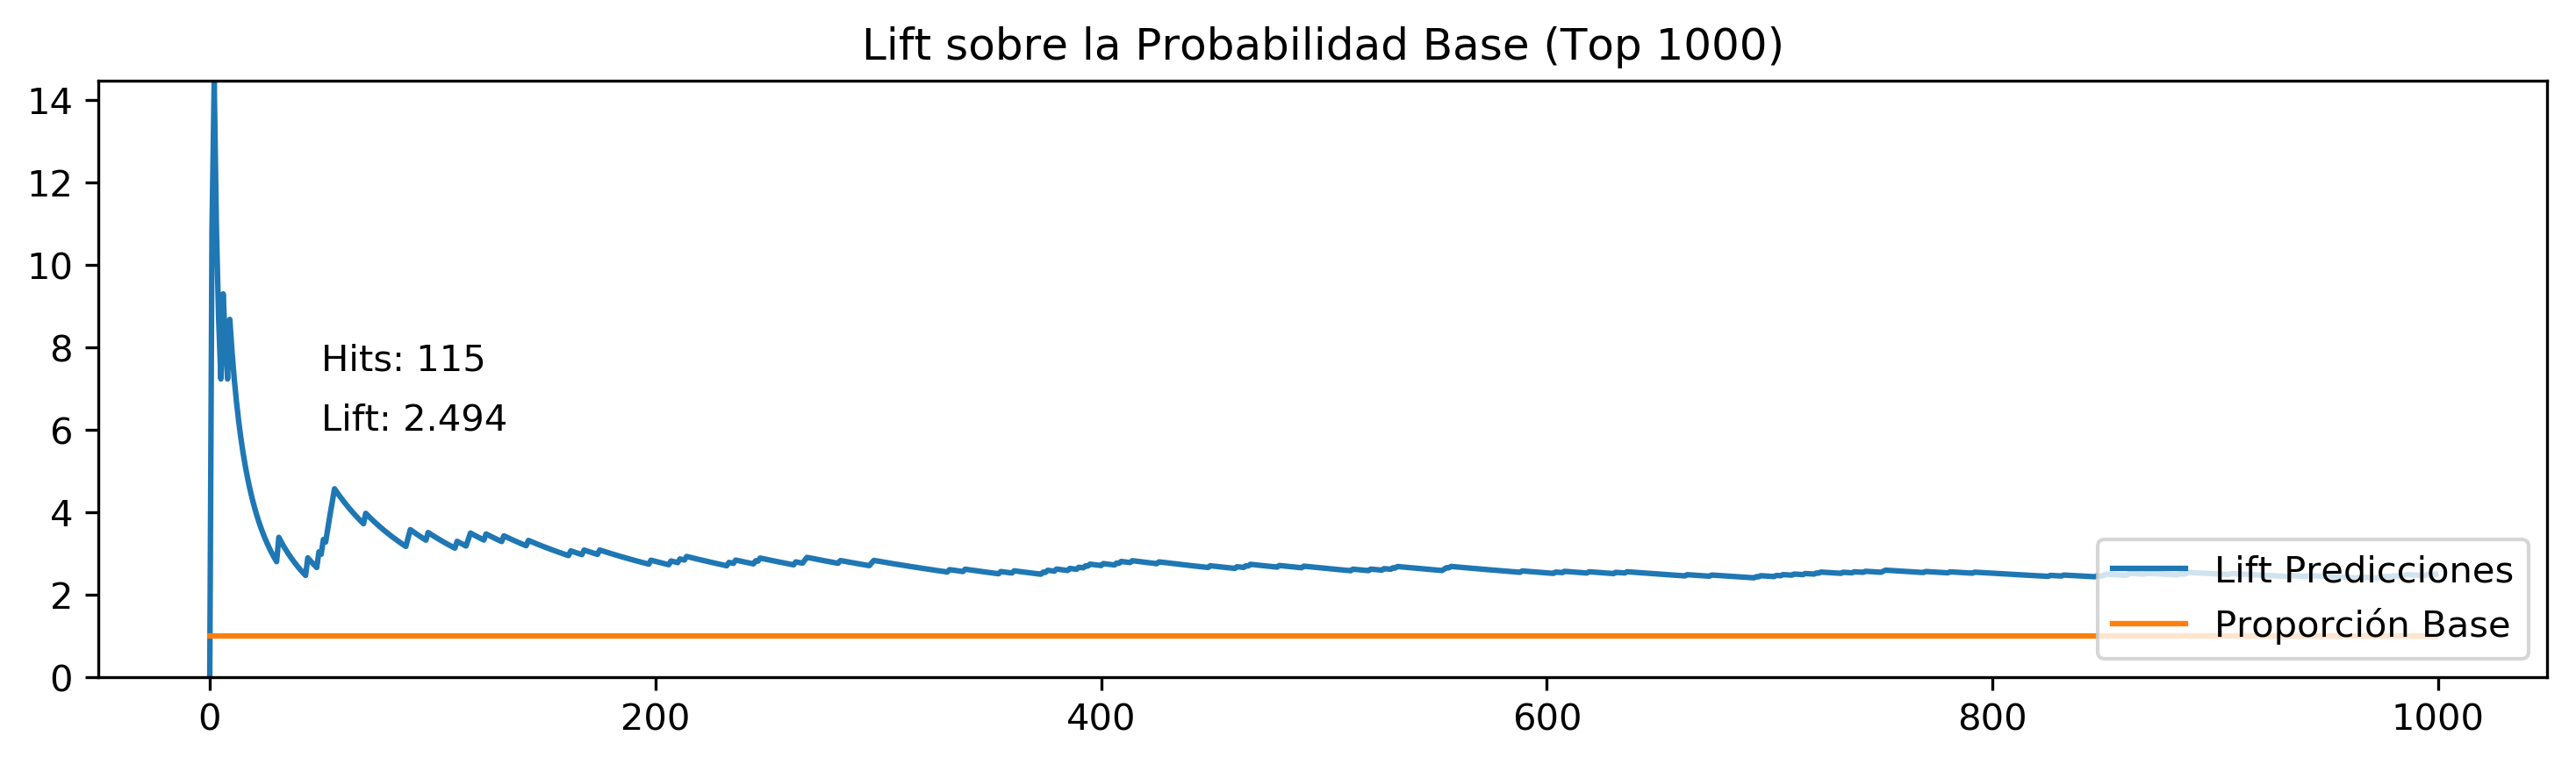

In [32]:
evaluate_predictions(Y_trn, probs['trn']['rf'], probs['val']['rf'], probs['tst']['rf'], lift_label_y=6)

### XGBoost

In [ ]:
xgb_mdl = xgb.XGBClassifier(random_state=42, nthread=12, max_depth=4, n_estimators=200, learning_rate=0.1)
xgb_mdl.fit(X_trn, Y_trn)
Y_pred = probs['trn']['xgb'] = xgb_mdl.predict_proba(X_trn)[:,1]
Y_pred_val = probs['val']['xgb'] = xgb_mdl.predict_proba(X_val)[:,1]
xgb_mdl.fit(X_trn_c, Y_trn_c)
Y_pred_tst = probs['tst']['xgb'] = xgb_mdl.predict_proba(X_tst)[:,1]

F0.5 Score Train: 0.502
F0.5 Score Val: 0.103
F0.5 Score Test: 0.012


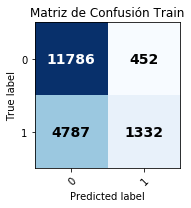

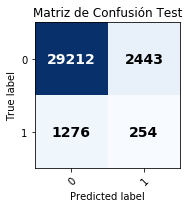

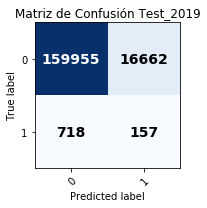

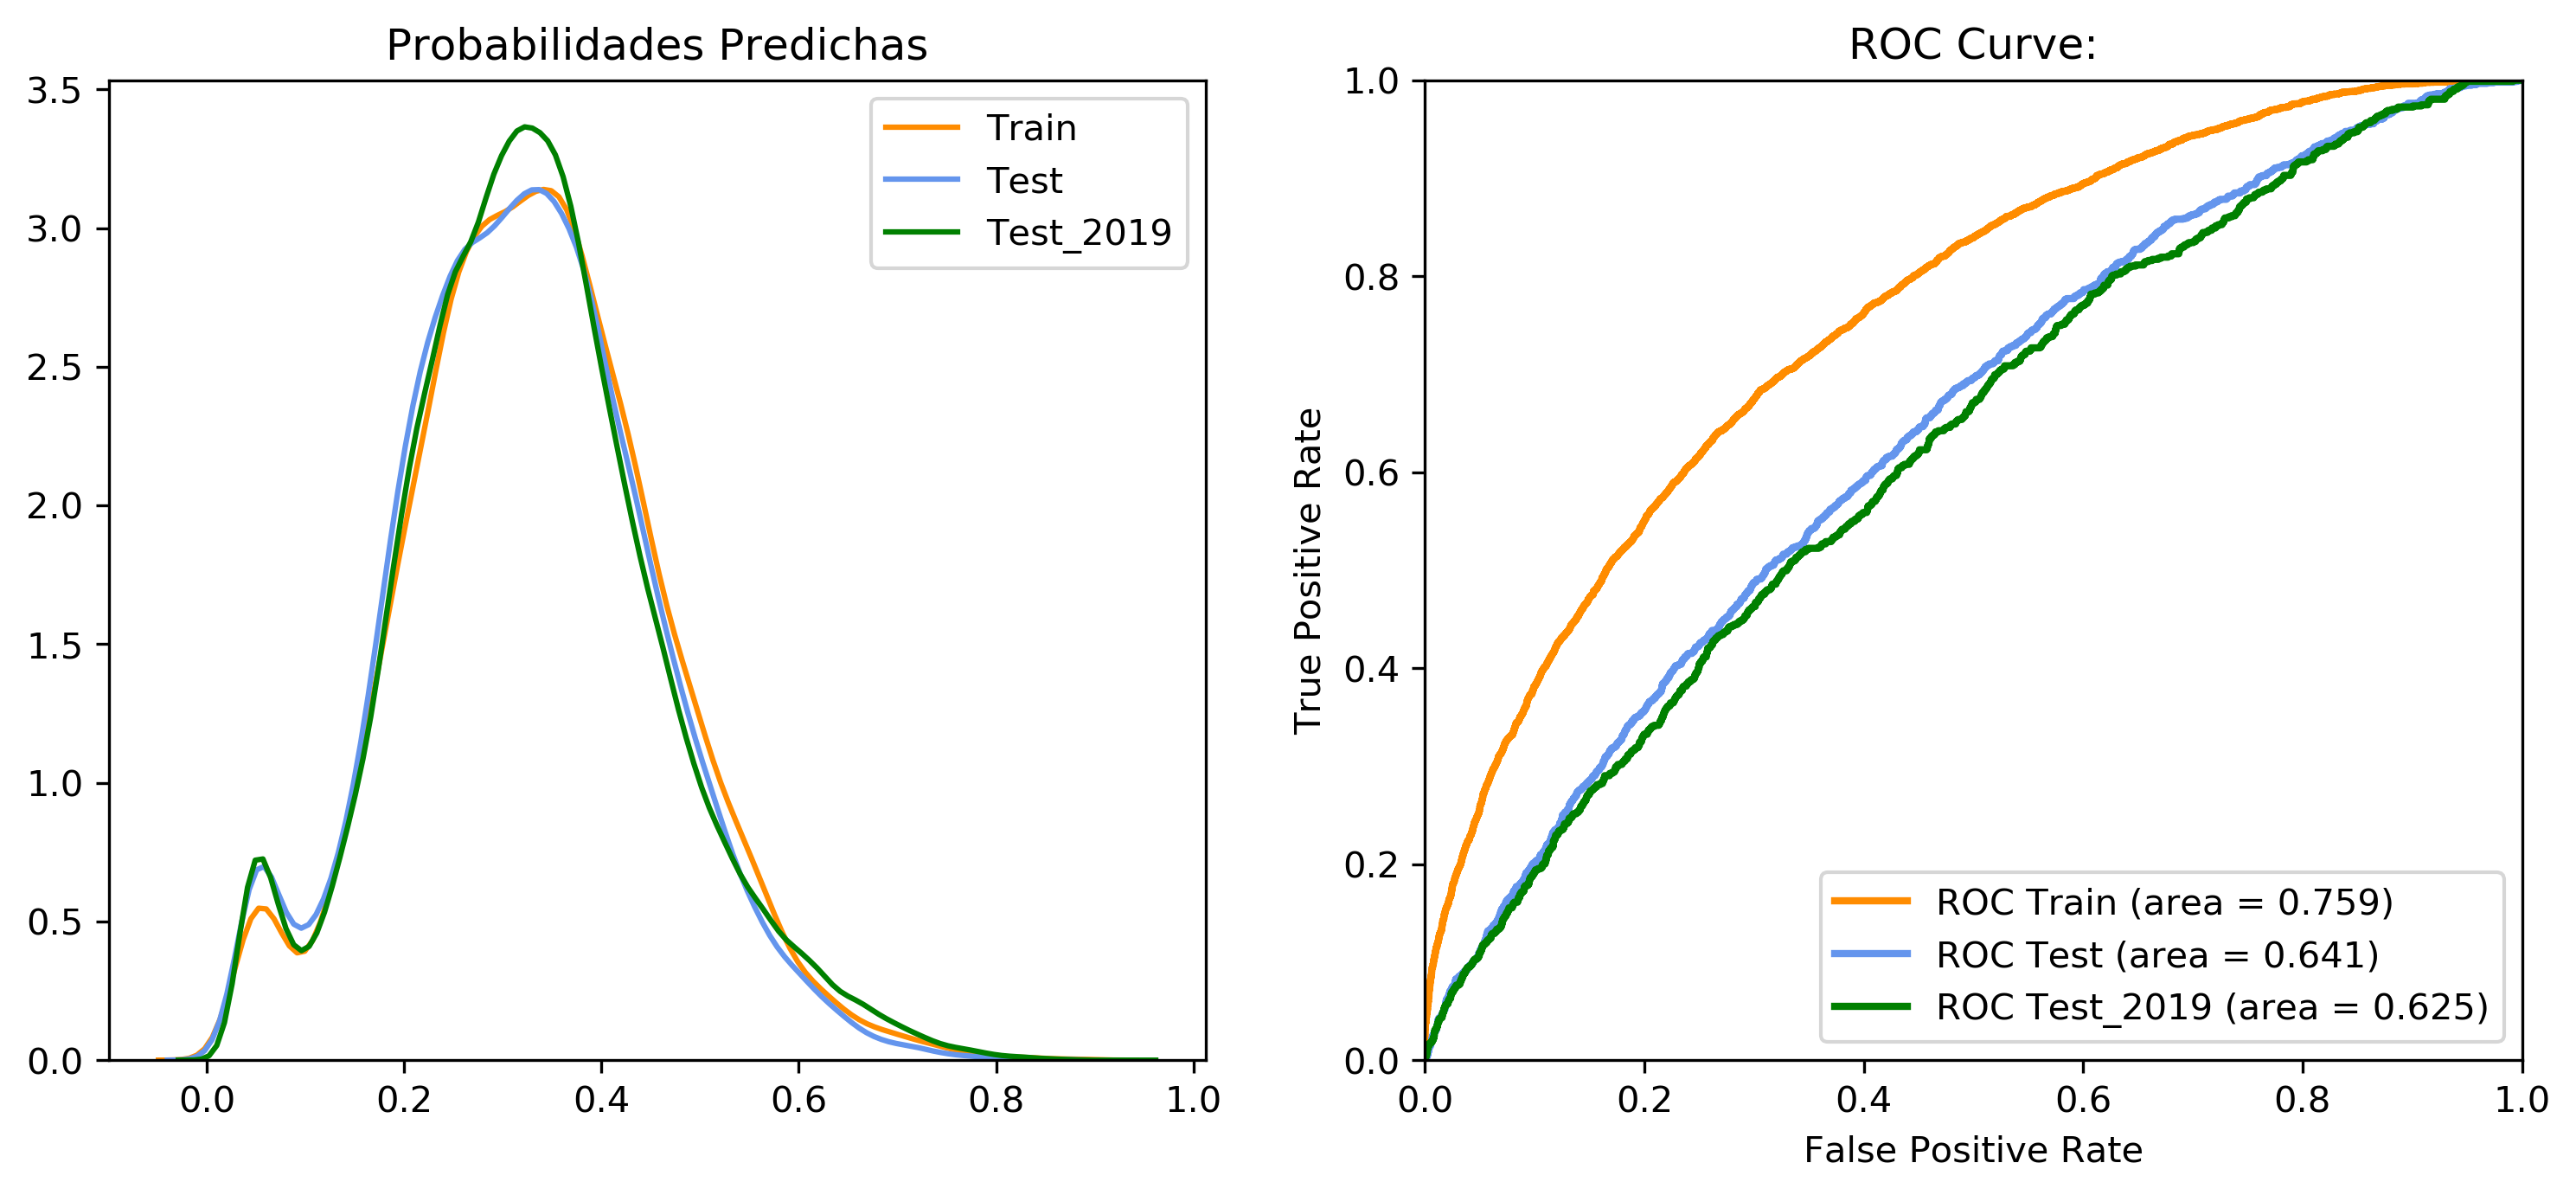

<Figure size 432x288 with 0 Axes>

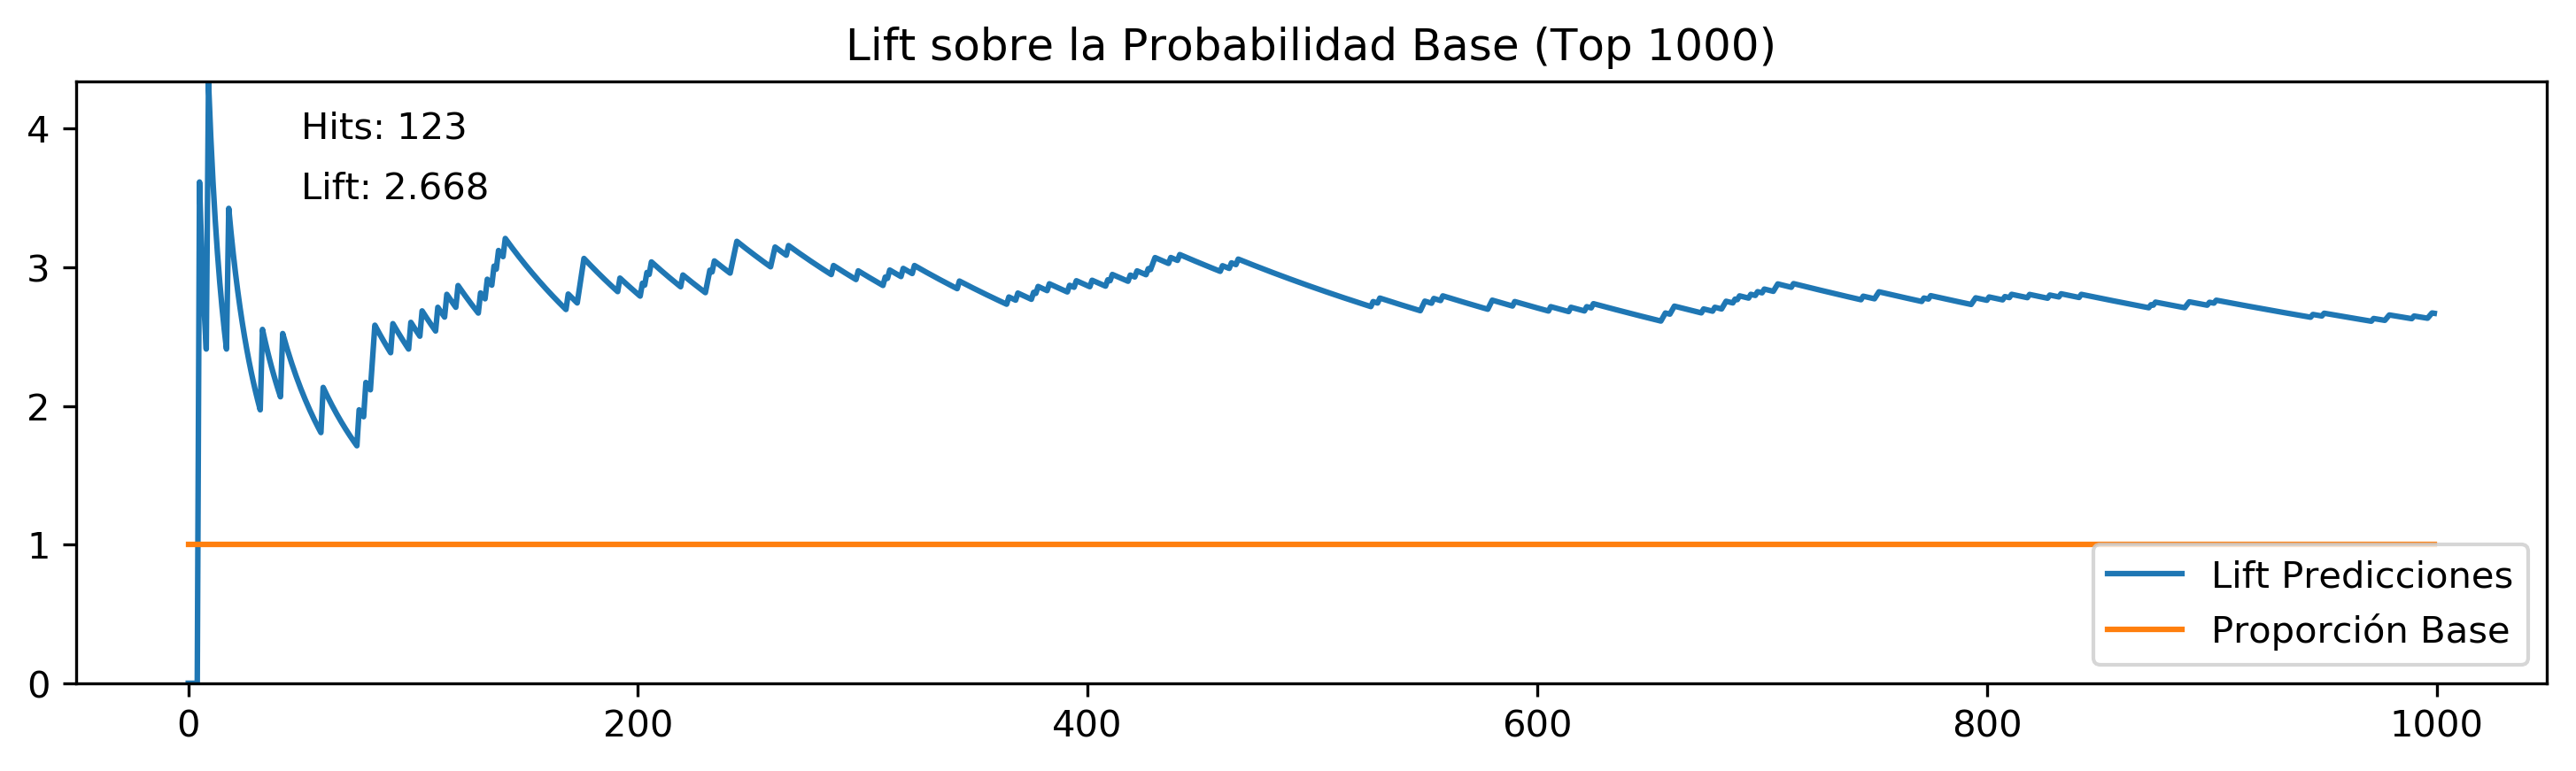

In [38]:
evaluate_predictions(Y_trn, probs['trn']['xgb'], probs['val']['xgb'], probs['tst']['xgb'])

Pruebas XGB: tiempo para hacer 1 XGB con 3fold-CV y refit final. (max_depth=11, learning_rate=0.1, n_estimators=300)

XGB(gpu_predictor, nthread=1) + GridSearchCV(n_jobs=1): 54s  
XGB(gpu_predictor, nthread=4) + GridSearchCV(n_jobs=3): 54s  
XGB(gpu_predictor, nthread=12) + GridSearchCV(n_jobs=1): 54s  
XGB(nthread=1) + GridSearchCV(n_jobs=-1): 36s  
XGB(nthread=4) + GridSearchCV(n_jobs = 3): 15s  
XGB(nthread=12) + GridSearchCV(n_jobs = 1): 15s  
XGB(nthread=12) + GridSearchCV(n_jobs = -1): 14s  

Conjeto que si nthread=12, el refit final debe ser más rápido. También, sólo si se tienen muchos datos, utilizar la GPU acelerará el proceso. Si no, no vale la pena.

### Multi-Layer Perceptron

In [14]:
es = EarlyStopping(monitor='auroc', patience=100, verbose=0, mode="max", min_delta=0.0001)

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

np.random.seed(12345)
tf.set_random_seed(12345)

mlp_mdl = Sequential()
mlp_mdl.add(Dense(32, input_dim=X_trn.shape[1], activation='relu'))
mlp_mdl.add(Dropout(0.25))
mlp_mdl.add(Dense(128, activation='relu'))
mlp_mdl.add(Dropout(0.25))
mlp_mdl.add(Dense(128, activation='relu'))
mlp_mdl.add(Dropout(0.25))
mlp_mdl.add(Dense(1, activation='sigmoid'))

mlp_mdl.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=[auroc])
history_mlp = mlp_mdl.fit(X_trn, Y_trn,
              epochs=400,
              batch_size=X_trn.shape[0],
              validation_data=(X_val, Y_val),
              callbacks=[es],
              verbose=0)

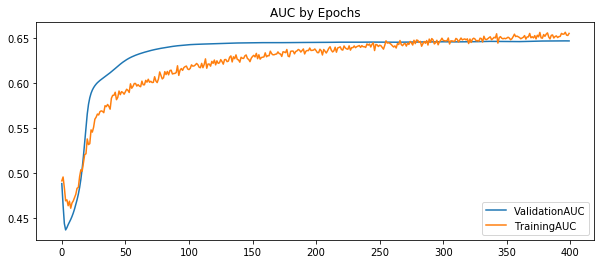

In [15]:
# Progreso de la red por épocas
plt.figure(figsize=(10,4))
plt.plot(history_mlp.history['val_auroc'], label='ValidationAUC')
plt.plot(history_mlp.history['auroc'], label='TrainingAUC')
plt.title("AUC by Epochs")
plt.legend(loc='lower right')
plt.show;

In [16]:
Y_pred = probs['trn']['mlp'] = [a[0] for a in mlp_mdl.predict_proba(X_trn)]
Y_pred_val = probs['val']['mlp'] = [a[0] for a in mlp_mdl.predict_proba(X_val)]
history_mlp = mlp_mdl.fit(X_trn_c, Y_trn_c,
              epochs=400,
              batch_size=X_trn.shape[0],
              validation_data=(X_val, Y_val),
              callbacks=[es],
              verbose=0)
Y_pred_tst = probs['tst']['mlp'] = [a[0] for a in mlp_mdl.predict_proba(X_tst)]

F0.5 Score Train: 0.359
F0.5 Score Val: 0.106
F0.5 Score Test: 0.011


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


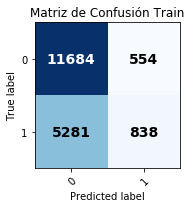

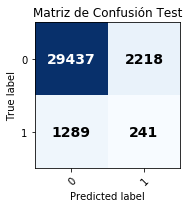

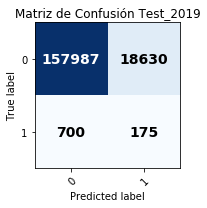

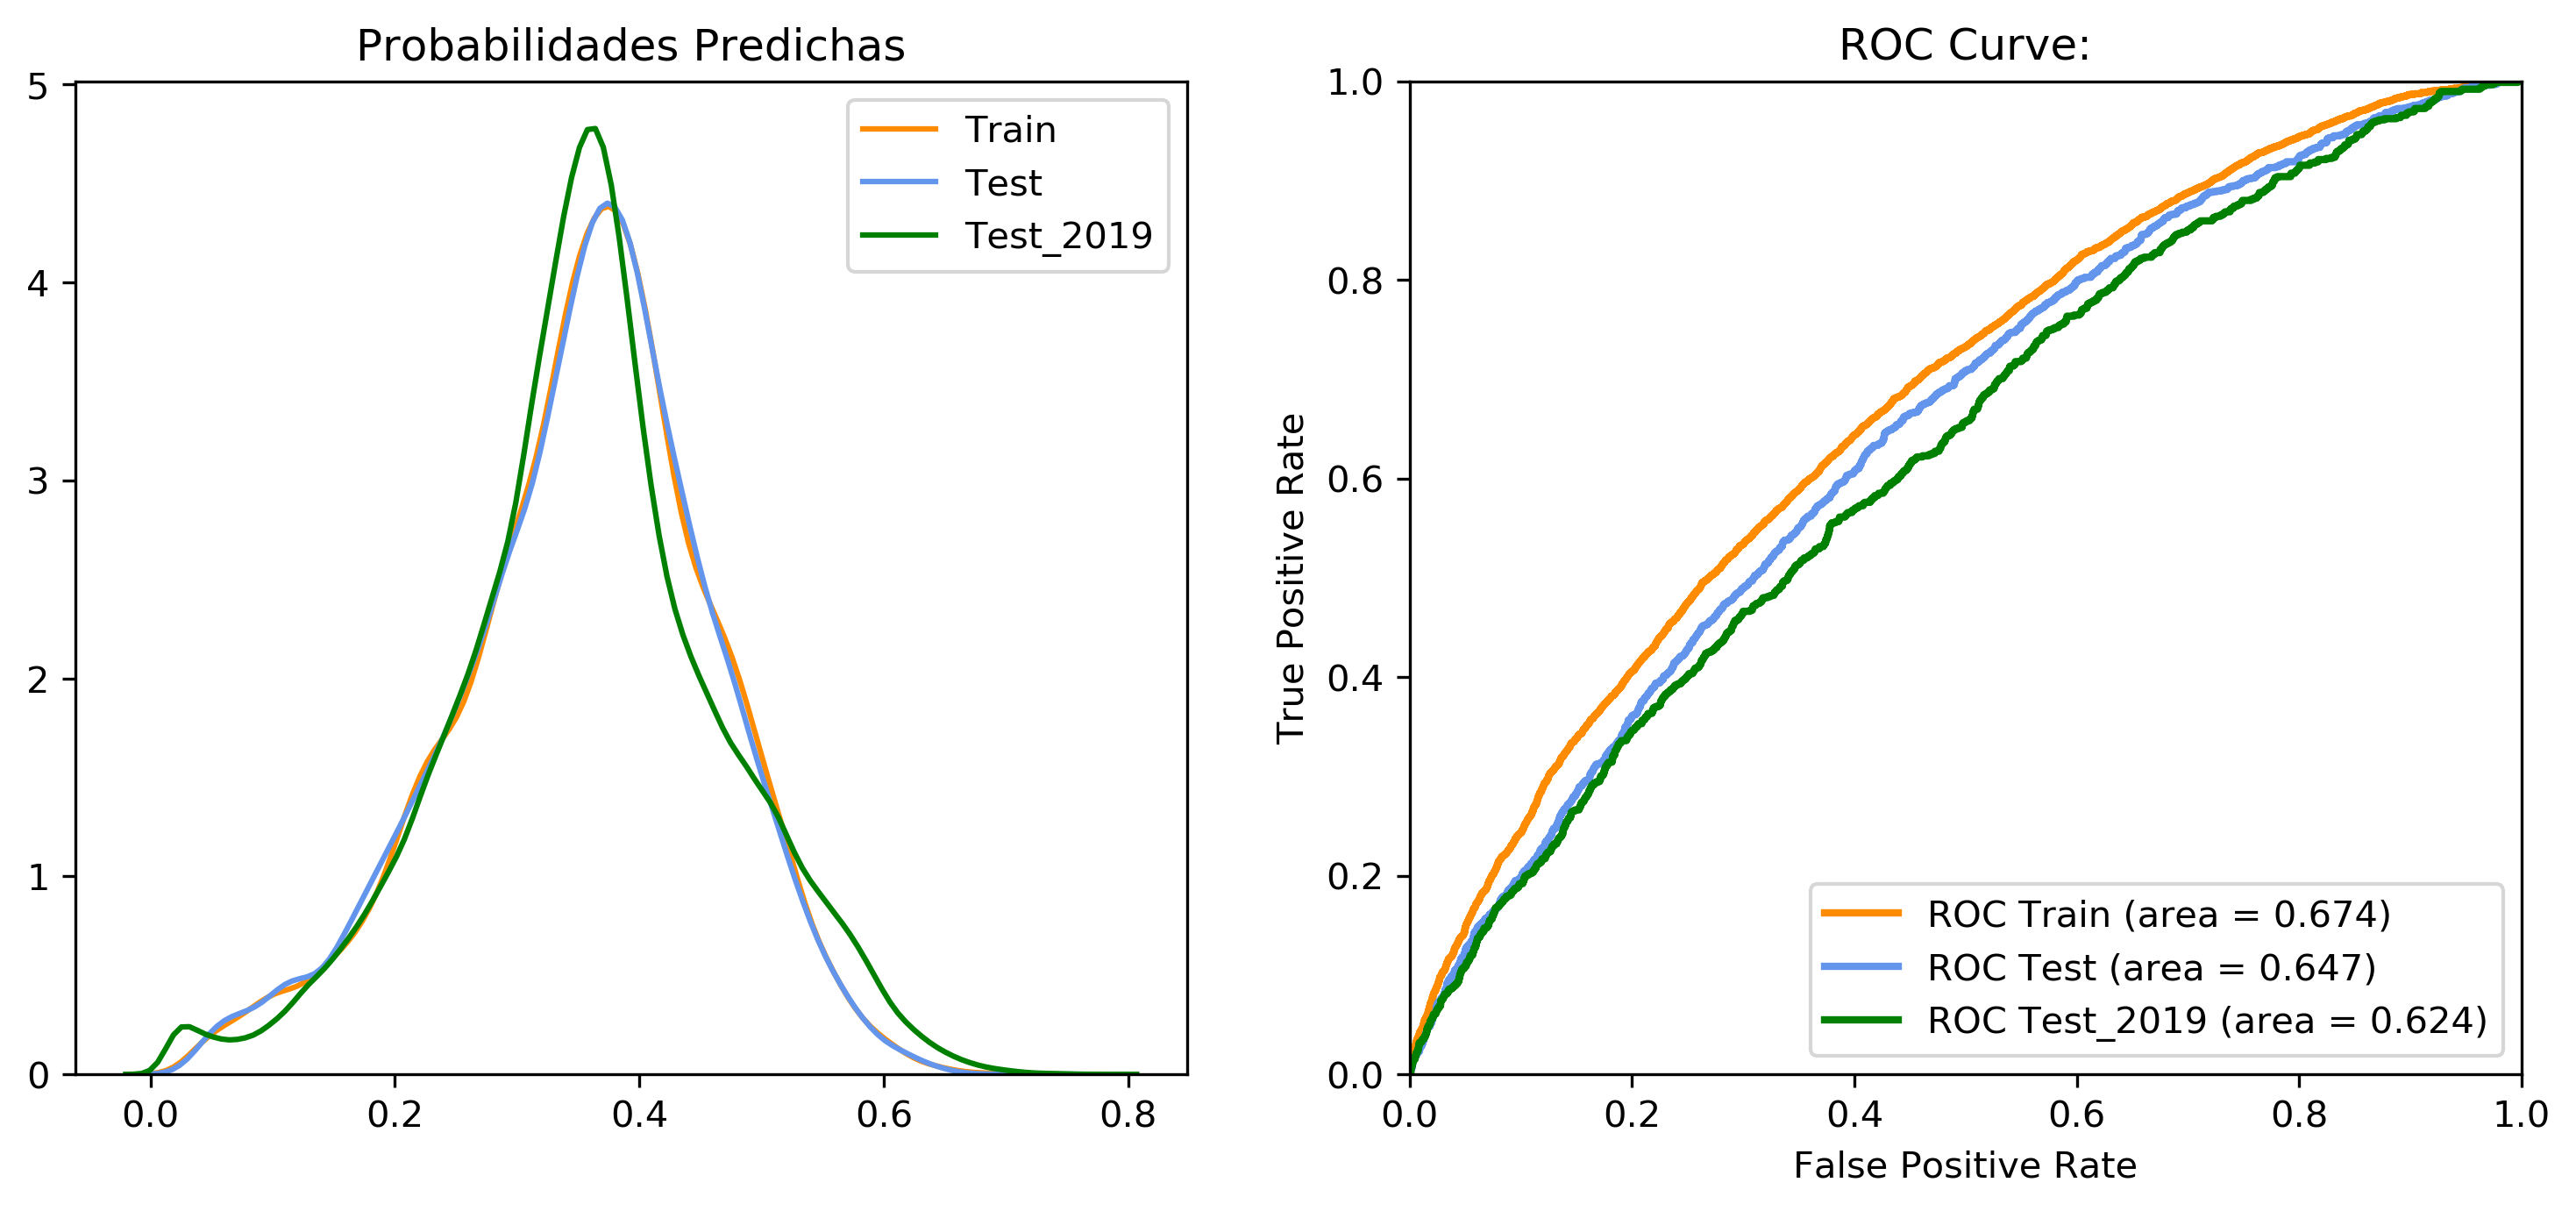

<Figure size 432x288 with 0 Axes>

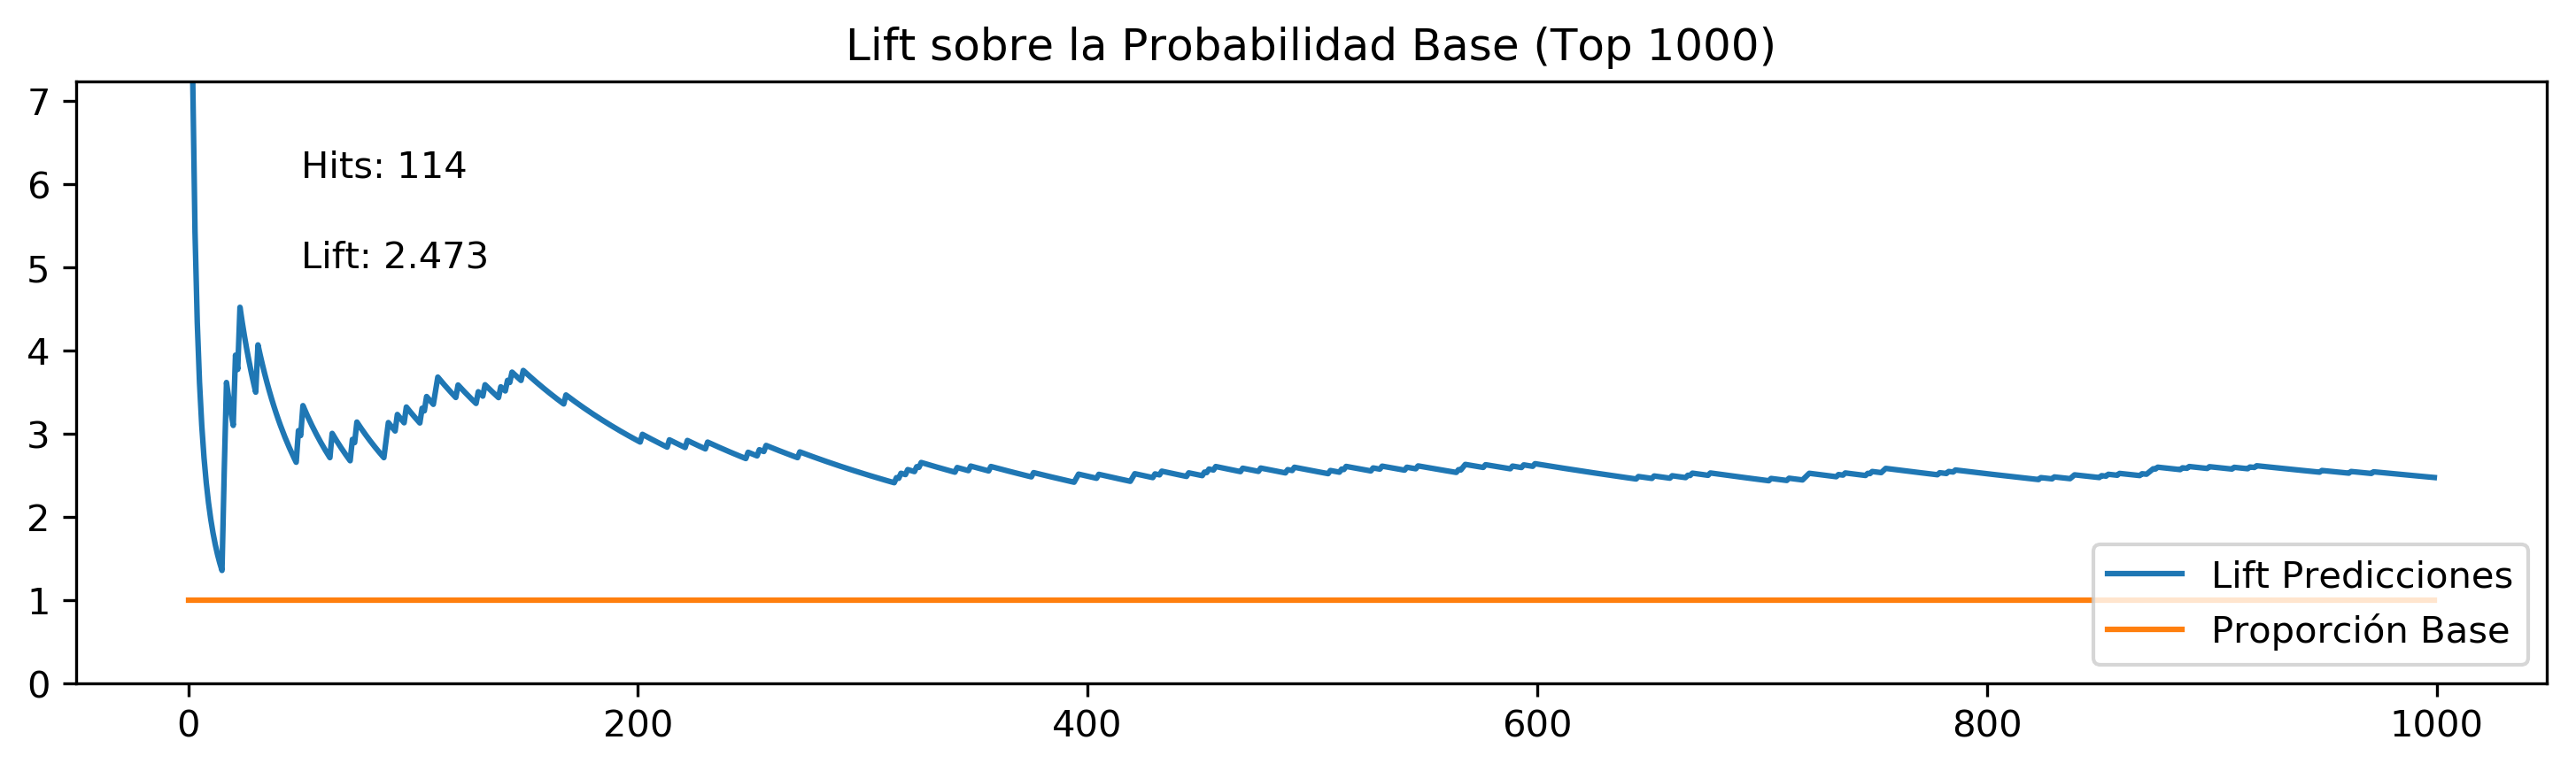

In [17]:
evaluate_predictions(Y_trn, probs['trn']['mlp'], probs['val']['mlp'], probs['tst']['mlp'], lift_label_y=5)

## Correlaciones entre las predicciones

<Figure size 1920x1440 with 0 Axes>

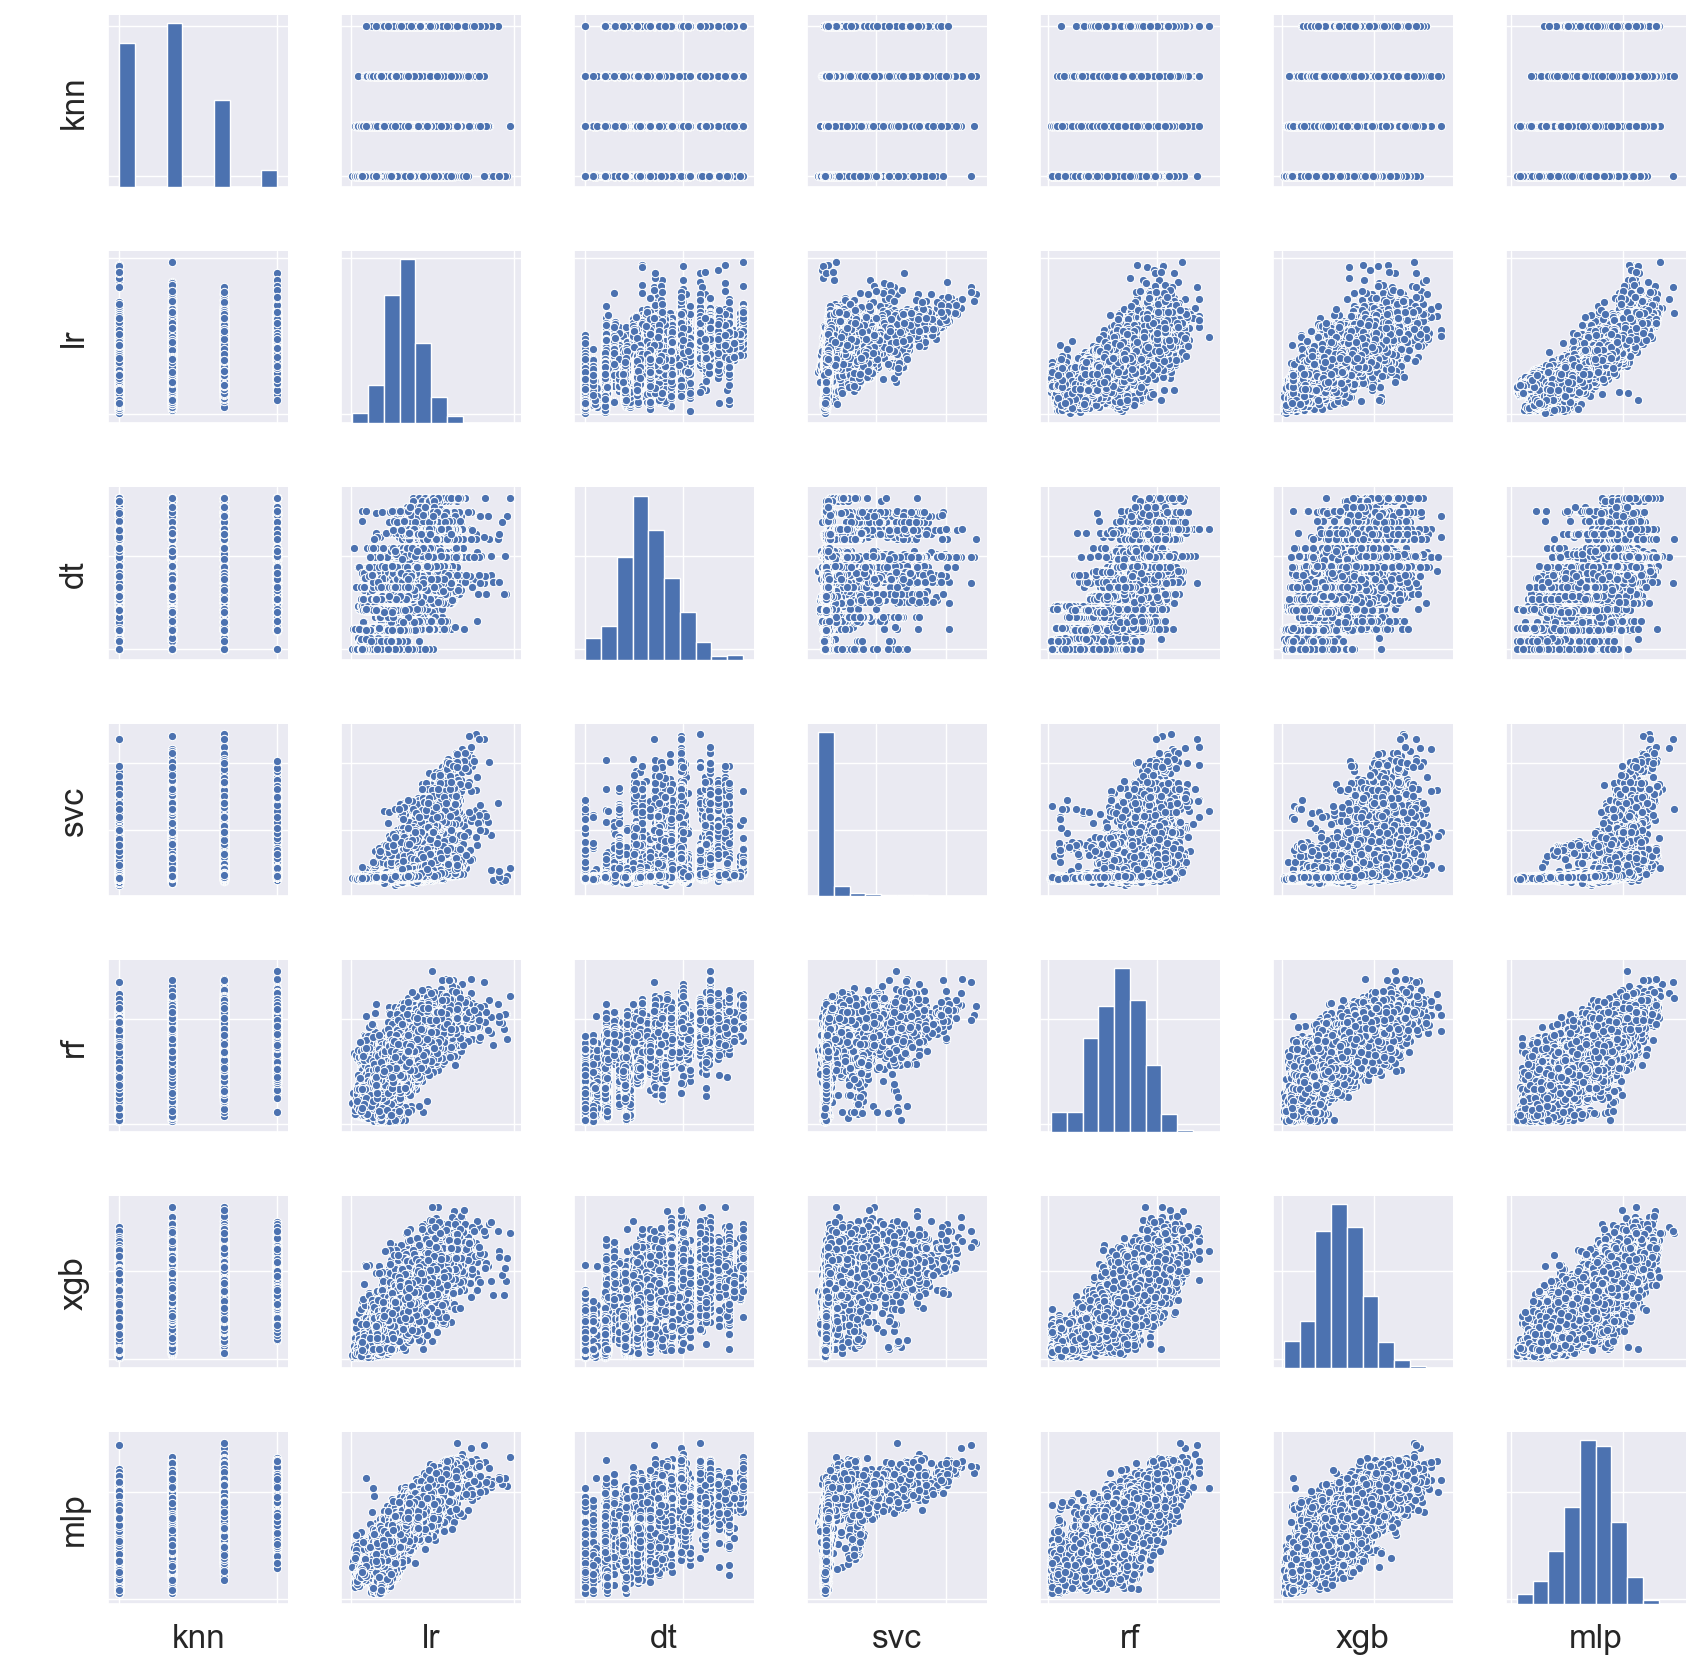

In [429]:
plt.figure(dpi=300)
preds = pd.DataFrame(probs['val'])
sns.set(font_scale=2)
g = sns.pairplot(preds);
g.set(xticklabels=[])
g.set(yticklabels=[])
plt.show();

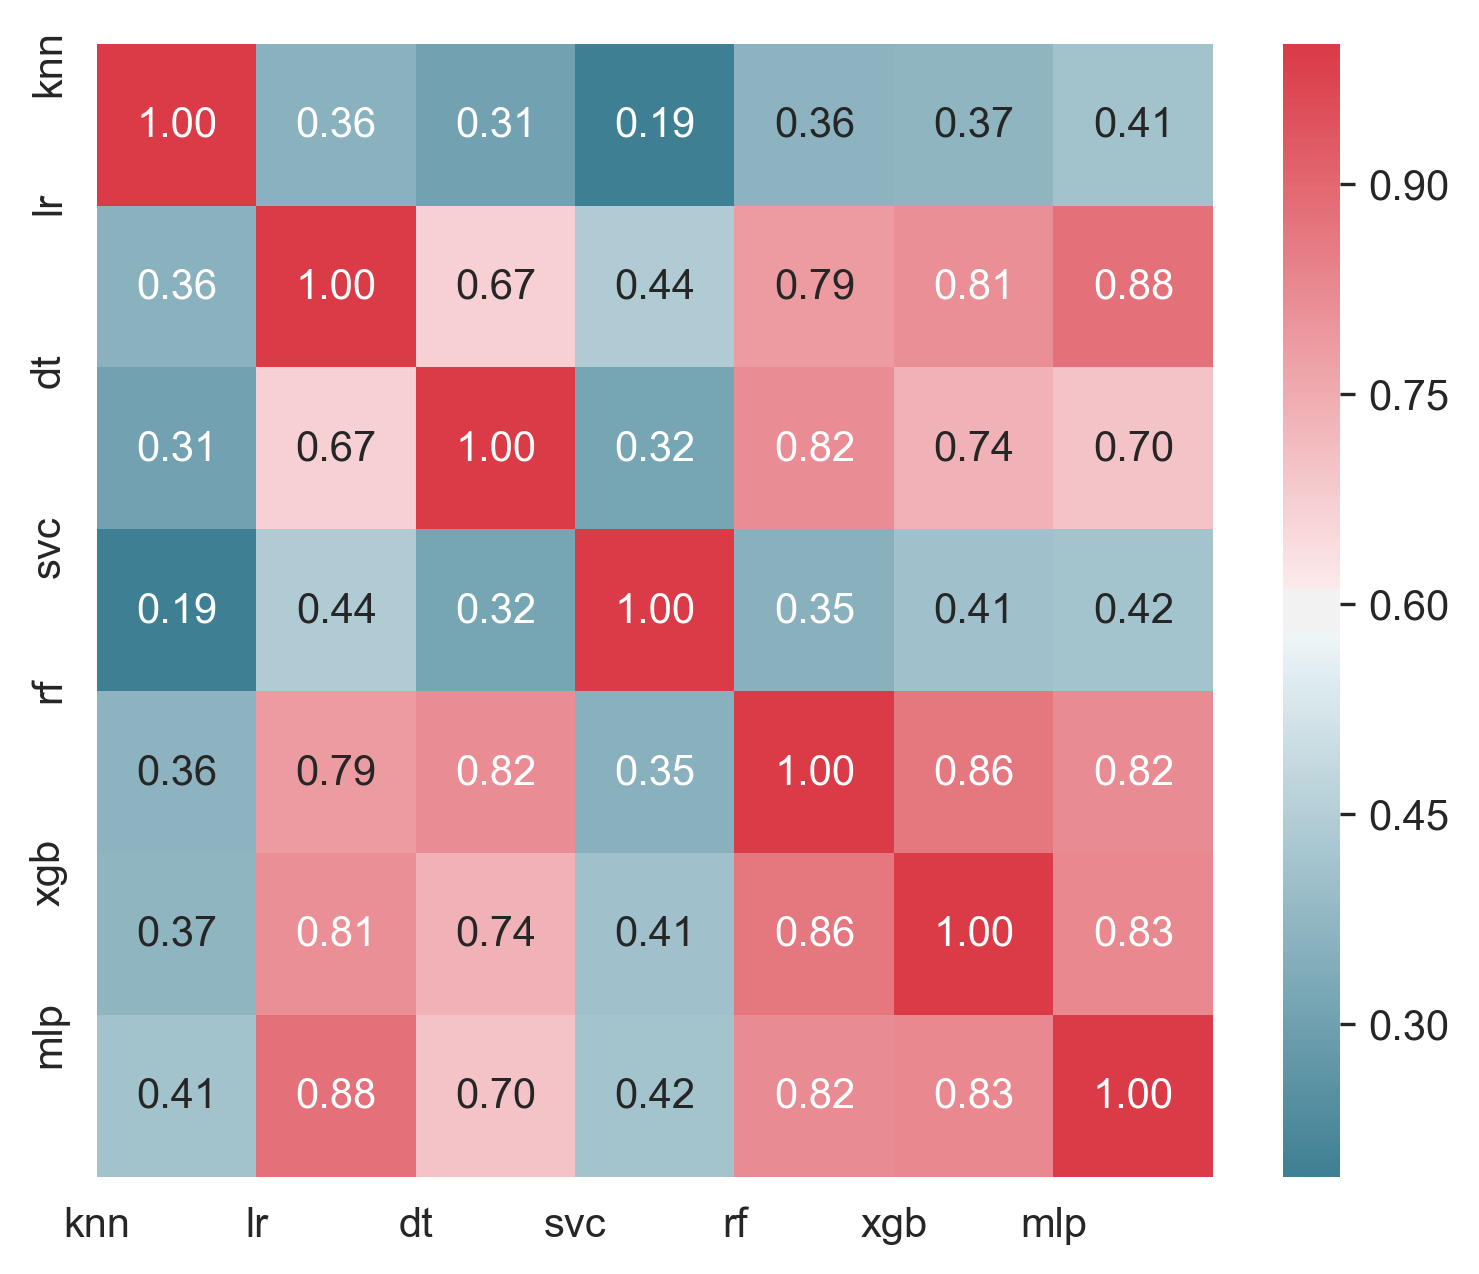

In [346]:
corr = preds.corr()
fig, ax = plt.subplots(figsize=(6, 5), dpi=300)
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

### Ensemble por media de probabilidades

In [ ]:
dropped_models = ['svc','knn']
Y_pred = pd.DataFrame(probs['trn']).drop(dropped_models, axis=1).apply(np.mean, axis=1)
Y_pred_val = pd.DataFrame(probs['val']).drop(dropped_models, axis=1).apply(np.mean, axis=1)
Y_pred_tst = pd.DataFrame(probs['tst']).drop(dropped_models, axis=1).apply(np.mean, axis=1)

F0.5 Score Train: 0.397
F0.5 Score Val: 0.111
F0.5 Score Test: 0.014


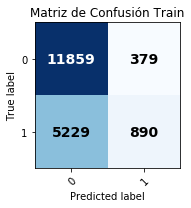

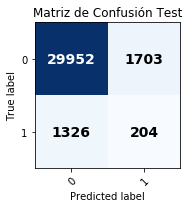

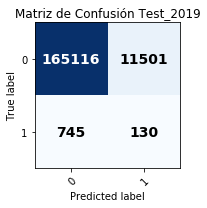

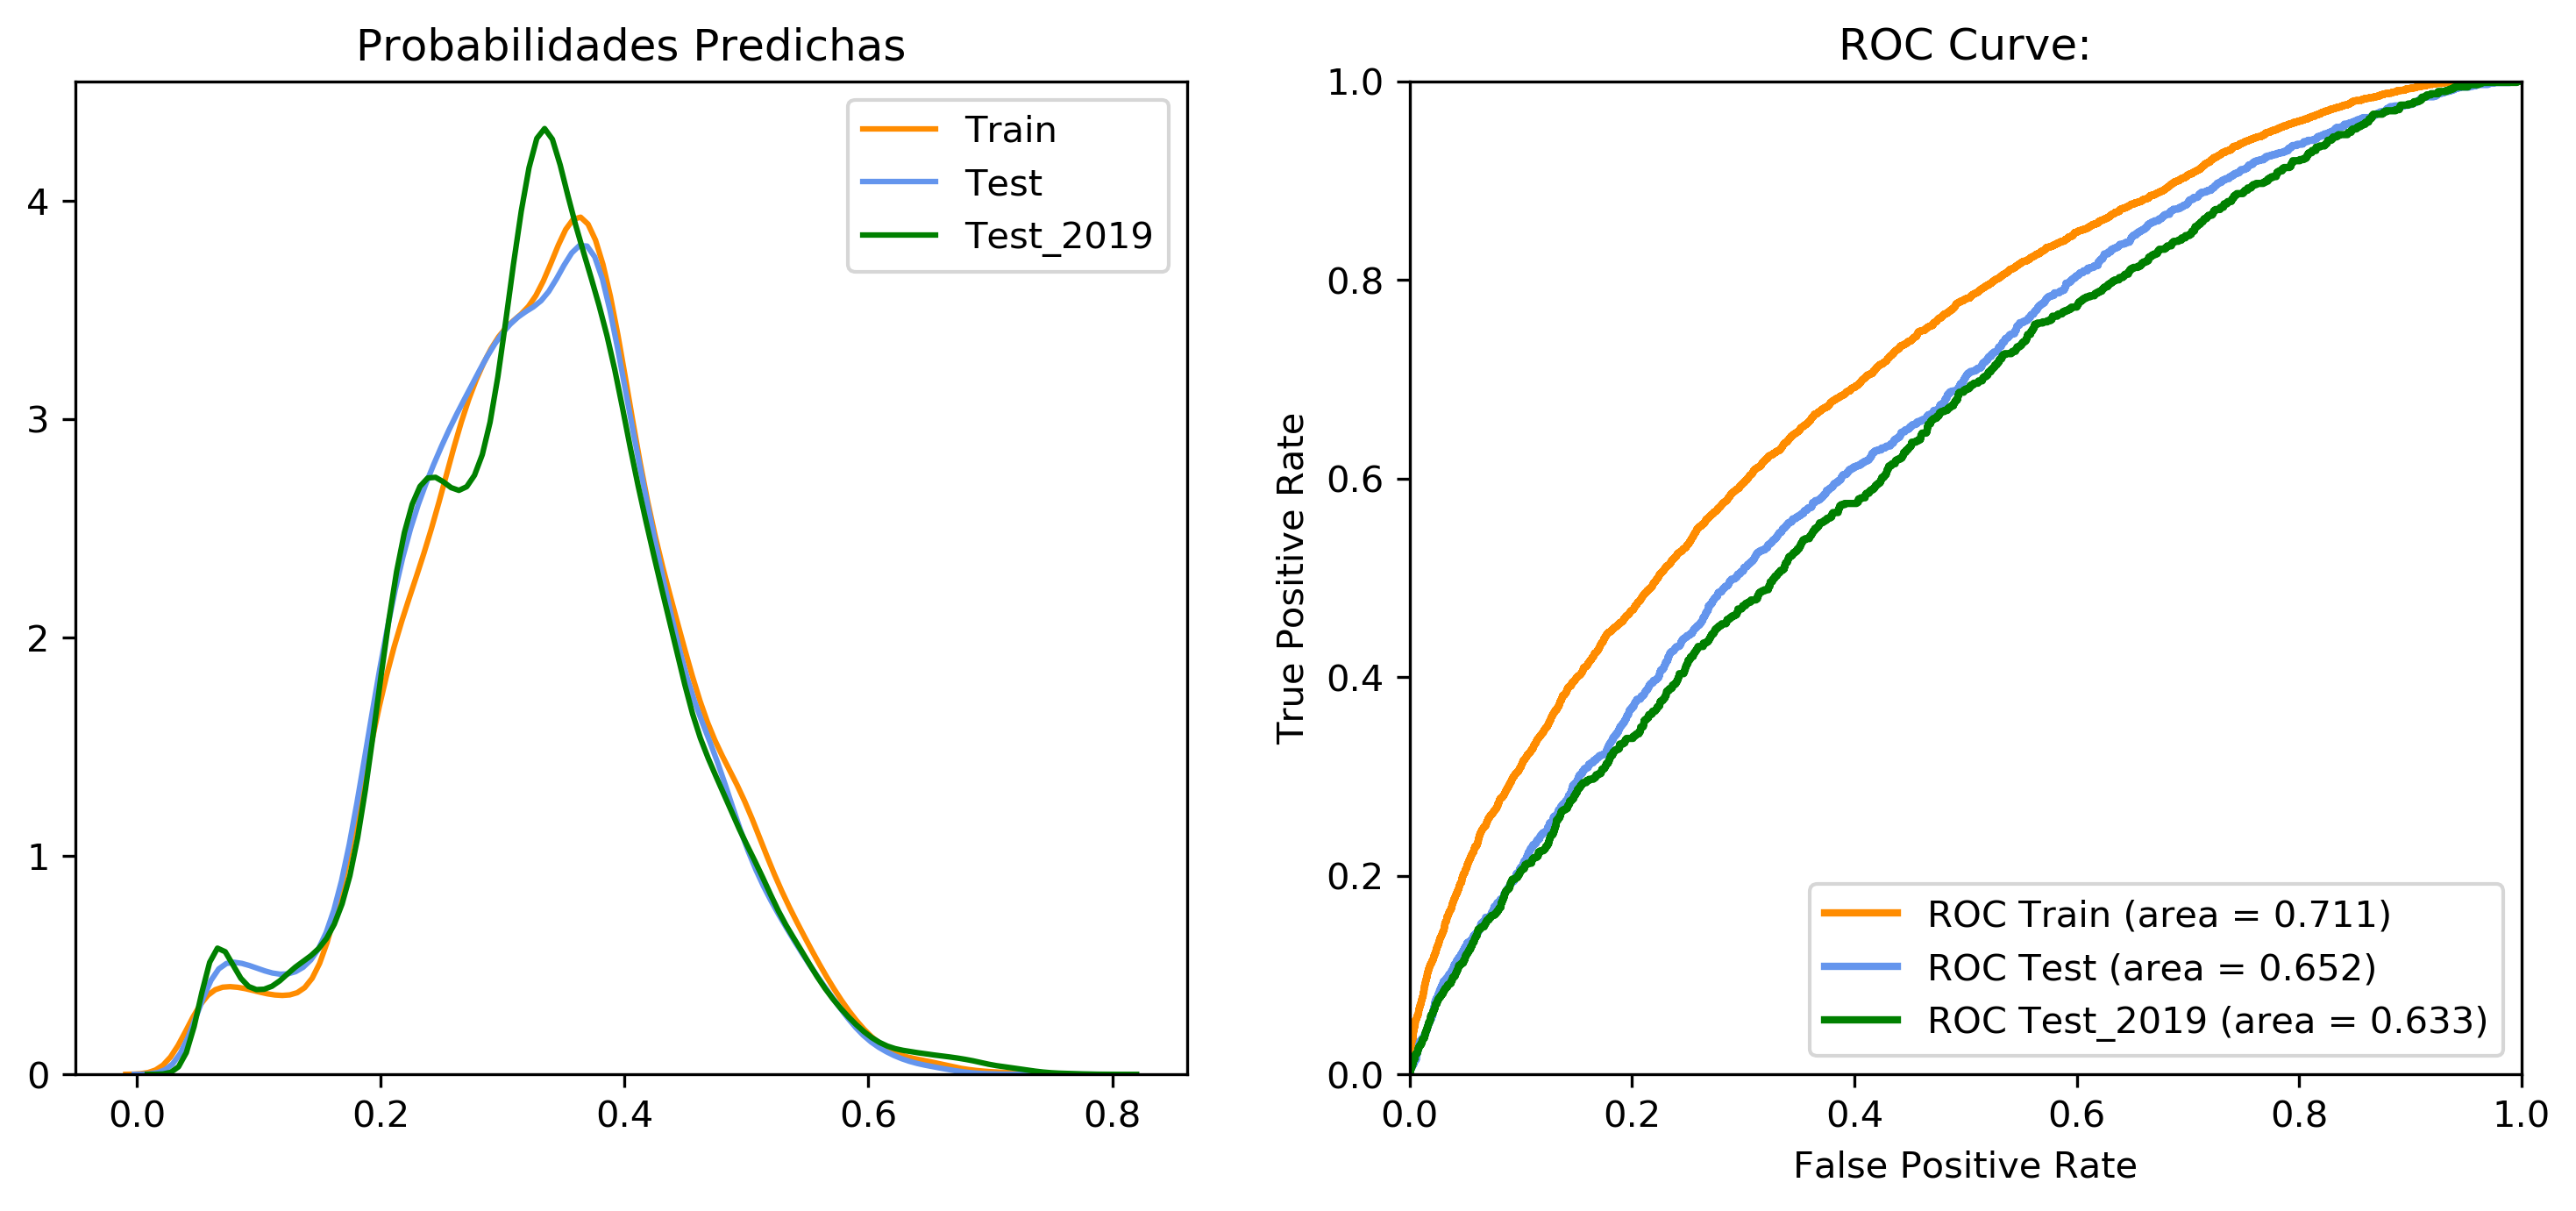

<Figure size 432x288 with 0 Axes>

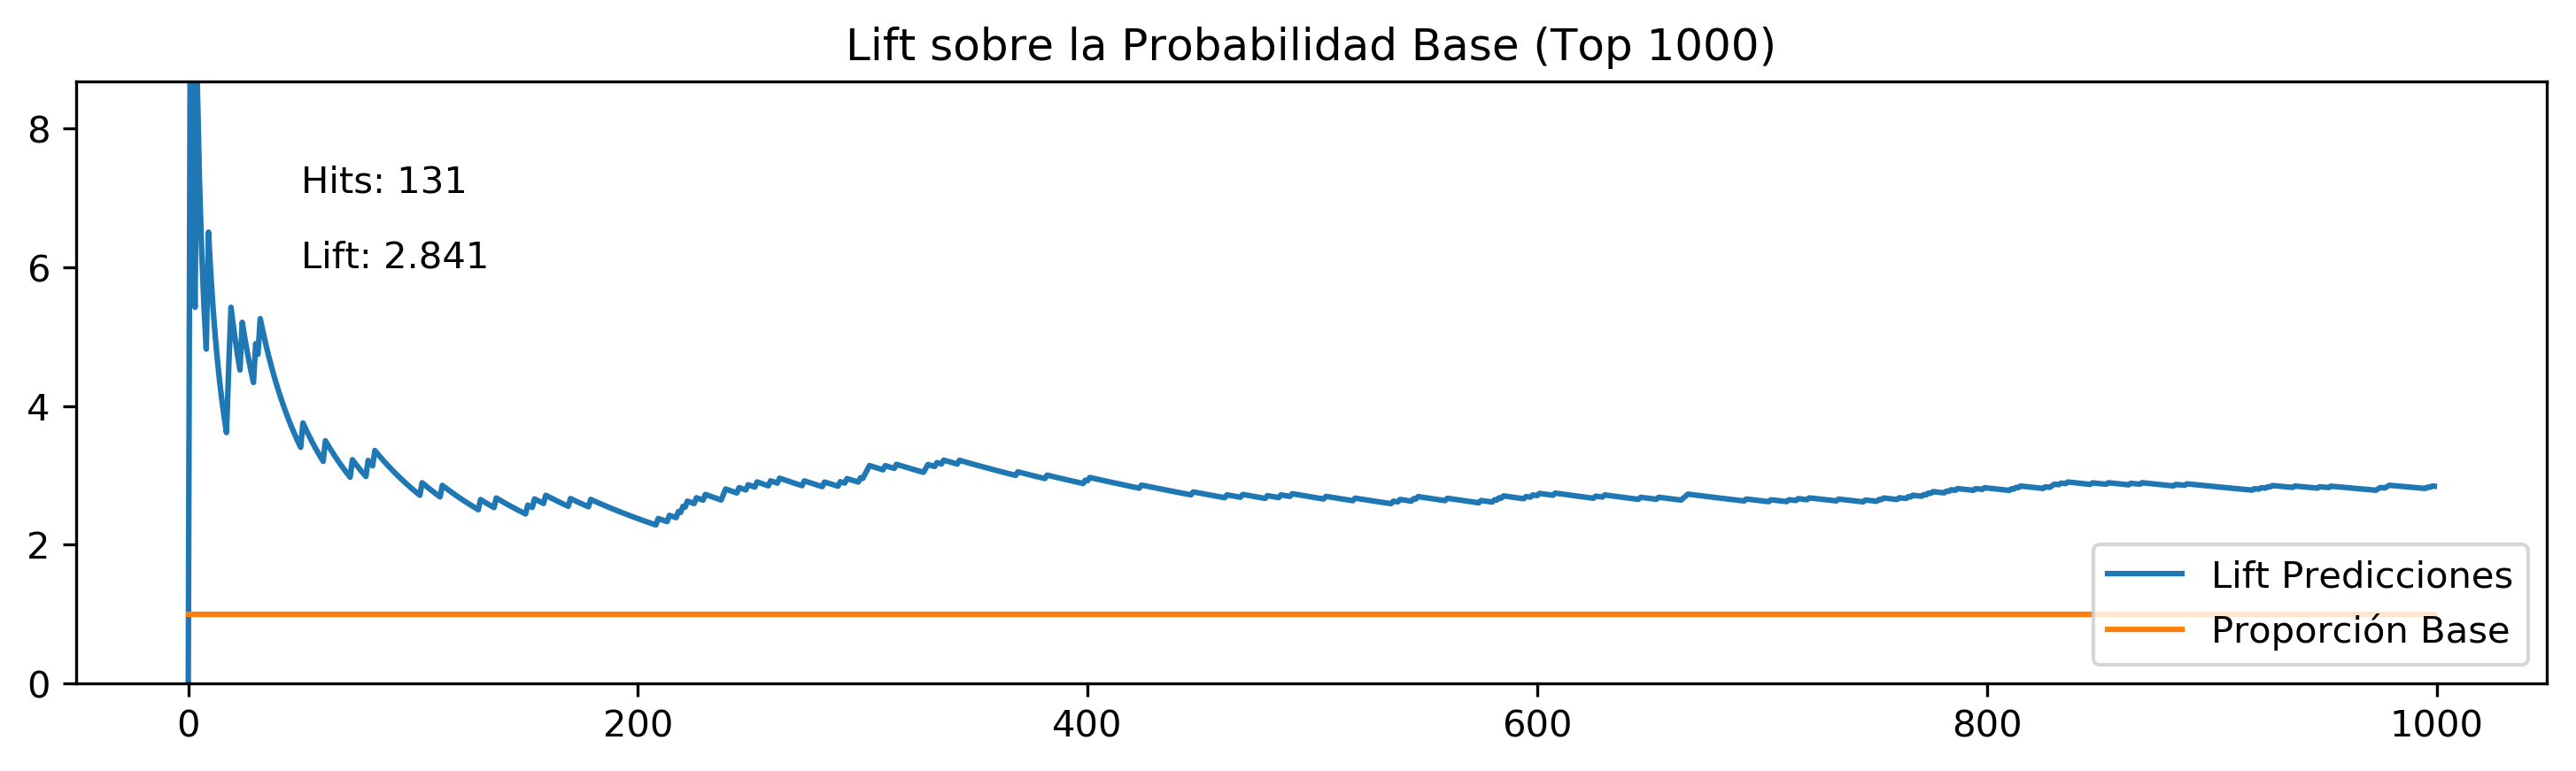

In [40]:
evaluate_predictions(Y_trn, Y_pred, Y_pred_val, Y_pred_tst, lift_label_y=6)

## Otras Pruebas Ensembles

### Ensemble por votación

F0.5 Score Train: 0.371
F0.5 Score Val: 0.109
F0.5 Score Test: 0.013


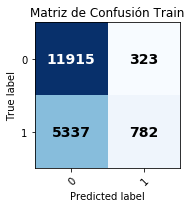

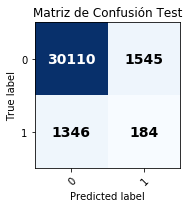

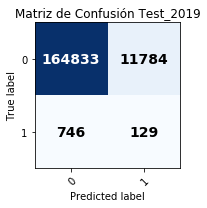

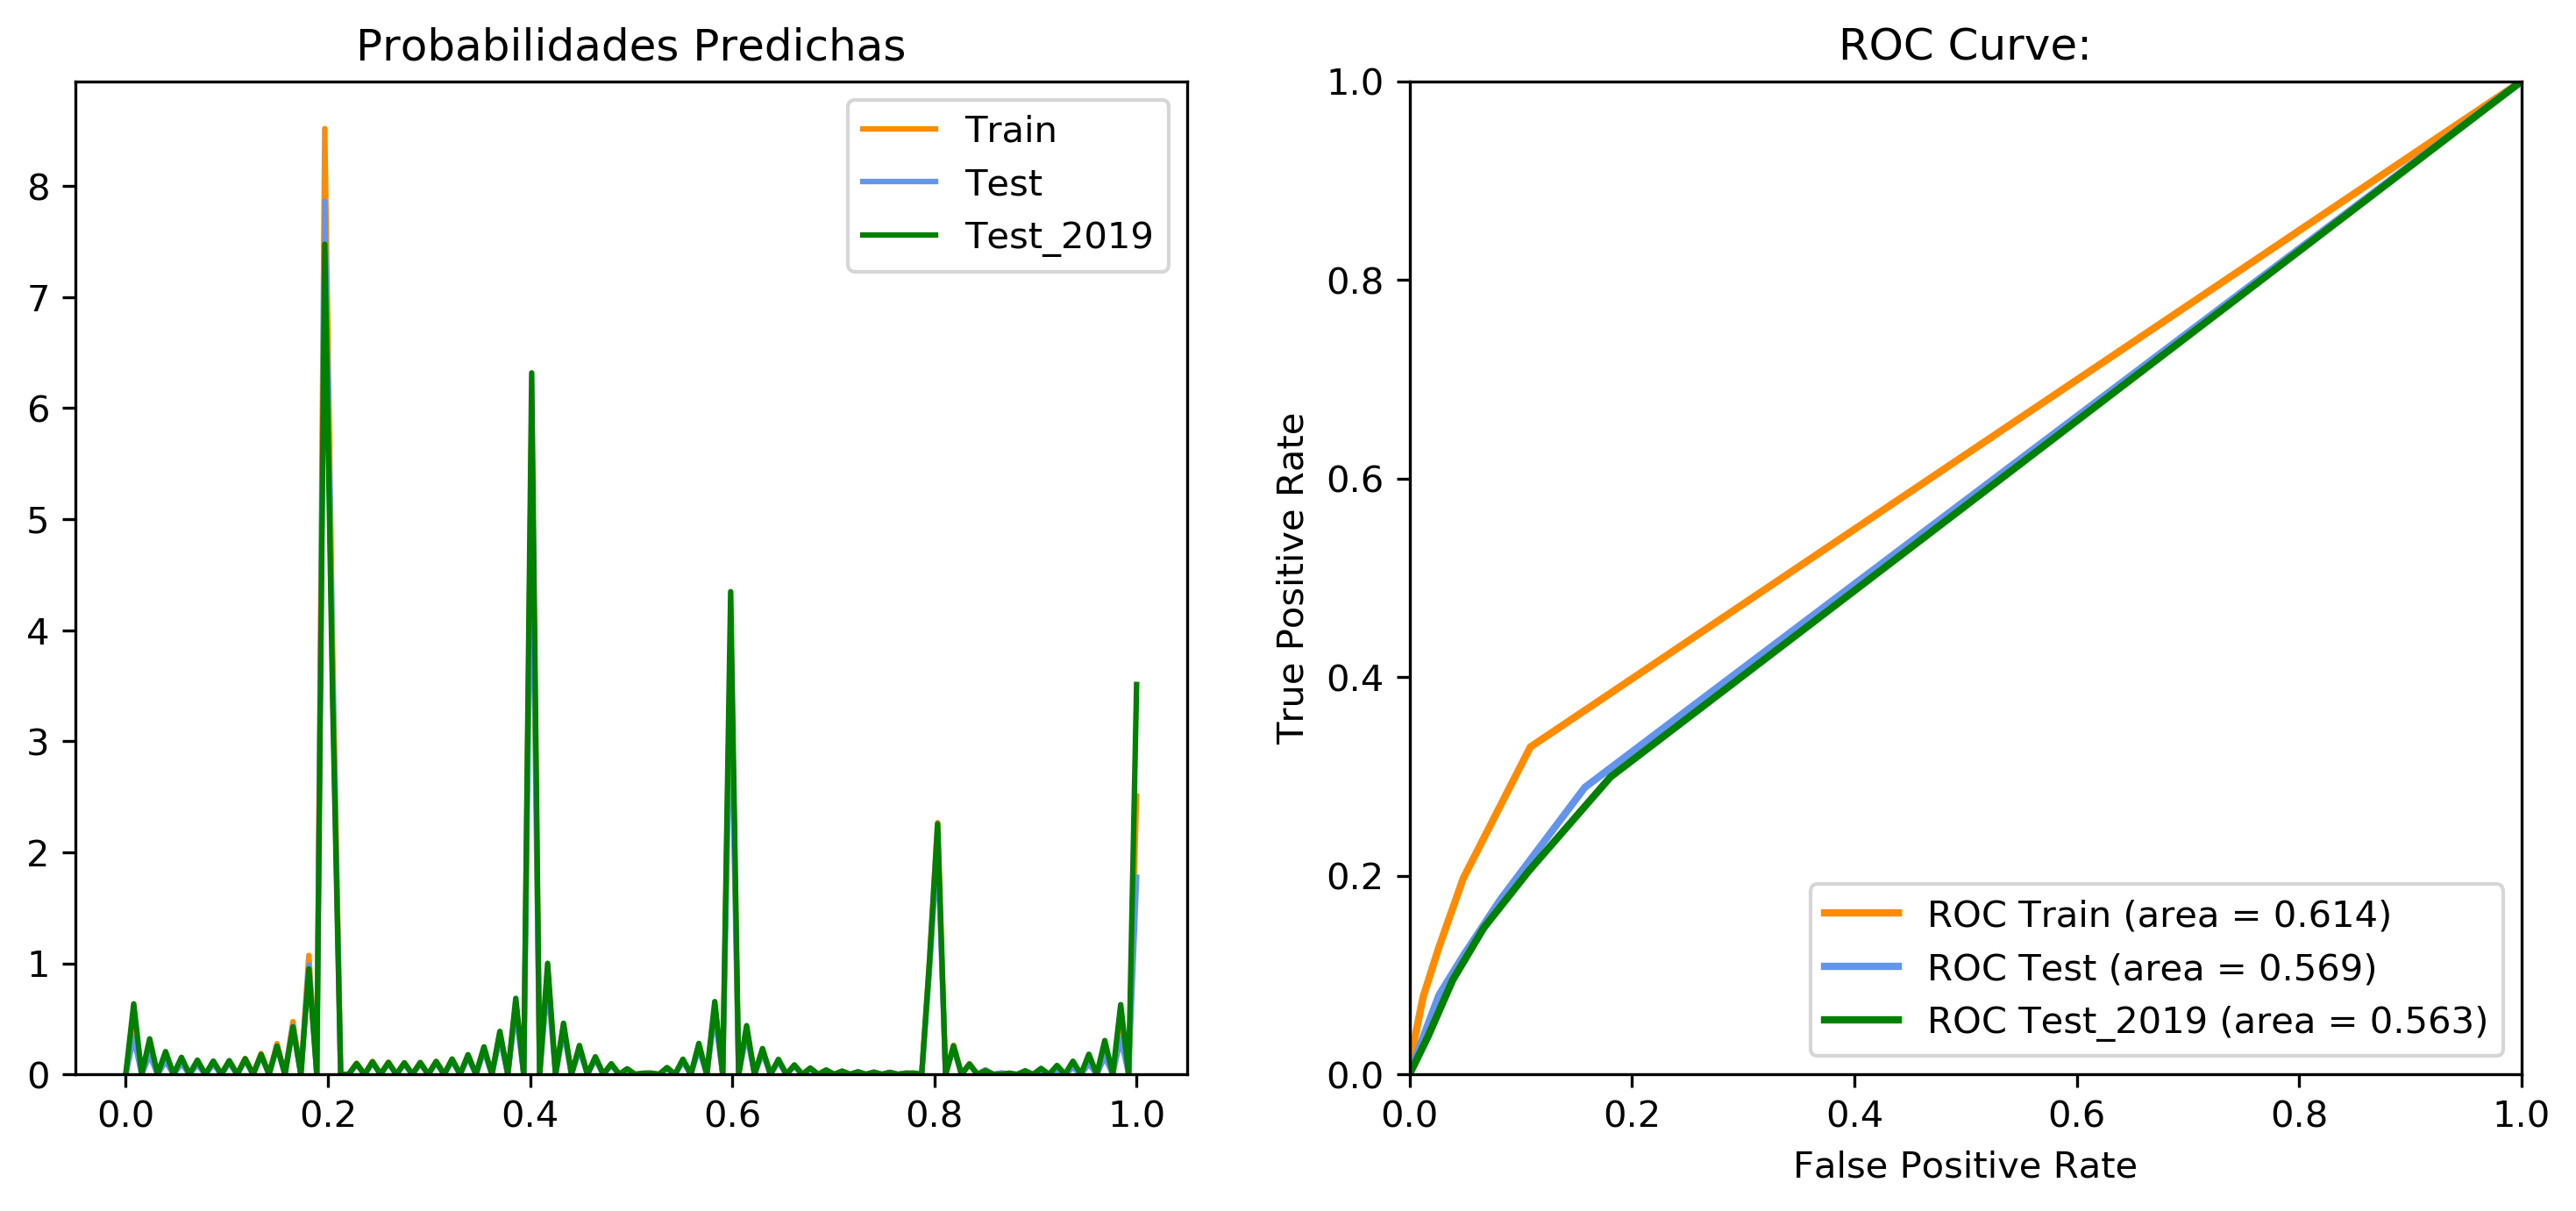

<Figure size 432x288 with 0 Axes>

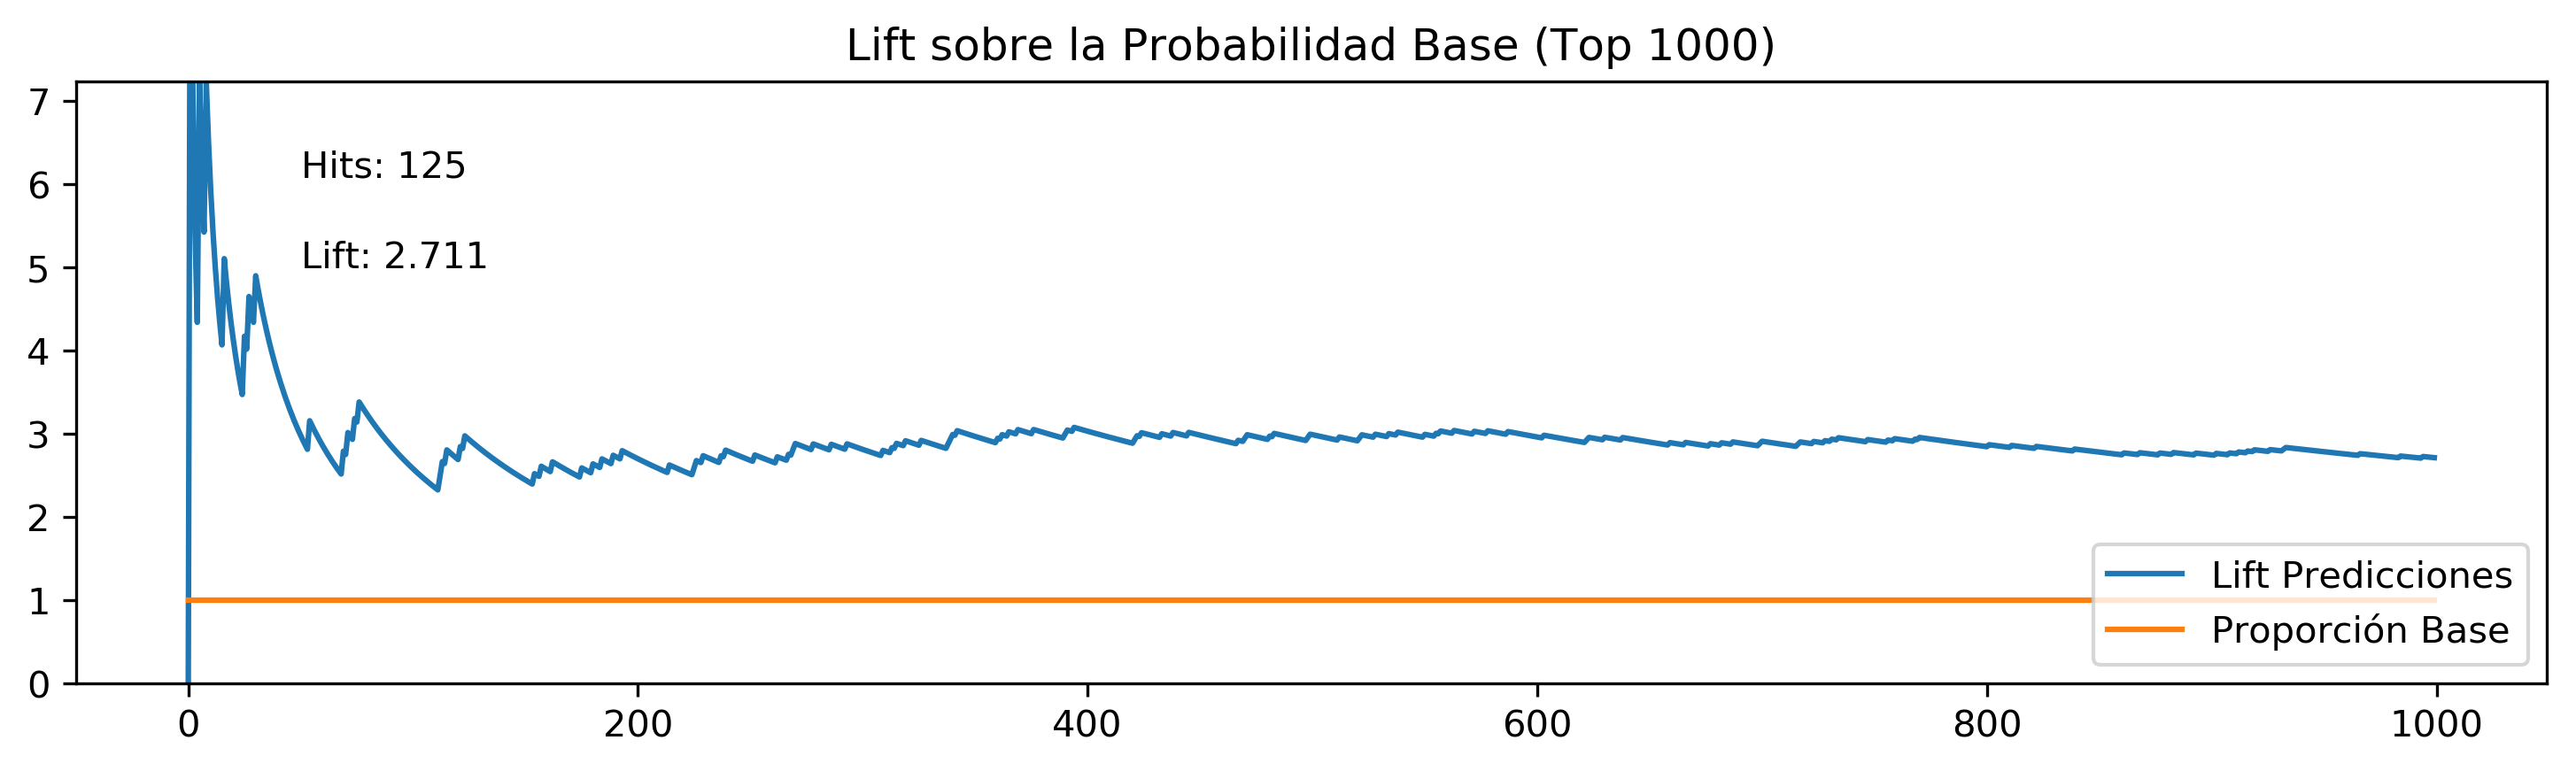

In [41]:
dropped_models = ['svc','knn']
Y_pred = pd.DataFrame(probs['trn']).drop(dropped_models, axis=1).apply(threshold, axis=0).apply(np.mean, axis=1)
Y_pred_val = pd.DataFrame(probs['val']).drop(dropped_models, axis=1).apply(threshold, axis=0).apply(np.mean, axis=1)
Y_pred_tst = pd.DataFrame(probs['tst']).drop(dropped_models, axis=1).apply(threshold, axis=0).apply(np.mean, axis=1)
evaluate_predictions(Y_trn, Y_pred, Y_pred_val, Y_pred_tst,lift_label_y=5)

### Ensemble por regresión logística de las predicciones

F0.5 Score Train: 0.484
F0.5 Score Val: 0.108
F0.5 Score Test: 0.013


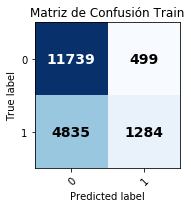

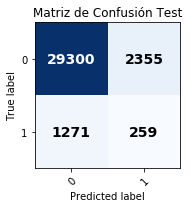

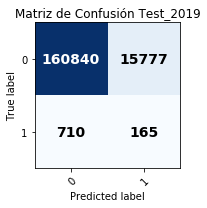

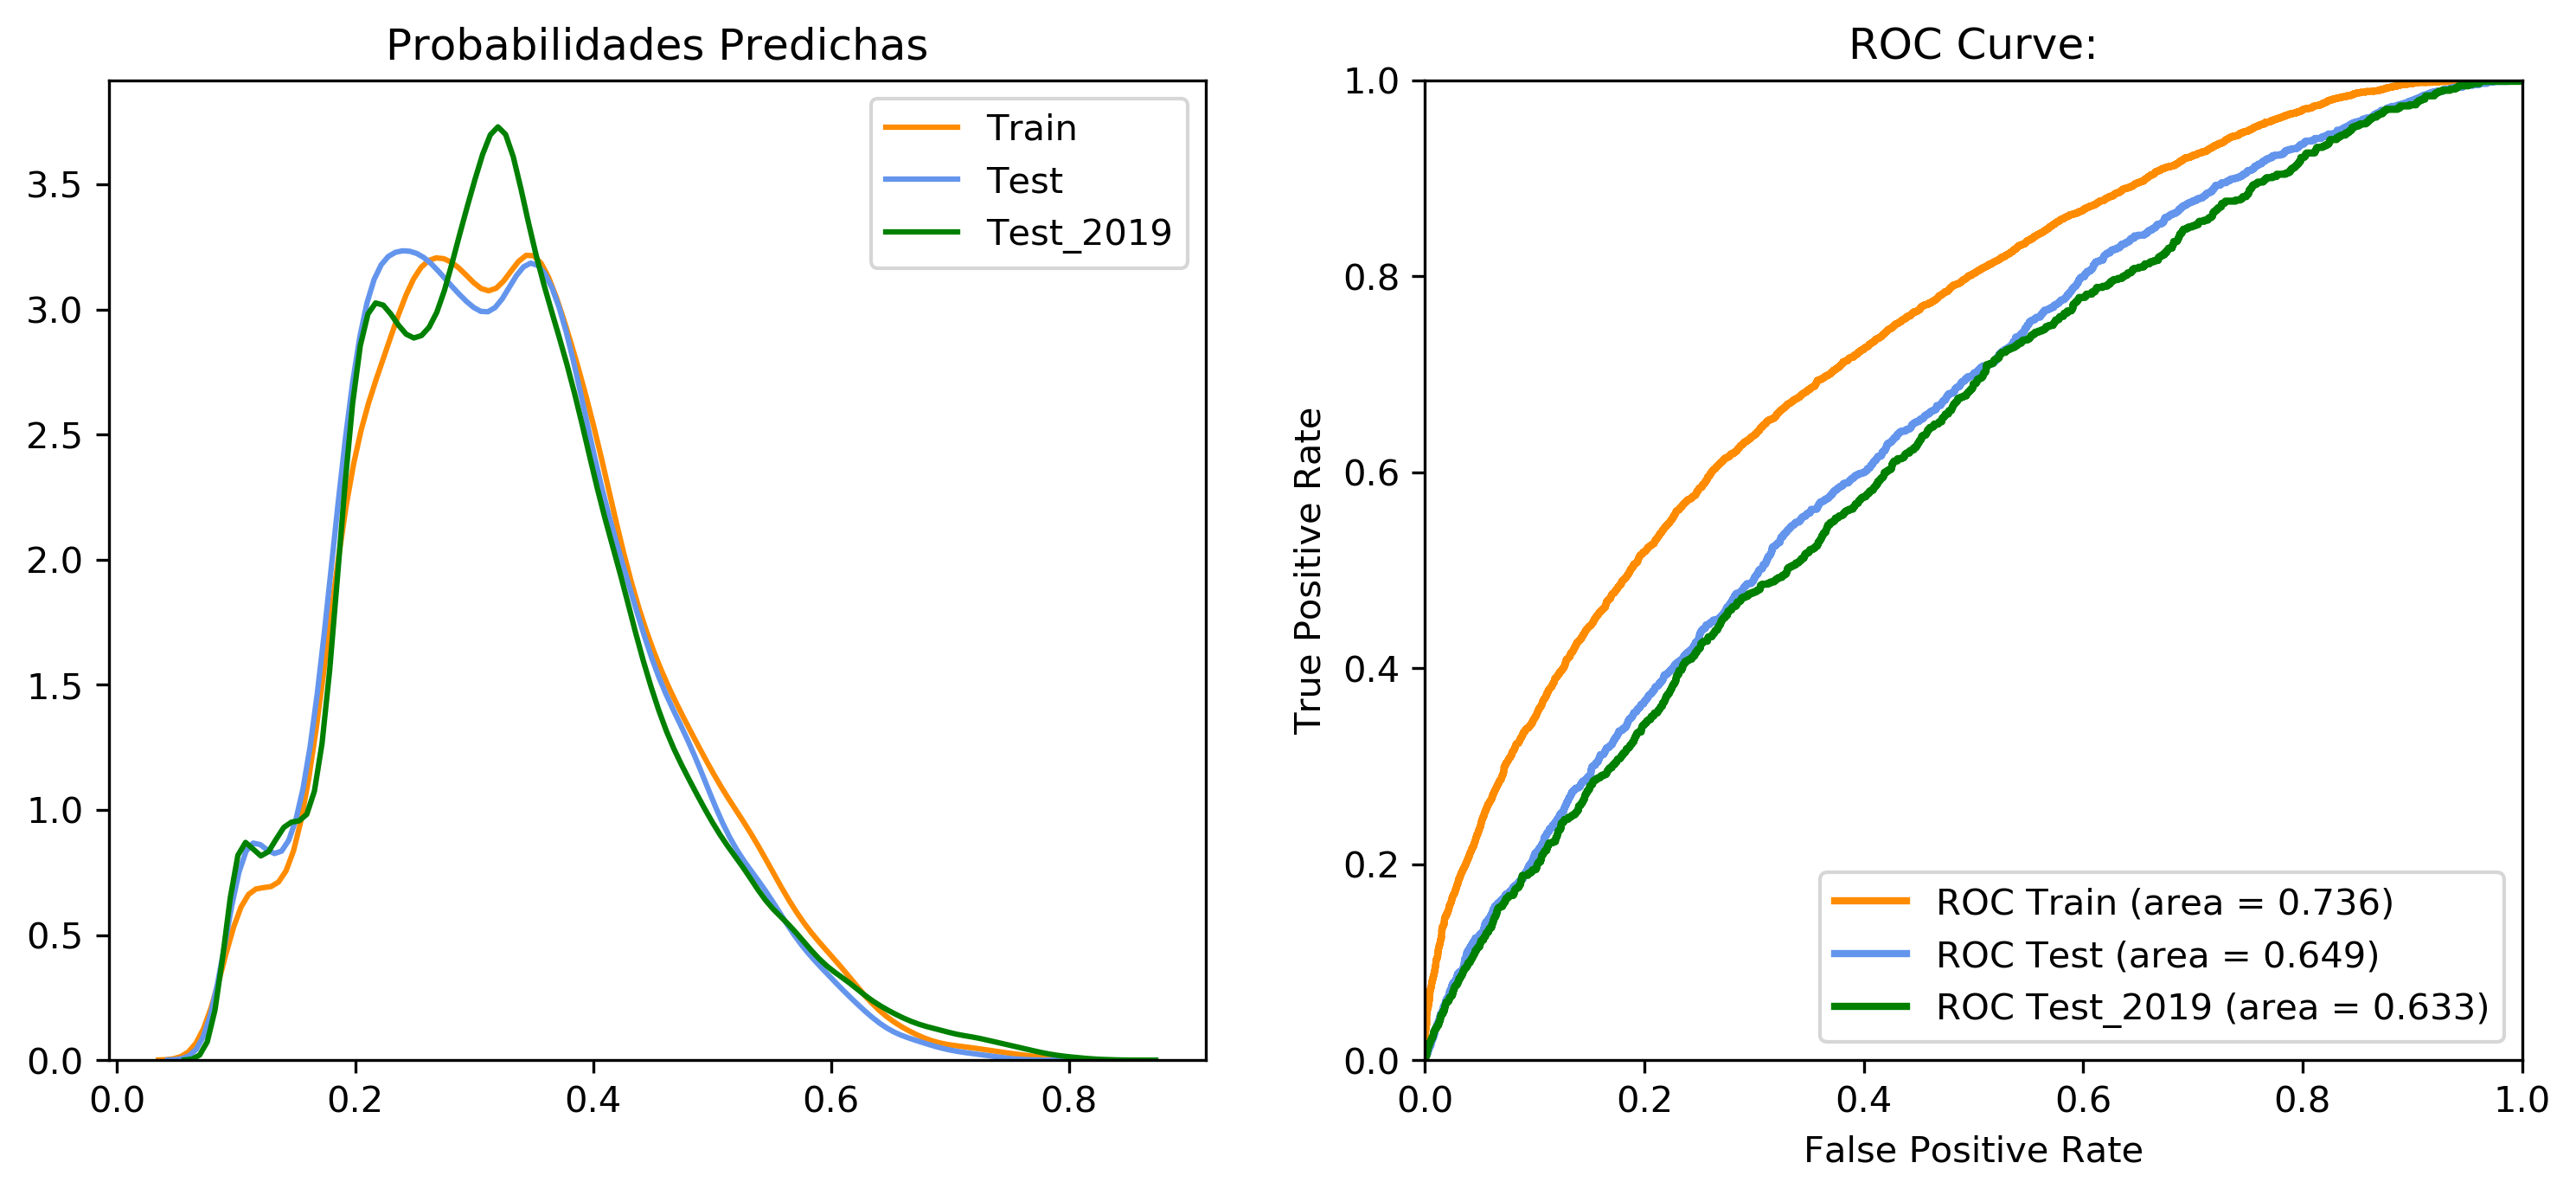

<Figure size 432x288 with 0 Axes>

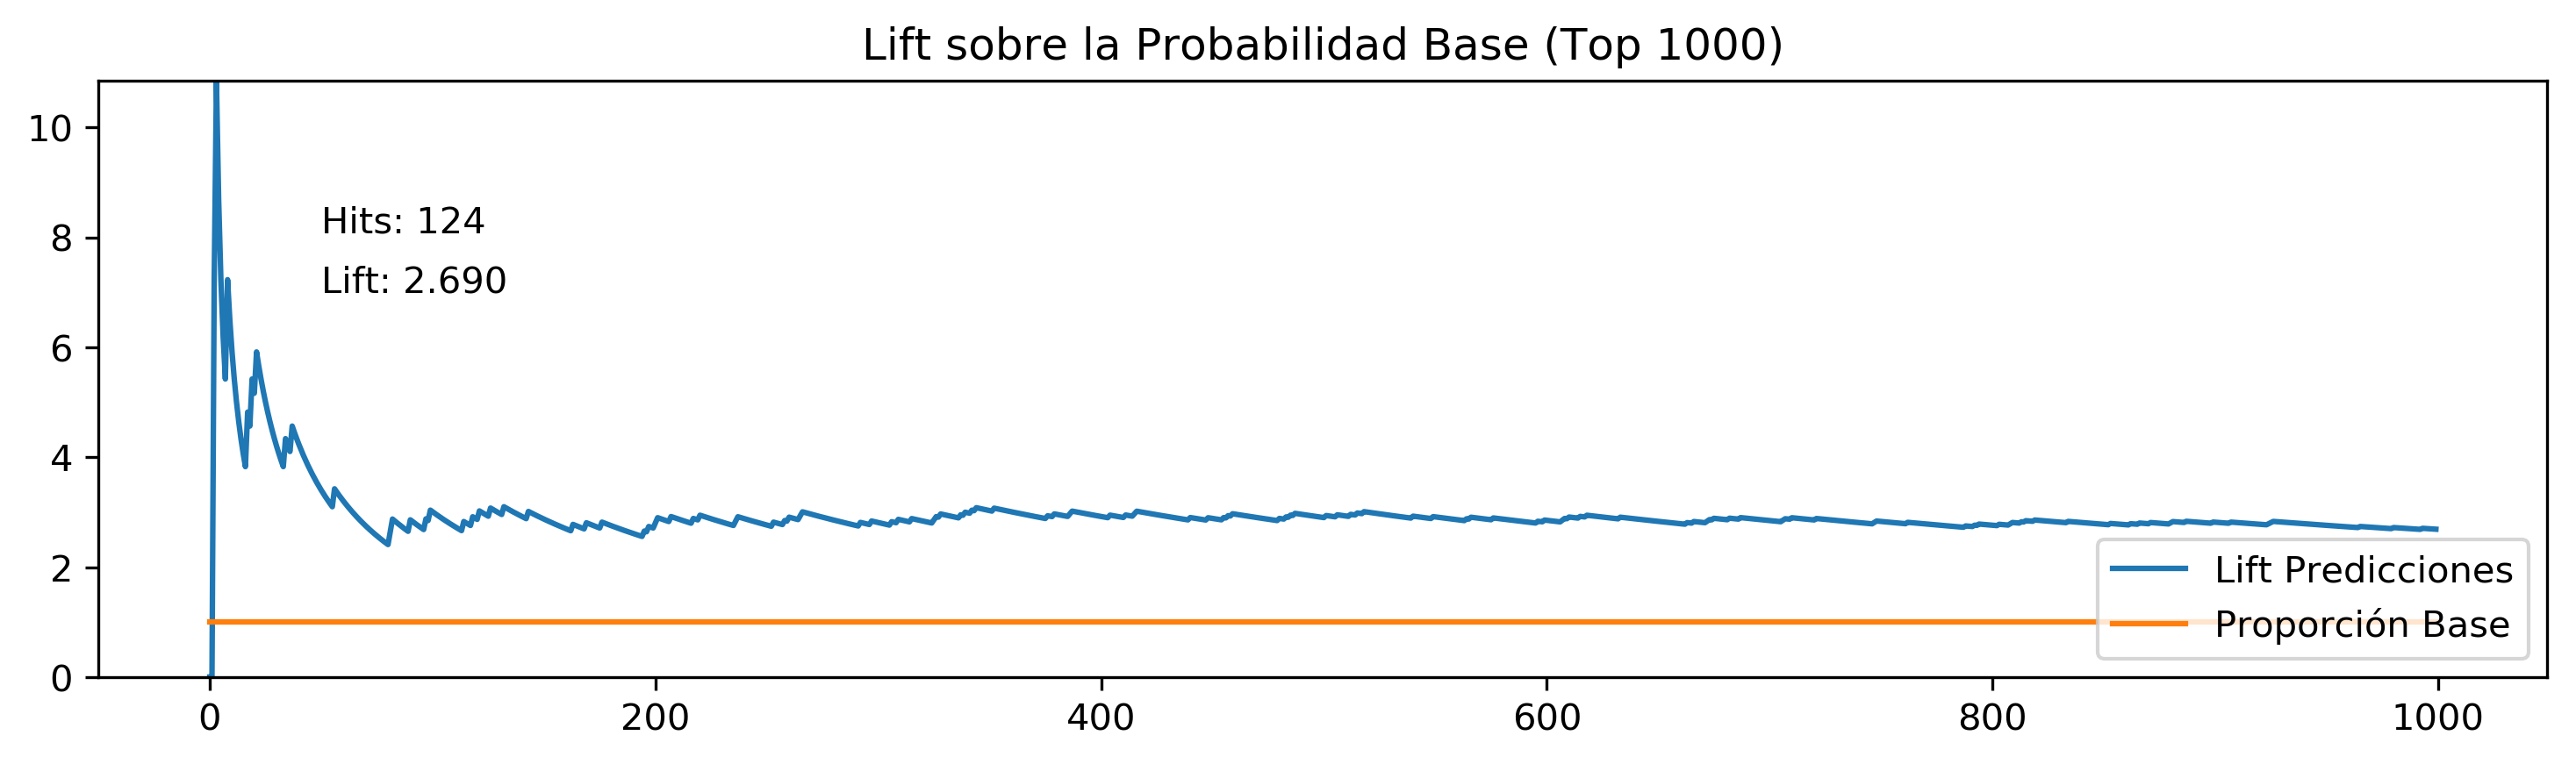

In [43]:
dropped_models = ['svc','knn']
ens_lr_mdl = LogisticRegression(max_iter = 30000, C=0.01,solver='lbfgs')
ens_lr_mdl.fit(pd.DataFrame(probs['trn']).drop(dropped_models, axis=1), Y_trn)
Y_pred = ens_lr_mdl.predict_proba(pd.DataFrame(probs['trn']).drop(dropped_models, axis=1))[:,1]
Y_pred_val = ens_lr_mdl.predict_proba(pd.DataFrame(probs['val']).drop(dropped_models, axis=1))[:,1]
Y_pred_tst = ens_lr_mdl.predict_proba(pd.DataFrame(probs['tst']).drop(dropped_models, axis=1))[:,1]
evaluate_predictions(Y_trn, Y_pred, Y_pred_val, Y_pred_tst, lift_label_y=7)

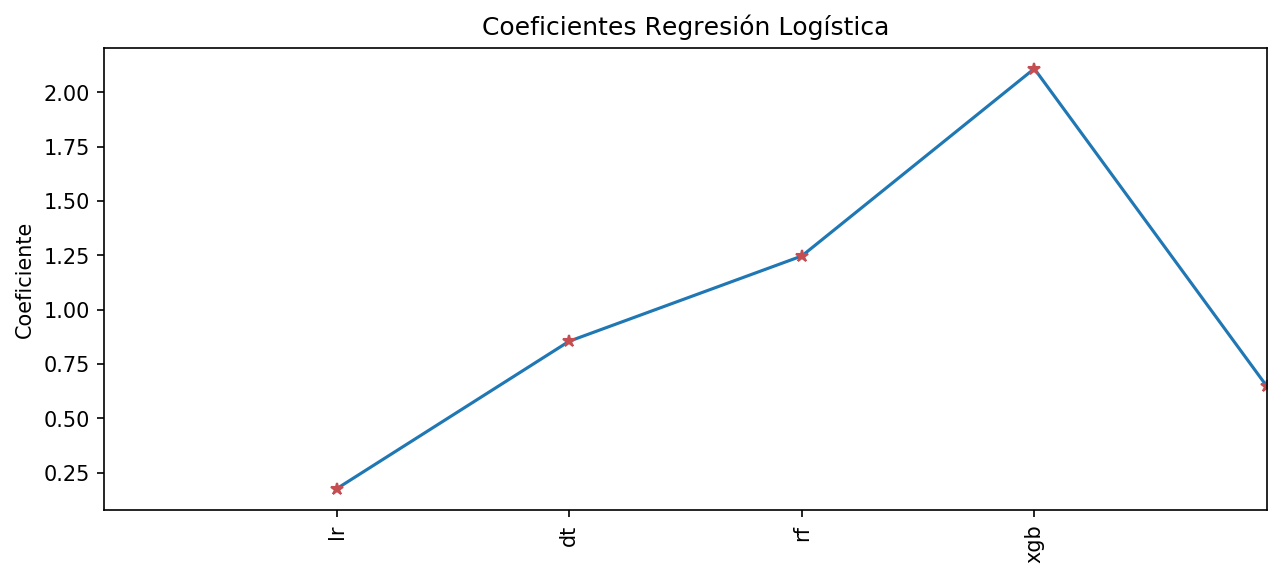

In [379]:
nticks_coefs = len(pd.DataFrame(probs['trn']).drop(dropped_models, axis=1).columns)-1
plt.figure(figsize=(10,4), dpi=150)
plt.title('Coeficientes Regresión Logística')
plt.xlabel('')
plt.ylabel('Coeficiente')
plt.xlim(-1, nticks_coefs)
plt.xticks(range(nticks_coefs), list(pd.DataFrame(probs['trn']).drop(dropped_models, axis=1).columns), rotation='vertical')
_ = plt.plot(ens_lr_mdl.coef_.reshape( nticks_coefs + 1), '-', ens_lr_mdl.coef_.reshape( nticks_coefs +1), 'r*')

In [368]:
# Guardo los modelos
with open("models.pickle", "wb") as f:
    pickle.dump((knn_mdl, lr_mdl, dt_mdl, svc_mdl, rf_mdl, xgb_mdl), f)

# Guardo las probabilidades predichas para todos los modelos
with open("probs.pickle", "wb") as f:
    pickle.dump(probs, f)
    
### NOTA: por un problema de compatibilidad entre TensorFlow y pickle, la mlp_mdl no se puede picklear, pero la red se entrena rápido y tiene las semillas puestas para ser replicable

In [15]:
# Para cargar el diccionario de predicciones
with open("probs.pickle", "rb") as f:
    probs = pickle.load(f)
# Para cargar los modelos
with open("models.pickle", "rb") as f:
    knn_mdl, lr_mdl, dt_mdl, svc_mdl, rf_mdl, xgb_mdl = pickle.load(f) 

### Características Top1000 Ensemble

In [112]:
Y_pred = pd.DataFrame(probs['trn']).drop(dropped_models, axis=1).apply(threshold, axis=0).apply(np.mean, axis=1)
lr_trn_0=lr_trn.loc[Y_pred<=0.5,]
lr_trn_1=lr_trn.loc[Y_pred>0.5,]


In [113]:
comp_df=pd.DataFrame({
    'Variable':list(lr_trn.mean().index),
    'Medias Total':lr_trn_0.mean(),
    'Medias Predicho=1':lr_trn_1.mean(),
    'Diferencia (%)':(lr_trn_1.mean()/lr_trn_0.mean()-1)*100,
})

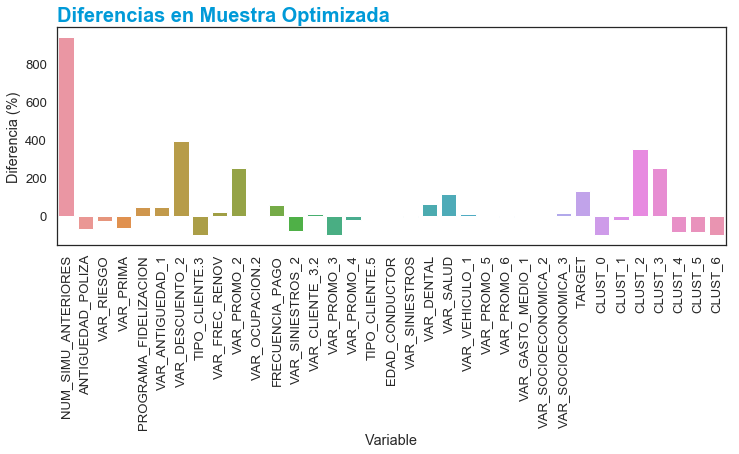

In [114]:
plt.figure(figsize=(12,4))
sns.set_style("white")
plot = sns.barplot(x="Variable", y="Diferencia (%)", data=comp_df)
plot.set_title("Diferencias en Muestra Optimizada", fontdict={'family': 'sans',
        'color':  "#009ad8",
        'weight': 'bold',
        'size': 20},  loc='left')
plt.xticks(rotation=90)
plt.show();

In [46]:
### Grafico comparando Fbetas contra Lift en los modelos
f_plot_df=pd.DataFrame({
    'Modelo':["Aleatorio",
"KNN",
"Regresión Logística",
"Árbol de Decisión",
"Support Vector Machine",
"Random Forest",
"XGBoost",
"Perceptrón Multicapa",
"Ensemble Medias",
"Ensemble Votación",
"Ensemble Regresión"],
    'Fbeta':[0.057,
0.073,
0.098,
0.09,
0.074,
0.103,
0.103,
0.106,
0.111,
0.109,
0.108],
    'Lift':[1,
1.083333333,
2.208333333,
2.125,
2.0625,
2.395833333,
2.5625,
2.375,
2.729166667,
2.604166667,
2.583333333]
})

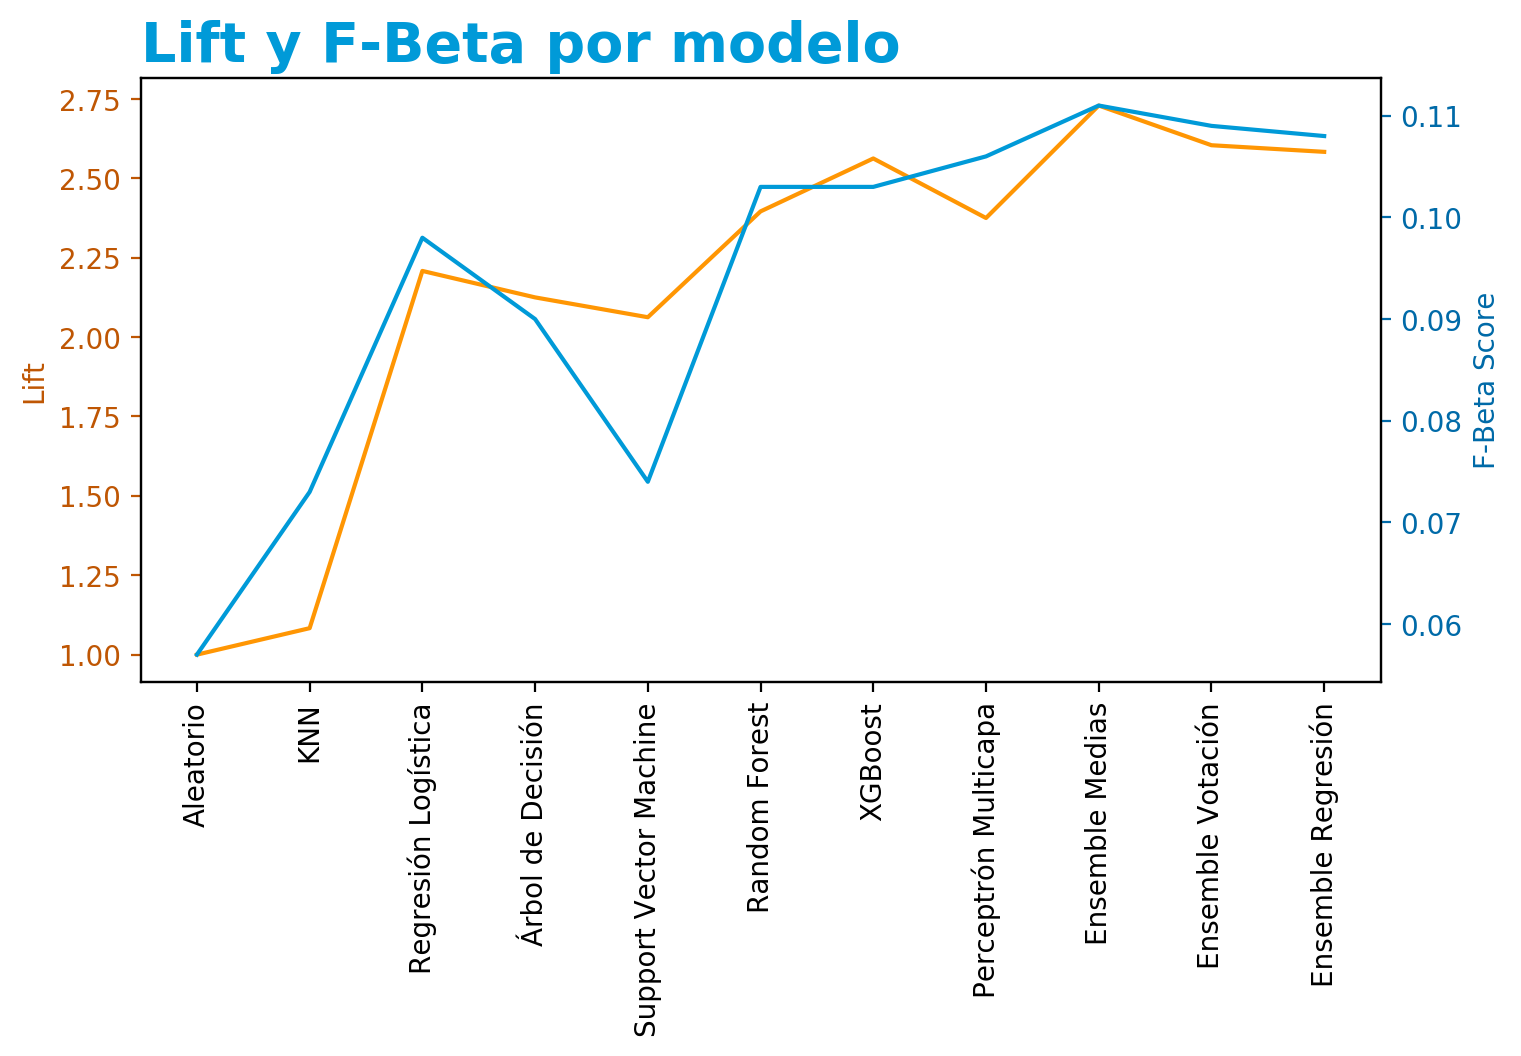

In [76]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8,4), dpi=200)
ax1.plot(f_plot_df.Modelo, f_plot_df.Lift, color='#FF9603', linestyle='solid')
ax1.set_xlabel('')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Lift', color='#bf5603')
ax1.tick_params('y', colors='#bf5603')

ax2 = ax1.twinx()
ax2.plot(f_plot_df.Modelo, f_plot_df.Fbeta, color='#009ad8', linestyle='solid')
ax2.set_ylabel('F-Beta Score', color='#006aa8')
ax2.tick_params('y', colors='#006aa8')

ax1.set_title("Lift y F-Beta por modelo", fontdict={'family': 'sans',
        'color':  "#009ad8",
        'weight': 'bold',
        'size': 20},  loc='left')
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
plt.show()